# <a name="C1"><font color='Blue'><h1><center>I. Import package nécessaire</center></h1></font></a>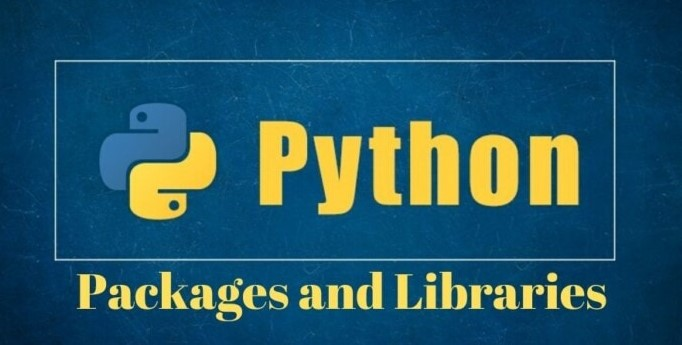

In [17]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from copy import deepcopy
import joblib
from function_utils import *

In [18]:
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [19]:
%matplotlib inline
from pylab import rcParams
import warnings
rcParams['figure.figsize'] = 10, 6
warnings.filterwarnings('ignore')
sns.set(style = "darkgrid")

In [20]:
convertMillis(4564826.023)

'52D : 20h : 0min : 26s'

</Br>

</Br>

# <a name="C2"><font color='orange'><h1><center>II. Import Dataset</center></h1></font></a>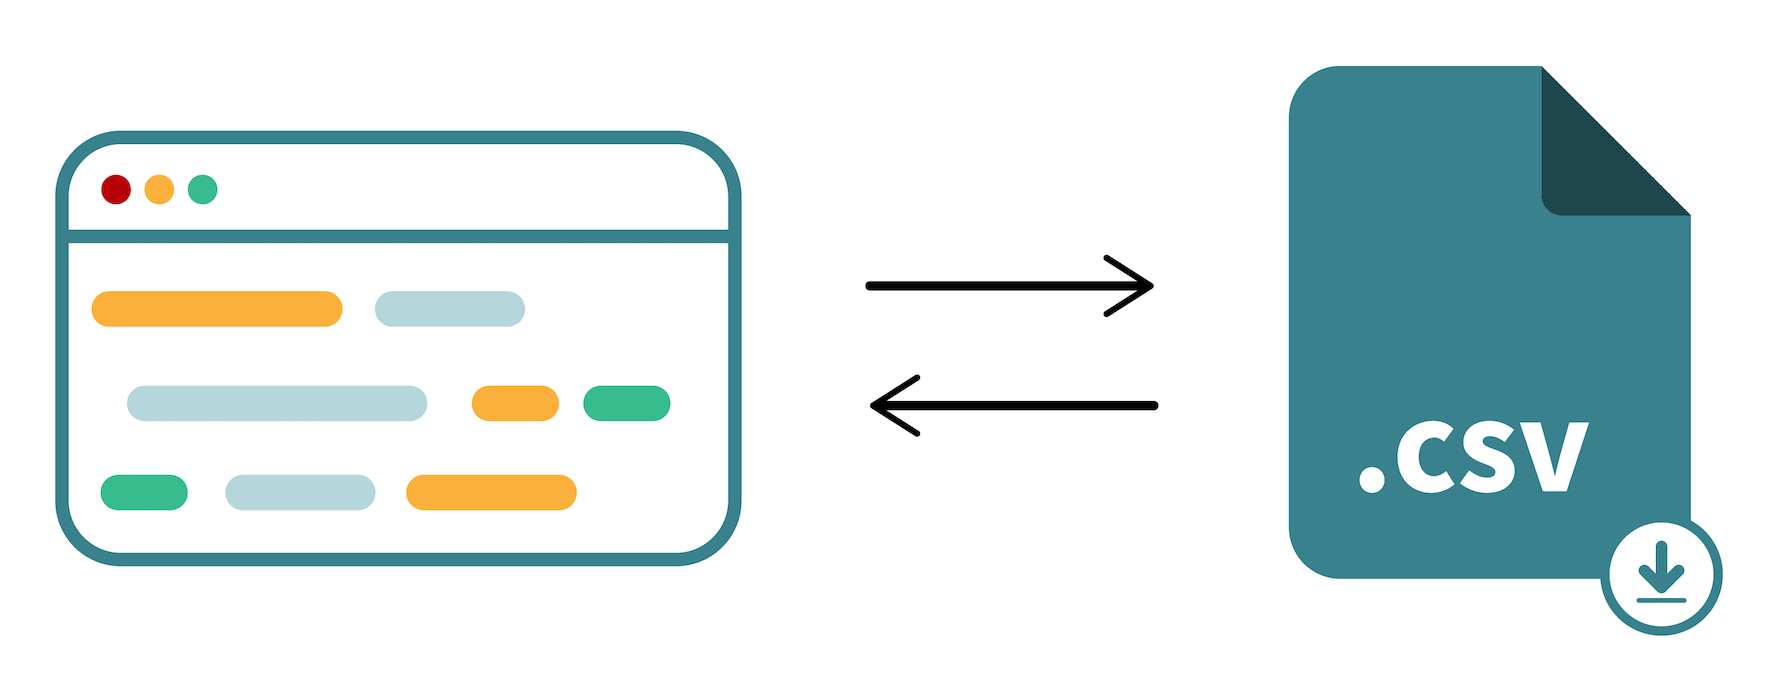

In [21]:
df = pd.read_csv('data/source/application_train.csv')
test_df = pd.read_csv('data/source/application_test.csv')

In [6]:
def clean_data1(data):
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    data = data[data['CODE_GENDER'] != 'XNA']

    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        data[bin_feature], uniques = pd.factorize(data[bin_feature])
    # Categorical features with One-Hot encode
    #df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    data['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
    # Some simple new features (percentages)
    data['PERC_CREDIT_GOODS_PRICE'] = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE']
    data['INCOME_CREDIT_PERC'] = data['AMT_INCOME_TOTAL'] / data['AMT_CREDIT']
    data['PAYMENT_RATE'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
    data['INCOME_PER_CHILDREN'] = data['AMT_INCOME_TOTAL'] / (data['CNT_CHILDREN']+1)# revenu par enfant
    data['ANNUITY_INCOME_PERC'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['DEF_RATE'] = data['DEF_60_CNT_SOCIAL_CIRCLE']/data['DEF_30_CNT_SOCIAL_CIRCLE'] 
    data['CHIDREN_RATE'] = data['CNT_CHILDREN'] / data['CNT_FAM_MEMBERS']# ratio d'enfant

    # ratio defaillance
    data['DEF_30_RATE'] = data['DEF_30_CNT_SOCIAL_CIRCLE'] / data['OBS_30_CNT_SOCIAL_CIRCLE']
    data['DEF_60_RATE'] = data['DEF_60_CNT_SOCIAL_CIRCLE'] / data['OBS_60_CNT_SOCIAL_CIRCLE']
    
    return data

In [7]:
df = clean_data1(df)
test_df = clean_data1(test_df)

## <font color='orange'> * Import sauvegarde dataset</font>

In [8]:
if 'df' not in locals():
    print("Le dataset sera importé à partir d'une sauvegarde .csv")
    df = pd.read_csv('data/cleaned/df_cleaned.csv',sep=';')

In [9]:
df.shape

(307507, 131)

In [10]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_YEAR,PERC_CREDIT_GOODS_PRICE,INCOME_CREDIT_PERC,PAYMENT_RATE,INCOME_PER_CHILDREN,ANNUITY_INCOME_PERC,DEF_RATE,CHIDREN_RATE,DEF_30_RATE,DEF_60_RATE
0,100002,1,Cash loans,0,0,0,0,202500.0,406597.5,24700.5,...,1.0,1.158397,0.498036,0.060749,202500.0,0.121978,1.0,0.0,1.0,1.0
1,100003,0,Cash loans,1,0,1,0,270000.0,1293502.5,35698.5,...,0.0,1.145199,0.208736,0.027598,270000.0,0.132217,NaN,0.0,0.0,0.0
2,100004,0,Revolving loans,0,1,0,0,67500.0,135000.0,6750.0,...,0.0,1.000000,0.500000,0.050000,67500.0,0.100000,NaN,0.0,NaN,NaN
3,100006,0,Cash loans,1,0,0,0,135000.0,312682.5,29686.5,...,NaN,1.052803,0.431748,0.094941,135000.0,0.219900,NaN,0.0,0.0,0.0
4,100007,0,Cash loans,0,0,0,0,121500.0,513000.0,21865.5,...,0.0,1.000000,0.236842,0.042623,121500.0,0.179963,NaN,0.0,NaN,NaN


</Br>

</Br>

# <a name="C3"><font color='green'><h1><center>III. Machine Learnig</center></h1></font></a>

## <a name="C31"><font color='green'>III.1 packages nécessaires modélisation</font></a>
</Br>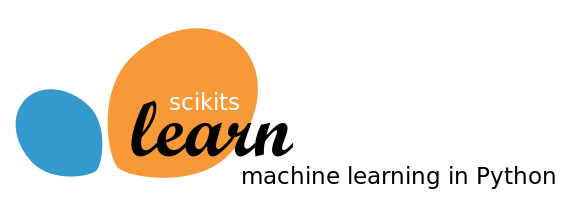

In [11]:
# Modelisation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (HistGradientBoostingClassifier, 
                              GradientBoostingClassifier,
                              RandomForestClassifier, 
                              AdaBoostClassifier)

from lightgbm import LGBMClassifier as lgbmc
from sklearn import dummy

# Cross-Validation
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

# Metrics
from sklearn.metrics import (roc_auc_score, f1_score, recall_score, balanced_accuracy_score, 
                             accuracy_score, log_loss ,precision_score,
                            roc_curve, confusion_matrix, ConfusionMatrixDisplay )

# pipeline data transformation
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer , make_column_selector
from sklearn.preprocessing import OneHotEncoder,StandardScaler

</Br>

</Br>

## <a name="C32"><font color='green'>III.2 Train test Validation split</font></a>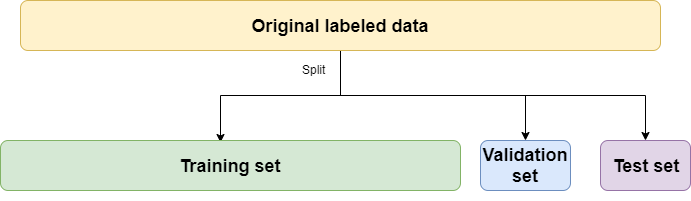

In [12]:
X = df.drop(columns=['TARGET','SK_ID_CURR'])
y = df['TARGET']

## inf
X[X==np.inf] = np.nan

random_seed = 971

# Le dataset est grand on peut diviser le données en train test valiation 
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=random_seed,stratify=y) #~~100000 samples
X_test, X_validation, y_test, y_validation = train_test_split( X_test, y_test, test_size=0.5, random_state=random_seed,stratify=y_test) 

print('Le dataset Train se compose de: {0} lignes et {1} colonnes'.format( X_train.shape[0],X_train.shape[1]) )
print('Le dataset Test se compose de: {0} lignes et {1} colonnes'.format( X_test.shape[0],X_test.shape[1]) )
print('Le dataset Validation se compose de: {0} lignes et {1} colonnes'.format(X_validation.shape[0], X_validation.shape[1]) )

Le dataset Train se compose de: 215254 lignes et 129 colonnes
Le dataset Test se compose de: 46126 lignes et 129 colonnes
Le dataset Validation se compose de: 46127 lignes et 129 colonnes


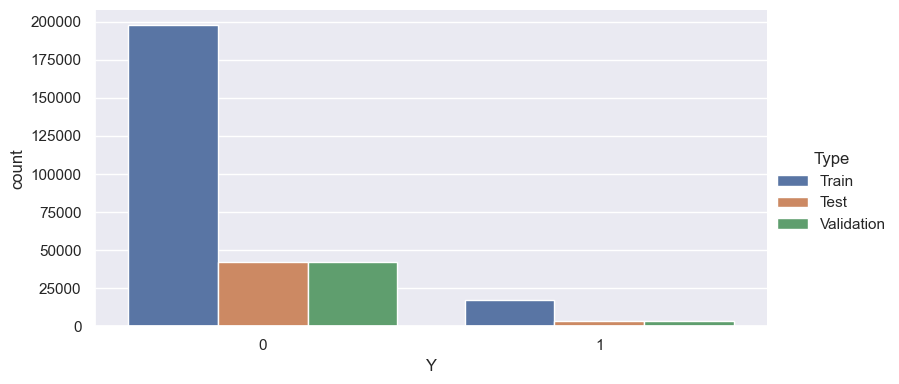

In [13]:
graphData = pd.concat([
    pd.DataFrame(np.c_[y_train,['Train' for x in y_train]],columns=['Y','Type'] ),
    pd.DataFrame(np.c_[y_test,['Test' for x in y_test]],columns=['Y','Type'] ),
    pd.DataFrame(np.c_[y_validation,['Validation' for x in y_validation]],columns=['Y','Type'] )],
    axis=0)

graphData.Y=graphData.Y.astype(np.int16)

sns.catplot(data=graphData, kind='count', x='Y', height=4, aspect=2,hue='Type');

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215254 entries, 81522 to 379
Columns: 129 entries, NAME_CONTRACT_TYPE to DEF_60_RATE
dtypes: float64(75), int64(41), object(13)
memory usage: 213.5+ MB


In [15]:
X_train.isna().sum()/X_train.shape[0]

NAME_CONTRACT_TYPE     0.000000
CODE_GENDER            0.000000
FLAG_OWN_CAR           0.000000
FLAG_OWN_REALTY        0.000000
CNT_CHILDREN           0.000000
                         ...   
ANNUITY_INCOME_PERC    0.000051
DEF_RATE               0.886065
CHIDREN_RATE           0.000009
DEF_30_RATE            0.537086
DEF_60_RATE            0.539525
Length: 129, dtype: float64

</Br>

</Br>

</Br>

## <a name="C33"><font color='green'>III.3 Création pipeline preprocessing data</font></a>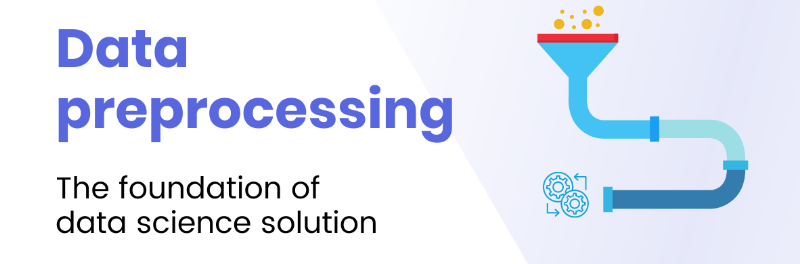

In [16]:

def intermediaire_pipe_pretraitement(X_train,model):
    """
    Fonction qui crée un pipeline, en prétraitant les données en amont puis
    en appliquant un model à la fin

    Args:
        X_train (pandas.core.frame.DataFrame): Training Dataset.
        model (type): model de type sklearn. C'est à dire possedant la méthode fit

    Returns:
        type: Description de la valeur de retour.

    Raises:
        ErrorType: Description de l'erreur éventuellement levée.

    Examples:
        Exemples d'utilisation de la fonction.
    """    
    #Numerical featues
    numeric_features = make_column_selector(dtype_include=np.float64)
    numeric_transformer = Pipeline(
        steps=[('impNumerical', SimpleImputer(strategy="median")) ]
    )

    #Discretes features
    discret_features = make_column_selector(dtype_include=np.int64)
    discret_transformer = Pipeline(
        steps=[('impDiscret', SimpleImputer(strategy = 'most_frequent')) ]
    )

    # categorials features
    categorical_features = make_column_selector(dtype_include="object")
    categorical_transformer = Pipeline(
        steps=[
            ('impCat', SimpleImputer(strategy = 'most_frequent')),
            ('ohe', OneHotEncoder(drop = 'first', handle_unknown = 'ignore',sparse=False)),
        ])

    # columntransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ("num",  numeric_transformer, numeric_features),
            ("disc", discret_transformer, discret_features),
            ("cat",  categorical_transformer, categorical_features),
        ])

    # pipeline
    intermediaire_pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("model",model)]
    )
    
    return intermediaire_pipeline

In [17]:
# Entraîner le pipeline sur les données d'entraînement
intermediaire_pipeline = intermediaire_pipe_pretraitement( X_train,StandardScaler() )
#intermediaire_pipeline = overSamplingFunction( X_train,StandardScaler() )
    
# Application pipeline    
X_train_pt = pd.DataFrame(intermediaire_pipeline.fit_transform(X_train),
                          columns=intermediaire_pipeline.get_feature_names_out()
                         )

In [18]:
intermediaire_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impNumerical',
                                                                   SimpleImputer(strategy='median'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000257214A1AF0>),
                                                 ('disc',
                                                  Pipeline(steps=[('impDiscret',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000257214A1E20>),
                                                 ('cat',
                                                  Pipeline(steps=[('impCat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000257214B7070>)])),
                ('model', StandardScaler())])

In [19]:
X_train_pt.head()

,num__AMT_INCOME_TOTAL,num__AMT_CREDIT,num__AMT_ANNUITY,num__AMT_GOODS_PRICE,num__REGION_POPULATION_RELATIVE,num__DAYS_EMPLOYED,num__DAYS_REGISTRATION,num__OWN_CAR_AGE,num__CNT_FAM_MEMBERS,num__EXT_SOURCE_1,...,cat__FONDKAPREMONT_MODE_reg oper spec account,cat__HOUSETYPE_MODE_specific housing,cat__HOUSETYPE_MODE_terraced house,cat__WALLSMATERIAL_MODE_Mixed,cat__WALLSMATERIAL_MODE_Monolithic,cat__WALLSMATERIAL_MODE_Others,cat__WALLSMATERIAL_MODE_Panel,"cat__WALLSMATERIAL_MODE_Stone, brick",cat__WALLSMATERIAL_MODE_Wooden,cat__EMERGENCYSTATE_MODE_Yes
0,1.111520,-0.135154,-0.119380,-0.240315,0.309525,0.453656,1.022546,0.973500,0.928981,0.012651,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585
1,-0.100237,-0.649958,-0.288185,-0.544561,0.309525,-2.357397,1.294713,-0.006215,-0.168448,0.104088,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585
2,0.505641,-0.017281,-0.306182,-0.240315,1.830912,0.876951,-0.570118,-1.265848,0.928981,-0.693097,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585
3,1.515439,-0.764348,0.301389,-0.727109,-0.012079,-1.479469,0.557758,-0.985929,0.928981,0.012651,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585
4,0.182506,1.053627,0.639929,0.854973,-0.716342,0.852629,-0.014987,-0.146174,0.928981,0.012651,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585


In [20]:
X_train_pt.filter(regex='^cat', axis=1).head()

,cat__NAME_CONTRACT_TYPE_Revolving loans,cat__NAME_TYPE_SUITE_Family,cat__NAME_TYPE_SUITE_Group of people,cat__NAME_TYPE_SUITE_Other_A,cat__NAME_TYPE_SUITE_Other_B,"cat__NAME_TYPE_SUITE_Spouse, partner",cat__NAME_TYPE_SUITE_Unaccompanied,cat__NAME_INCOME_TYPE_Commercial associate,cat__NAME_INCOME_TYPE_Maternity leave,cat__NAME_INCOME_TYPE_Pensioner,...,cat__FONDKAPREMONT_MODE_reg oper spec account,cat__HOUSETYPE_MODE_specific housing,cat__HOUSETYPE_MODE_terraced house,cat__WALLSMATERIAL_MODE_Mixed,cat__WALLSMATERIAL_MODE_Monolithic,cat__WALLSMATERIAL_MODE_Others,cat__WALLSMATERIAL_MODE_Panel,"cat__WALLSMATERIAL_MODE_Stone, brick",cat__WALLSMATERIAL_MODE_Wooden,cat__EMERGENCYSTATE_MODE_Yes
0,-0.324055,-0.387587,-0.030035,-0.053572,-0.076118,-0.195523,0.480435,-0.551162,-0.003733,-0.467432,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585
1,-0.324055,-0.387587,-0.030035,-0.053572,-0.076118,-0.195523,0.480435,-0.551162,-0.003733,-0.467432,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585
2,-0.324055,-0.387587,-0.030035,-0.053572,-0.076118,-0.195523,0.480435,1.814349,-0.003733,-0.467432,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585
3,-0.324055,-0.387587,-0.030035,-0.053572,-0.076118,-0.195523,0.480435,-0.551162,-0.003733,-0.467432,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585
4,-0.324055,-0.387587,-0.030035,-0.053572,-0.076118,5.114485,-2.081448,-0.551162,-0.003733,-0.467432,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585


In [21]:
del X_train_pt
gc.collect()

3950

## <a name="C33"><font color='green'>III.3 Comparaison performance des différents Models</font></a>

In [22]:
score_auc = dict()

In [23]:
idx_risk = np.where(y_test == 1.0)[0]
idx_bon = np.random.choice( np.where(y_test != 1.0)[0], size = len( idx_risk ), replace = False)


X_test_equil = pd.concat([X_test.iloc[idx_risk,:],
                          X_test.iloc[idx_bon,:] ],axis=0)

y_test_equil = pd.concat([y_test.iloc[idx_risk],
                          y_test.iloc[idx_bon] ])

### <a name="C331"><font color='green'>III.3.1 Dummy Estimateur</font></a>

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 50.00%
La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: 50.00%
L'entrainement s'exécute en moyenne en : 4s


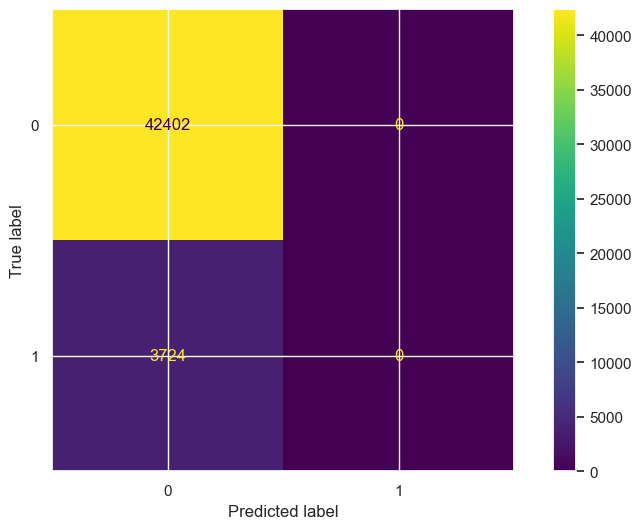

CPU times: total: 4.7 s
Wall time: 11.9 s


In [24]:
%%time
# Use the copy module of Python for deep copy operations
dummy_pipe = deepcopy(intermediaire_pipeline)

# pipe.steps works in the same way as lists do, so I can also insert an item into a specific location:
dummy_pipe.steps.append(['clf',dummy.DummyClassifier(strategy='most_frequent')])
score_auc['dummyEstimator'] = cross_validate(dummy_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = ['roc_auc','balanced_accuracy'])

# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['dummyEstimator']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['dummyEstimator']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['dummyEstimator']['fit_time'].mean(),4)))


cm = confusion_matrix(y_test, dummy_pipe.fit(X_train, y_train).predict(X_test), labels=dummy_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dummy_pipe.classes_)
disp.plot()
plt.show()

<Axes: xlabel='probability', ylabel='Count'>

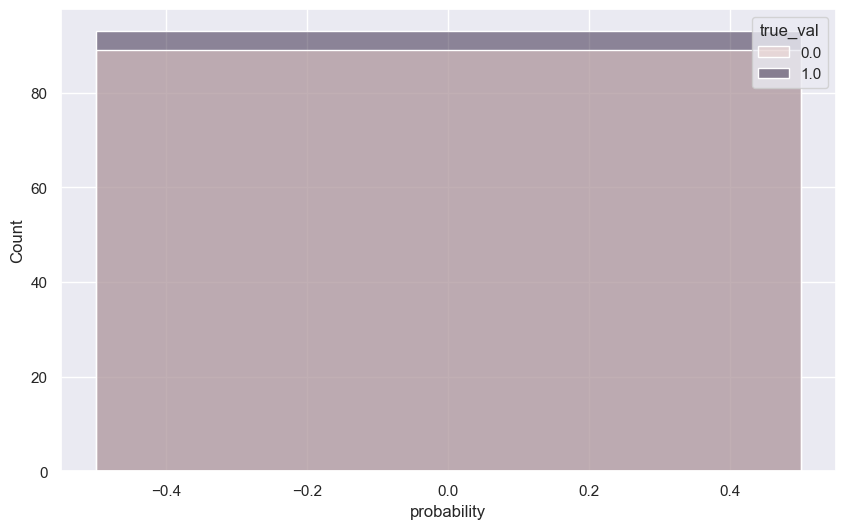

In [25]:
p_clf = pd.DataFrame(dummy_pipe.predict_proba(X_test_equil)[:,1],columns=['probability'])
p_clf['true_val'] = y_test_equil
sns.histplot(data=p_clf, x = 'probability',hue='true_val')

### <a name="C332"><font color='green'>III.3.2 Logistic Regression</font></a>

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 74.58%
La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: 50.62%
L'entrainement s'exécute en moyenne en : 17s


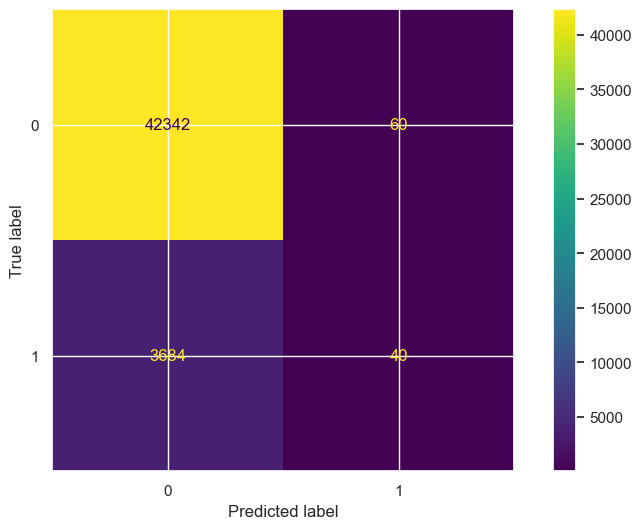

CPU times: total: 11.9 s
Wall time: 31.6 s


In [26]:
%%time
# Use the copy module of Python for deep copy operations
regLog_pipe_raw = deepcopy(intermediaire_pipeline)

# pipe.steps works in the same way as lists do, so I can also insert an item into a specific location:
regLog_pipe_raw.steps.append(['clf',LogisticRegression()])

#regLog_pipe.fit(X_train, y_train)
score_auc['RegLog_Raw'] = cross_validate(regLog_pipe_raw, X_train, y_train, 
                                         cv = 5, n_jobs = -1, scoring = ['roc_auc','balanced_accuracy'])

# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RegLog_Raw']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RegLog_Raw']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['RegLog_Raw']['fit_time'].mean(),4)))

cm = confusion_matrix(y_test, regLog_pipe_raw.fit(X_train, y_train).predict(X_test), labels=regLog_pipe_raw.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=regLog_pipe_raw.classes_)
disp.plot()
plt.show()

<Axes: xlabel='probability', ylabel='Percent'>

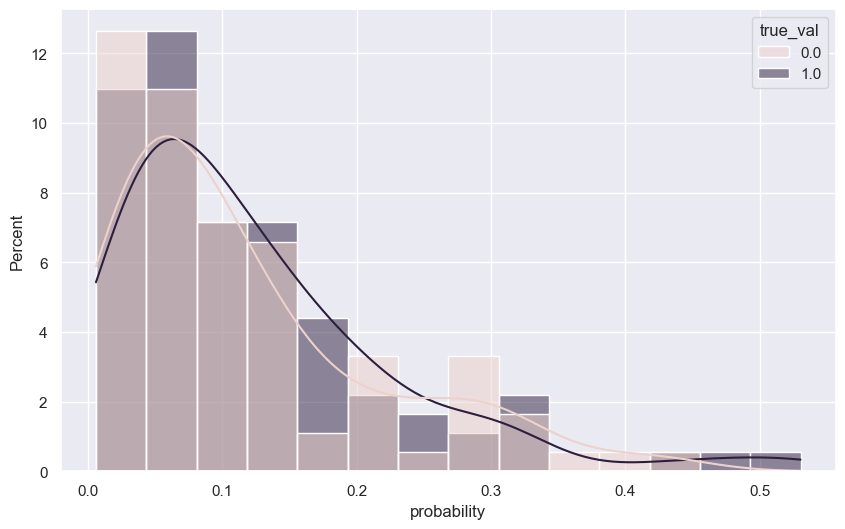

In [27]:
p_clf = pd.DataFrame(regLog_pipe_raw.predict_proba(X_test_equil)[:,1],columns=['probability'])
p_clf['true_val'] = y_test_equil
sns.histplot(data=p_clf, x = 'probability',hue='true_val', kde=True, stat= 'percent')

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 74.60%
La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: 68.20%
L'entrainement s'exécute en moyenne en : 18s


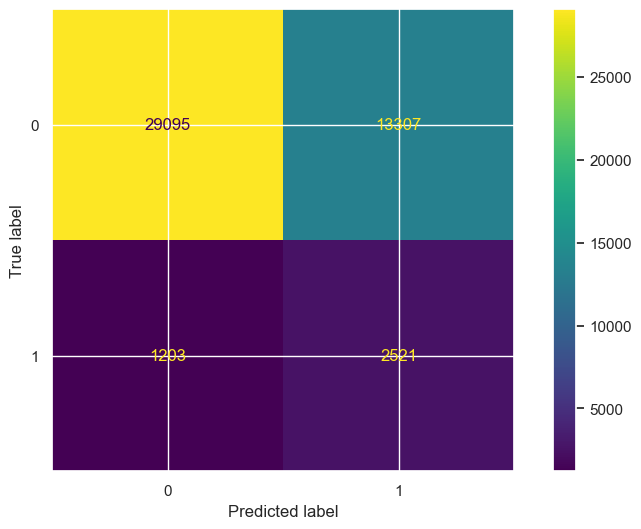

CPU times: total: 12 s
Wall time: 32.2 s


In [28]:
%%time
# Use the copy module of Python for deep copy operations
regLog_pipe = deepcopy(intermediaire_pipeline)

# pipe.steps works in the same way as lists do, so I can also insert an item into a specific location:
regLog_pipe.steps.append(['clf',LogisticRegression(class_weight='balanced')])

#regLog_pipe.fit(X_train, y_train)
score_auc['RegLog_classweight'] = cross_validate(regLog_pipe, X_train, y_train, cv = 5, n_jobs = -1, scoring = ['roc_auc','balanced_accuracy'])

# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RegLog_classweight']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RegLog_classweight']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['RegLog_classweight']['fit_time'].mean(),4)))

cm = confusion_matrix(y_test, regLog_pipe.fit(X_train, y_train).predict(X_test), labels=regLog_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=regLog_pipe.classes_)
disp.plot()
plt.show()

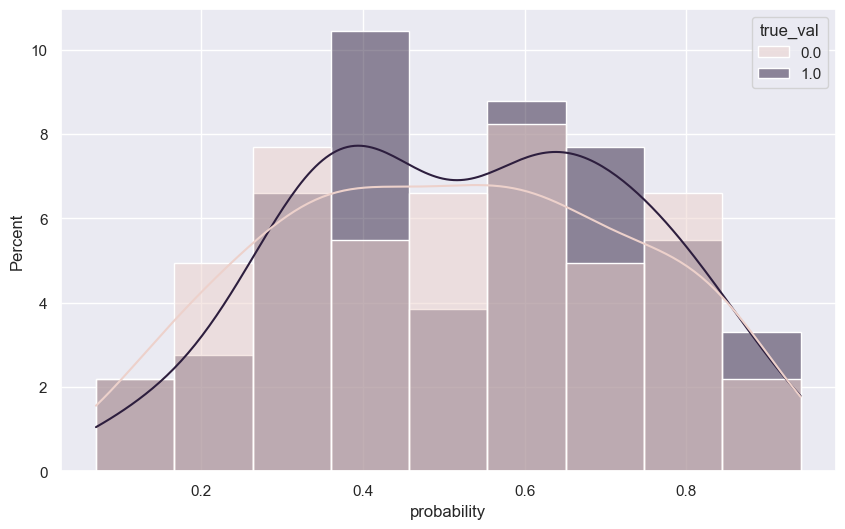

In [29]:
p_clf = pd.DataFrame(regLog_pipe.predict_proba(X_test_equil)[:,1],columns=['probability'])
p_clf['true_val'] = y_test_equil
sns.histplot(data=p_clf, x = 'probability',hue='true_val', kde=True, stat= 'percent');

### <a name="C333"><font color='green'>III.3.3 Adaboost</font></a>

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 74.52%
La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: 50.94%
L'entrainement s'exécute en moyenne en : 25s


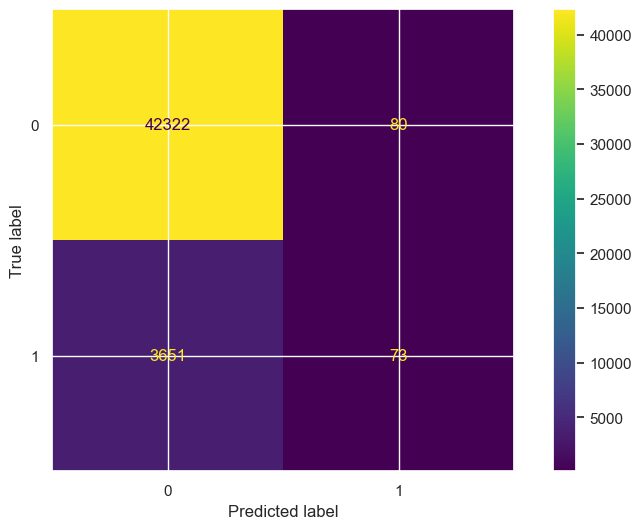

CPU times: total: 1min 14s
Wall time: 2min 47s


In [30]:
%%time
# Use the copy module of Python for deep copy operations
Ada_pipe = deepcopy(intermediaire_pipeline)
Ada_pipe.steps.append(['clf',AdaBoostClassifier()])

#Compute AUC score
score_auc['Adaboost'] = cross_validate(Ada_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = ['roc_auc','balanced_accuracy'])

# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['Adaboost']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['Adaboost']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['Adaboost']['fit_time'].mean(),4)))

cm = confusion_matrix(y_test, Ada_pipe.fit(X_train, y_train).predict(X_test), labels=Ada_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = Ada_pipe.classes_)
disp.plot()
plt.show()

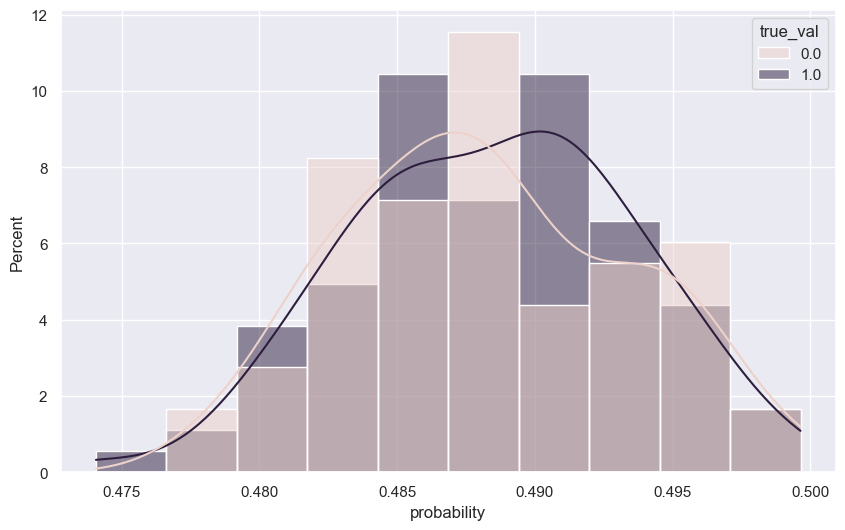

In [31]:
p_clf = pd.DataFrame(Ada_pipe.predict_proba(X_test_equil)[:,1],columns=['probability'])
p_clf['true_val'] = y_test_equil
sns.histplot(data=p_clf, x = 'probability',hue='true_val', kde=True, stat= 'percent');

### <a name="C334"><font color='green'>III.3.4 Random Forest</font></a>

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 72.04%
La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: 50.09%
L'entrainement s'exécute en moyenne en : 51s


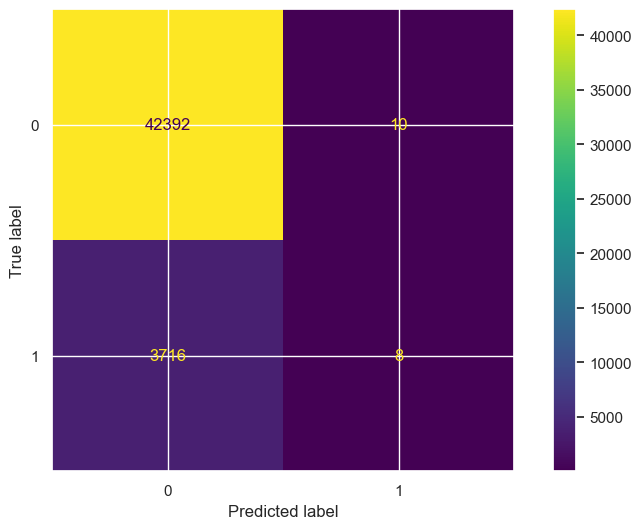

CPU times: total: 2min 36s
Wall time: 1min 15s


In [32]:
%%time
# Use the copy module of Python for deep copy operations
RF_pipe = deepcopy(intermediaire_pipeline)
RF_pipe.steps.append(['clf',RandomForestClassifier(class_weight = "balanced", n_jobs=-1)])

#Compute AUC score
score_auc['RandomForest'] = cross_validate(RF_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = ['roc_auc','balanced_accuracy'])

# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RandomForest']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RandomForest']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['RandomForest']['fit_time'].mean(),4)))

cm = confusion_matrix(y_test, RF_pipe.fit(X_train, y_train).predict(X_test), labels= RF_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= RF_pipe.classes_)
disp.plot()
plt.show()

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 71.73%
La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: 50.11%
L'entrainement s'exécute en moyenne en : 51s


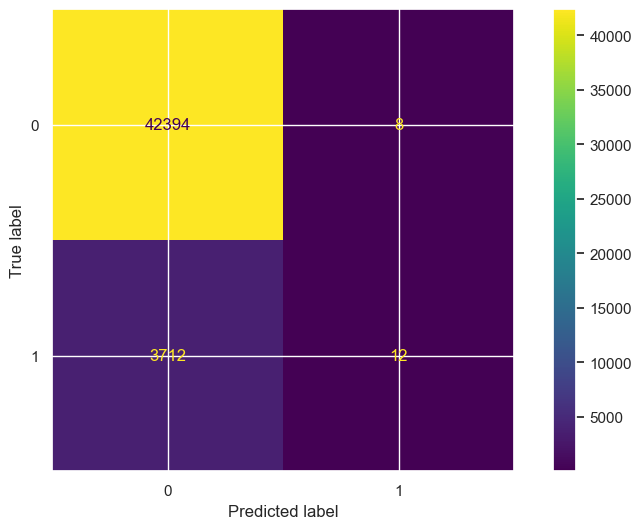

CPU times: total: 2min 36s
Wall time: 1min 14s


In [33]:
%%time
# Use the copy module of Python for deep copy operations
RF_pipe = deepcopy(intermediaire_pipeline)
RF_pipe.steps.append(['clf',RandomForestClassifier(n_jobs=-1,class_weight="balanced")])

#Compute AUC score
score_auc['RandomForest'] = cross_validate(RF_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = ['roc_auc','balanced_accuracy'])

# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RandomForest']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RandomForest']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['RandomForest']['fit_time'].mean(),4)))

cm = confusion_matrix(y_test, RF_pipe.fit(X_train, y_train).predict(X_test), labels= RF_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= RF_pipe.classes_)
disp.plot()
plt.show()

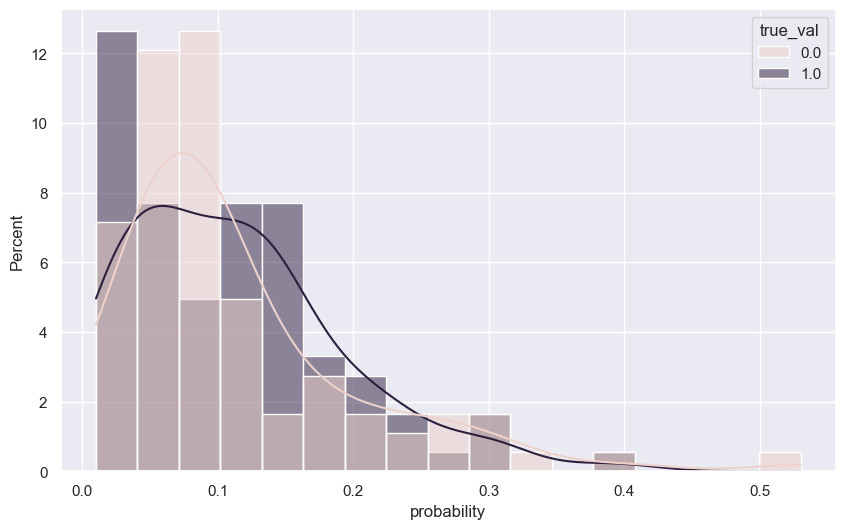

In [34]:
p_clf = pd.DataFrame(RF_pipe.predict_proba(X_test_equil)[:,1],columns=['probability'])
p_clf['true_val'] = y_test_equil
sns.histplot(data=p_clf, x = 'probability',hue='true_val', kde=True, stat= 'percent');

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 72.00%
La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: 50.09%
L'entrainement s'exécute en moyenne en : 51s


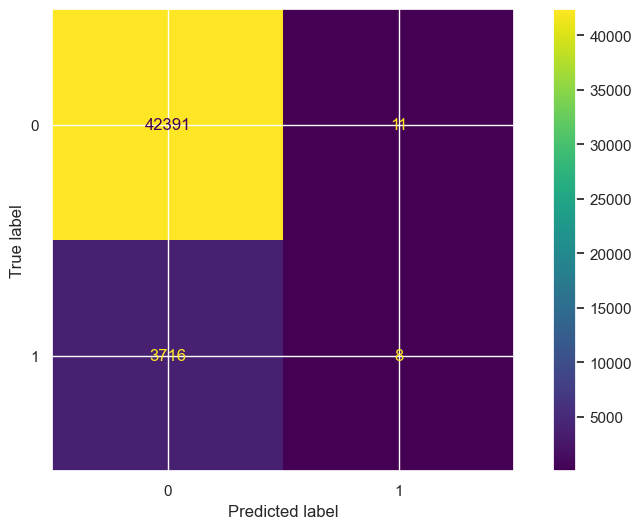

CPU times: total: 2min 40s
Wall time: 1min 18s


In [35]:
%%time
# Use the copy module of Python for deep copy operations
RF_pipe = deepcopy(intermediaire_pipeline)
RF_pipe.steps.append(['clf',RandomForestClassifier(n_jobs=-1,class_weight="balanced_subsample")])

#Compute AUC score
score_auc['RandomForest'] = cross_validate(RF_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = ['roc_auc','balanced_accuracy'])

# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RandomForest']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RandomForest']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['RandomForest']['fit_time'].mean(),4)))

cm = confusion_matrix(y_test, RF_pipe.fit(X_train, y_train).predict(X_test), labels= RF_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= RF_pipe.classes_)
disp.plot()
plt.show()

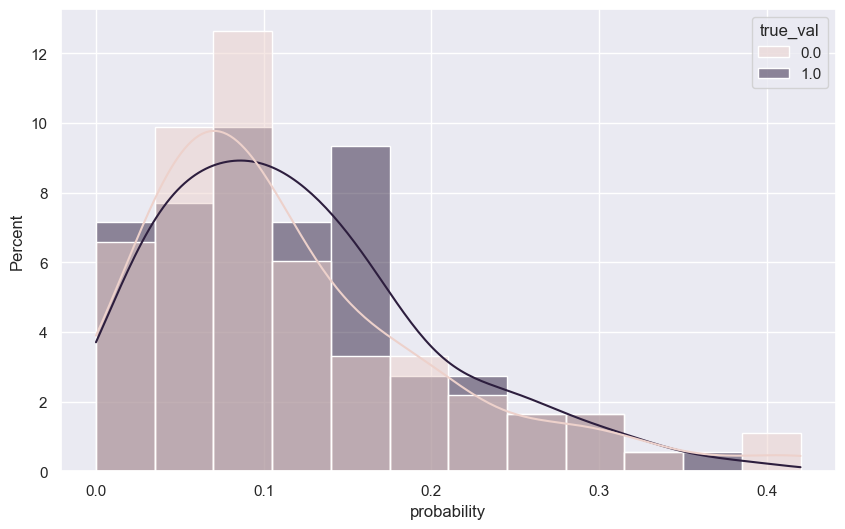

In [36]:
p_clf = pd.DataFrame(RF_pipe.predict_proba(X_test_equil)[:,1],columns=['probability'])
p_clf['true_val'] = y_test_equil
sns.histplot(data=p_clf, x = 'probability',hue='true_val', kde=True, stat= 'percent');

### <a name="C335"><font color='green'>III.3.5  HistGradientBoostingClassifier</font></a>

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 75.87%
La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: 69.05%
L'entrainement s'exécute en moyenne en : 36s


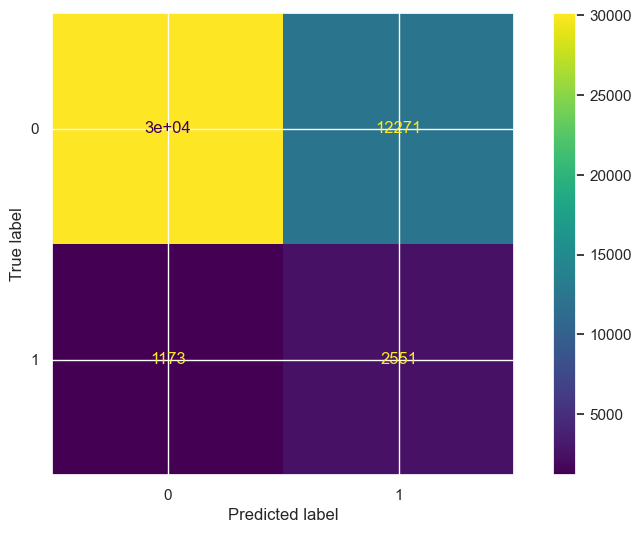

CPU times: total: 1min 54s
Wall time: 57.2 s


In [37]:
%%time
# Use the copy module of Python for deep copy operations
HistGB_pipe = deepcopy(intermediaire_pipeline)
HistGB_pipe.steps.append(['clf',HistGradientBoostingClassifier(class_weight = 'balanced')])

#Compute AUC score
score_auc['HistGradientBoosting'] = cross_validate(HistGB_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = ['roc_auc','balanced_accuracy'])

# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['HistGradientBoosting']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['HistGradientBoosting']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['HistGradientBoosting']['fit_time'].mean(),4)))

cm = confusion_matrix(y_test, HistGB_pipe.fit(X_train, y_train).predict(X_test), labels=HistGB_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=HistGB_pipe.classes_)
disp.plot()
plt.show()

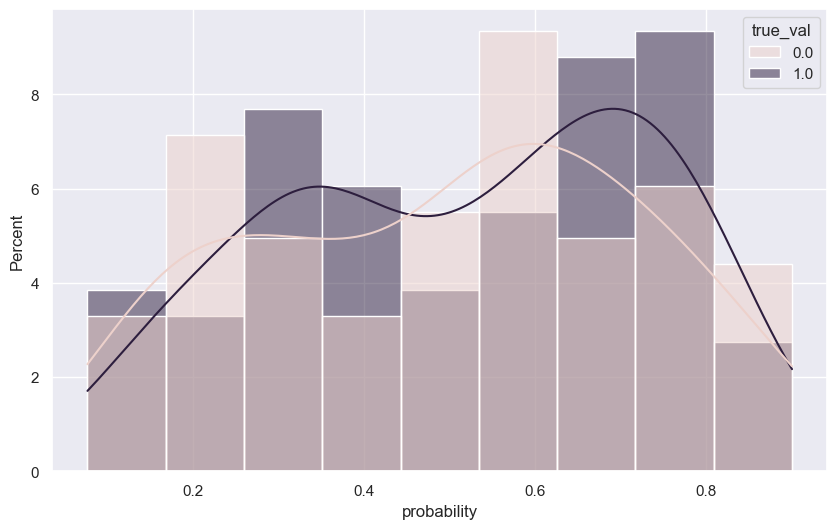

In [38]:
p_clf = pd.DataFrame(HistGB_pipe.predict_proba(X_test_equil)[:,1],columns=['probability'])
p_clf['true_val'] = y_test_equil
sns.histplot(data=p_clf, x = 'probability',hue='true_val', kde=True, stat= 'percent');

### <a name="C336"><font color='green'>III.3.6 lightGBM</font></a>

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 75.89%
La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: 69.16%
L'entrainement s'exécute en moyenne en : 7s


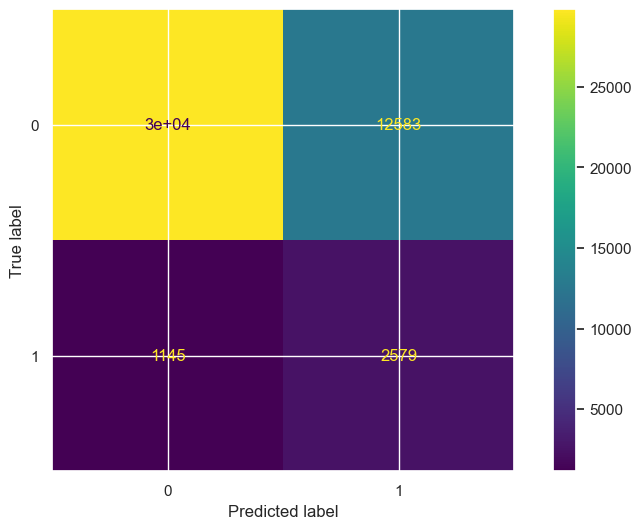

CPU times: total: 33.2 s
Wall time: 26.5 s


In [39]:
%%time

#lgbmc = LGBMClassifier(nthread=4,)

# Use the copy module of Python for deep copy operations
LGBM_pipe = deepcopy(intermediaire_pipeline)
LGBM_pipe.steps.append(['clf',lgbmc(scale_pos_weight = 11.3869)])

#Compute AUC score
score_auc['LightGBM'] = cross_validate(LGBM_pipe,X_train, y_train,cv = 5, n_jobs = 3, scoring = ['roc_auc','balanced_accuracy'])

# Score AUC
print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['LightGBM']['test_roc_auc'].mean(),4)))

# Score Balanced accuracy
print("La précision moyenne pondérée obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['LightGBM']['test_balanced_accuracy'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['LightGBM']['fit_time'].mean(),4)))

cm = confusion_matrix(y_test, LGBM_pipe.fit(X_train, y_train).predict(X_test), labels=LGBM_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LGBM_pipe.classes_)
disp.plot()
plt.show()

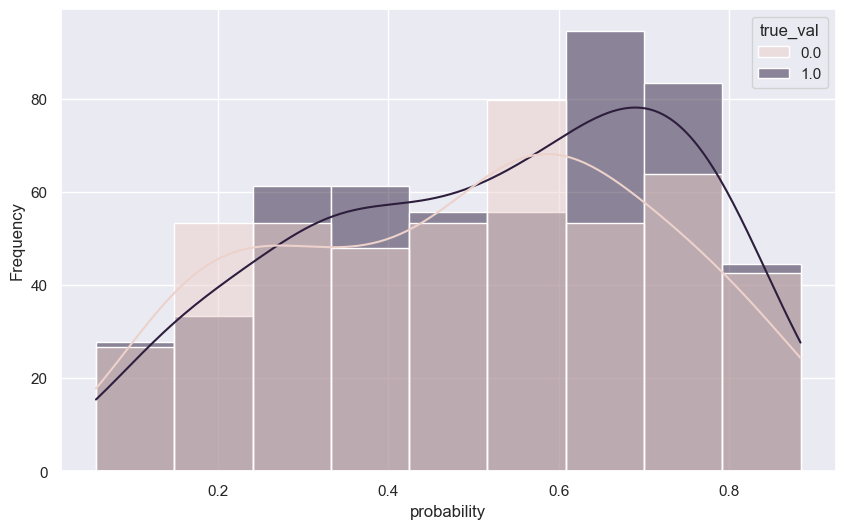

In [40]:
p_clf = pd.DataFrame(LGBM_pipe.predict_proba(X_test_equil)[:,1],columns=['probability'])
p_clf['true_val'] = y_test_equil
sns.histplot(data=p_clf, x = 'probability',hue='true_val', kde=True, stat= 'frequency');

### <a name="C337"><font color='green'>III.3.7 Fit modeles</font></a>

### <a name="C3371"><font color='green'>III.3.7.1 Fit modeles Raw</font></a>

In [41]:
%%time
train_test_valid_acc, train_test_valid_auc = dict(), dict()

for clf in [dummy_pipe,regLog_pipe,Ada_pipe,RF_pipe,HistGB_pipe,LGBM_pipe]:
    print("Entrainement du model:",clf.steps[-1][1].__class__.__name__, "en cours!")
    #clf.set_params(classifier__n_jobs=-1)
    clf.fit(X_train, y_train)
    print("Scores obtenus sur les datasets\n Train: {:.4%} | Validation : {:.4%} | Test : {:.4%}"\
          .format(roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]),
                  roc_auc_score(y_validation, clf.predict_proba(X_validation)[:, 1]),
                  roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
                 )
         )
    
    train_test_valid_auc[clf.steps[-1][1].__class__.__name__] = [
        roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]),
        roc_auc_score(y_validation, clf.predict_proba(X_validation)[:, 1]),
        roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])]
    
    train_test_valid_acc[clf.steps[-1][1].__class__.__name__] = [
        balanced_accuracy_score(y_train, clf.predict(X_train) ),
        balanced_accuracy_score(y_validation, clf.predict(X_validation) ),
        balanced_accuracy_score(y_test, clf.predict(X_test) )]
    print("\n")

Entrainement du model: DummyClassifier en cours!
Scores obtenus sur les datasets
 Train: 50.0000% | Validation : 50.0000% | Test : 50.0000%


Entrainement du model: LogisticRegression en cours!
Scores obtenus sur les datasets
 Train: 75.0940% | Validation : 75.2260% | Test : 74.8141%


Entrainement du model: AdaBoostClassifier en cours!
Scores obtenus sur les datasets
 Train: 75.0584% | Validation : 75.2947% | Test : 75.2552%


Entrainement du model: RandomForestClassifier en cours!
Scores obtenus sur les datasets
 Train: 100.0000% | Validation : 72.6647% | Test : 72.5616%


Entrainement du model: HistGradientBoostingClassifier en cours!
Scores obtenus sur les datasets
 Train: 80.1565% | Validation : 76.7507% | Test : 76.5035%


Entrainement du model: LGBMClassifier en cours!
Scores obtenus sur les datasets
 Train: 80.6350% | Validation : 76.7755% | Test : 76.4948%


CPU times: total: 9min 15s
Wall time: 3min 24s


### <a name="C34"><font color='green'>III.4 Selection des colonnes via Sequential Feature Selection LightGBMC</font></a>

In [42]:
LGBM_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impNumerical',
                                                                   SimpleImputer(strategy='median'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025720BD2550>),
                                                 ('disc',
                                                  Pipeline(steps=[('impDiscret',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_co...lector object at 0x0000025720BD2160>),
                                                 ('cat',
                                                  Pipeline(steps=[('impCat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025720BD2670>)])),
                ('model', StandardScaler()),
                ['clf', LGBMClassifier(scale_pos_weight=11.3869)]])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 236 out of 236 | elapsed:   46.9s finished

[2023-09-20 06:03:27] Features: 1/20 -- score: 0.6666459151694314[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 235 out of 235 | elapsed:  1.2min finished

[2023-09-20 06:04:40] Features: 2/20 -- score: 0.7106996767085744[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 234 out of 234 | elapsed:  1.2min finished

[2023-09-20 06:05:50] Features: 3/20 -- score: 0.73

Selected Features: ('num__AMT_CREDIT', 'num__DAYS_EMPLOYED', 'num__OWN_CAR_AGE', 'num__EXT_SOURCE_1', 'num__EXT_SOURCE_2', 'num__EXT_SOURCE_3', 'num__PERC_CREDIT_GOODS_PRICE', 'num__PAYMENT_RATE', 'disc__CODE_GENDER', 'disc__DAYS_BIRTH', 'disc__FLAG_MOBIL', 'disc__FLAG_WORK_PHONE', 'disc__FLAG_CONT_MOBILE', 'disc__FLAG_DOCUMENT_2', 'disc__FLAG_DOCUMENT_11', 'cat__NAME_EDUCATION_TYPE_Higher education', 'cat__OCCUPATION_TYPE_HR staff', 'cat__OCCUPATION_TYPE_Medicine staff', 'cat__ORGANIZATION_TYPE_Industry: type 10', 'cat__EMERGENCYSTATE_MODE_Yes')
acc_balanced: 0.7569370229348484


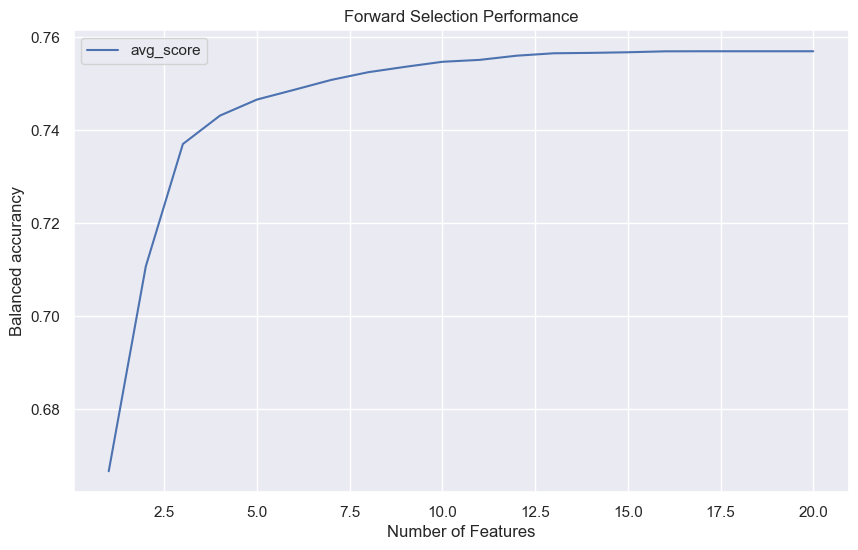

CPU times: total: 39.9 s
Wall time: 35min 47s


In [43]:
%%time

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
sfs_mlxtend = SFS( lgbmc(scale_pos_weight = 11.3869) ,
                  k_features=20,
                  forward=True,
                  floating=False,
                  scoring='roc_auc',
                  cv=3, 
                  verbose=2, 
                  n_jobs=-1)

sfs_mlxtend.fit(
    pd.DataFrame(LGBM_pipe[:-1].fit_transform(X_train), columns = LGBM_pipe[:-1].get_feature_names_out() ), 
    y_train)

# Print the selected features
print("Selected Features:", sfs_mlxtend.k_feature_names_)

# Evaluate the performance of the selected features on the testing set
score = sfs_mlxtend.k_score_
print("acc_balanced:", score)

# Plot the performance of the model with different feature subsets
sfs_df = pd.DataFrame.from_dict(sfs_mlxtend.get_metric_dict()).T
sfs_df["avg_score"] = sfs_df["avg_score"].astype(float)
fig, ax = plt.subplots()
sfs_df.plot(kind="line", y="avg_score", ax=ax)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Balanced accurancy")
ax.set_title("Forward Selection Performance")
plt.show()

In [44]:
sfs_mlxtend.subsets_[17]['avg_score']-sfs_mlxtend.subsets_[16]['avg_score']

1.7688049829600594e-05

In [48]:
sfs_mlxtend.subsets_[16]['avg_score']

0.7569193348850188

In [49]:
sfs_mlxtend.subsets_[17]['avg_score']

0.7569370229348484

In [50]:
sfs_mlxtend.subsets_[18]['avg_score']

0.7569370229348484

Le score auc moyen n'évolu pls après l'ajout de la 17 variables.

### <a name="C35"><font color='green'>III.5 ajout Filtre colonne dans pipeline</font></a>

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnRemainderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        """
        Initialise l'instance du transformateur.

        :param columns: Liste des noms de colonnes à supprimer
        :type columns: list
        """
        self.columns = columns
        self.original_columns = None        

    def fit(self, X, y=None, original_columns = None):
        """
        Cette méthode ne fait rien, elle est incluse pour la compatibilité avec les pipelines.

        :param X: DataFrame d'entrée
        :type X: pd.DataFrame
        :param y: Ignoré, peut être laissé à None
        :type y: None
        :return: L'instance du transformateur
        :rtype: ColumnDropperTransformer
        """
        # Si X est une matrice NumPy, nous ne pouvons pas accéder aux noms des colonnes d'origine,
        # nous allons donc stocker la liste des colonnes à supprimer et supposer que les colonnes
        # sont dans le même ordre que dans les données d'origine.
        self.original_columns = original_columns
        return self

    def transform(self, X):
        if isinstance(X, np.ndarray):
            X_copy = X.copy()
            X_copy = pd.DataFrame(X_copy, columns = self.original_columns )
            
        #missing_columns = set(self.columns) - set(self.original_columns)
        #if missing_columns:
        #    raise ValueError(f"Les colonnes suivantes sont manquantes dans le DataFrame : {missing_columns}")
                    
        elif isinstance(X, pd.DataFrame):
            X_copy = X.copy()
        
        X_copy = X_copy[self.columns]
        return X_copy
    
    def get_feature_names_out(self, input_features=None):
        if self.original_columns is None:
            raise ValueError("Les noms de colonnes d'origine ne sont pas disponibles.")

        output_features = [col for col in self.columns]
        return output_features
    

In [51]:
%%time
HistGB_pipe_filtered = deepcopy(HistGB_pipe)
HistGB_pipe_filtered.steps.insert(2, 
                                ['remain_feature',
                                 ColumnRemainderTransformer(list(sfs_mlxtend.subsets_[17]['feature_names']) )
                                ])

HistGB_pipe_filtered.fit(X_train,
                       y=y_train, 
                       remain_feature__original_columns = LGBM_pipe[:2].get_feature_names_out())

CPU times: total: 19.6 s
Wall time: 5.11 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impNumerical',
                                                                   SimpleImputer(strategy='median'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000257361B1FA0>),
                                                 ('disc',
                                                  Pipeline(steps=[('impDiscret',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_co...
                                                     'num__PAYMENT_RATE',
                                                     'disc__CODE_GENDER',
                                                     'disc__DAYS_BIRTH',
                                                     'disc__FLAG_WORK_PHONE',
                                                     'disc__FLAG_DOCUMENT_11',
                                                     'cat__NAME_EDUCATION_TYPE_Higher '
                                                     'education',
                                                     'cat__OCCUPATION_TYPE_HR '
                                                     'staff',
                                                     'cat__OCCUPATION_TYPE_Medicine '
                                                     'staff',
                                                     'cat__ORGANIZATION_TYPE_Industry: '
                                                     'type 10',
                                                     'cat__EMERGENCYSTATE_MODE_Yes'])),
                ['clf',
                 HistGradientBoostingClassifier(class_weight='balanced')]])

In [52]:
len(HistGB_pipe_filtered[:3].get_feature_names_out() )

17

In [53]:
HistGB_pipe_filtered[:3].get_feature_names_out()

['num__AMT_CREDIT',
 'num__DAYS_EMPLOYED',
 'num__OWN_CAR_AGE',
 'num__EXT_SOURCE_1',
 'num__EXT_SOURCE_2',
 'num__EXT_SOURCE_3',
 'num__PERC_CREDIT_GOODS_PRICE',
 'num__PAYMENT_RATE',
 'disc__CODE_GENDER',
 'disc__DAYS_BIRTH',
 'disc__FLAG_WORK_PHONE',
 'disc__FLAG_DOCUMENT_11',
 'cat__NAME_EDUCATION_TYPE_Higher education',
 'cat__OCCUPATION_TYPE_HR staff',
 'cat__OCCUPATION_TYPE_Medicine staff',
 'cat__ORGANIZATION_TYPE_Industry: type 10',
 'cat__EMERGENCYSTATE_MODE_Yes']

### <a name="C36"><font color='green'>III.6 Recherche des meilleurs parametres pour le modele</font></a>

In [54]:
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV

In [55]:
%%time
X_search_param_train = HistGB_pipe_filtered[:-1].transform(X_train)

params ={
    'learning_rate': [0.05, 0.02],
    'max_iter' : [500,800],
    'max_leaf_nodes' : [10,5,15],
    'max_depth': [3, 2,4],
    'l2_regularization' : [0,3],
    #'clf__max_bins' : [255,511],
    'categorical_features' : [['cat__NAME_EDUCATION_TYPE_Higher education','cat__OCCUPATION_TYPE_HR staff',
                                    'cat__OCCUPATION_TYPE_Medicine staff', 'cat__ORGANIZATION_TYPE_Industry: type 10', 
                                    'cat__EMERGENCYSTATE_MODE_Yes'],
                                   None],
    'verbose' : [0], 
                          }
    
halving_search = HalvingGridSearchCV(
    estimator  = HistGB_pipe_filtered[-1], 
    param_grid = params, 
    scoring    ='roc_auc',
    resource   = 'n_samples',
    min_resources = 20000,
    max_resources = 100000,#'auto',
    cv    =3,
    refit =True,
    random_state=0,
    verbose=1,
    error_score='raise')

halving_search.fit( X = X_search_param_train, y = y_train )

del X_search_param_train

n_iterations: 2
n_required_iterations: 5
n_possible_iterations: 2
min_resources_: 20000
max_resources_: 100000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 144
n_resources: 20000
Fitting 3 folds for each of 144 candidates, totalling 432 fits
----------
iter: 1
n_candidates: 48
n_resources: 60000
Fitting 3 folds for each of 48 candidates, totalling 144 fits
CPU times: total: 1h 14s
Wall time: 5min 9s


In [56]:
halving_search.best_params_ , halving_search.best_score_

({'categorical_features': None,
  'l2_regularization': 3,
  'learning_rate': 0.05,
  'max_depth': 2,
  'max_iter': 500,
  'max_leaf_nodes': 15,
  'verbose': 0},
 0.7473153411285476)

In [57]:
### refit with best param
HistGB_pipe_filtered[-1].categorical_features = None
HistGB_pipe_filtered[-1].l2_regularization = 3
HistGB_pipe_filtered[-1].learning_rate = 0.05
HistGB_pipe_filtered[-1].max_depth = 3
HistGB_pipe_filtered[-1].max_iter = 500
HistGB_pipe_filtered[-1].max_leaf_nodes = 10

HistGB_pipe_filtered.fit(X_train,
                       y=y_train, 
                       remain_feature__original_columns = LGBM_pipe[:2].get_feature_names_out())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impNumerical',
                                                                   SimpleImputer(strategy='median'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000257361B1FA0>),
                                                 ('disc',
                                                  Pipeline(steps=[('impDiscret',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_co...
                                                     'disc__FLAG_DOCUMENT_11',
                                                     'cat__NAME_EDUCATION_TYPE_Higher '
                                                     'education',
                                                     'cat__OCCUPATION_TYPE_HR '
                                                     'staff',
                                                     'cat__OCCUPATION_TYPE_Medicine '
                                                     'staff',
                                                     'cat__ORGANIZATION_TYPE_Industry: '
                                                     'type 10',
                                                     'cat__EMERGENCYSTATE_MODE_Yes'])),
                ['clf',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                l2_regularization=3,
                                                learning_rate=0.05, max_depth=3,
                                                max_iter=500,
                                                max_leaf_nodes=10)]])

</Br>

</Br>

### <a name="C37"><font color='green'>III.7 Données déséquilibrées</font></a>

In [58]:
def print_score(model, y_train,y_test,y_validation, X_train, X_test, X_validation ):
    print("Scores auc obtenus sur les datasets\n Train: {:.4%} | Validation : {:.4%} | Test : {:.4%}"\
      .format(roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
              roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
              roc_auc_score(y_validation, model.predict_proba(X_validation)[:, 1])
             )
     )

    print("Scores balanced accuracy obtenus sur les datasets\n Train: {:.4%} | Validation : {:.4%} | Test : {:.4%}"\
          .format(balanced_accuracy_score(y_train, model.predict(X_train) ),
                  balanced_accuracy_score(y_test, model.predict(X_test) ),
                  balanced_accuracy_score(y_validation, model.predict(X_validation) )
                 )
         )
    
    print("Scores f1 obtenus sur les datasets\n Train: {:.4%} | Validation : {:.4%} | Test : {:.4%}"\
          .format(f1_score(y_train, model.predict(X_train) ),
                  f1_score(y_test, model.predict(X_test) ),
                  f1_score(y_validation, model.predict(X_validation) )
                 )
         )

In [59]:
# pipeline data transformation imblearn
from imblearn.over_sampling import SMOTENC, SMOTE
from imblearn.pipeline import Pipeline as Pipeline_imb  # Importation de Pipeline depuis imblearn

In [60]:
%%time
from sklearn.compose import ColumnTransformer , make_column_selector
from sklearn.preprocessing import FunctionTransformer

# selector feature
selected_features = ['AMT_CREDIT','DAYS_EMPLOYED', 'OWN_CAR_AGE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
                     'EXT_SOURCE_3', 'PERC_CREDIT_GOODS_PRICE', 'PAYMENT_RATE','CODE_GENDER', 
                     'DAYS_BIRTH', 'FLAG_WORK_PHONE', 'FLAG_DOCUMENT_11', 'NAME_EDUCATION_TYPE', 
                     'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'EMERGENCYSTATE_MODE']

pref_selected_features = ['num__AMT_CREDIT','num__DAYS_EMPLOYED', 'num__OWN_CAR_AGE', 'num__EXT_SOURCE_1', 'num__EXT_SOURCE_2',
                         'num__EXT_SOURCE_3', 'num__PERC_CREDIT_GOODS_PRICE', 'num__PAYMENT_RATE','num__CODE_GENDER', 
                         'num__DAYS_BIRTH', 'num__FLAG_WORK_PHONE', 'num__FLAG_DOCUMENT_11', 'cat__NAME_EDUCATION_TYPE', 
                         'cat__OCCUPATION_TYPE', 'cat__ORGANIZATION_TYPE', 'cat__EMERGENCYSTATE_MODE']

idx_selected_features = [i for i,x in enumerate(X_train.columns) if 'cat__'+x in pref_selected_features ]

# tranform les colonnes categorielles en object
transformer = FunctionTransformer(lambda x:x.astype("object"))


#Numerical featues
numeric_features = make_column_selector(dtype_include=np.number)
numeric_transformer = Pipeline_imb(
    steps=[("numScal",  StandardScaler()),
          ('impNumerical', SimpleImputer(strategy="median"))]
)

# categorials features
categorical_features = make_column_selector(dtype_include="object")
categorical_transformer = Pipeline_imb(
    steps=[
        ('impCat', SimpleImputer(strategy = 'most_frequent')),
        ("ohe",OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)),
        #("CatFeature_ToObj",transformer)
    ])

# columntransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num",  numeric_transformer, numeric_features),
        ("cat",  categorical_transformer, categorical_features),
    ])

### Pipeline
HistGB_pipe_filtered_smote = Pipeline_imb(
    steps=[
        ("feature_selector", ColumnRemainderTransformer( selected_features )  ),
        ("preprocessor", preprocessor),
        ("smote",SMOTE( )), #idx_selected_features)),
        ("clf",HistGradientBoostingClassifier(class_weight = 'balanced',
                                              #categorical_features = [12,13,14,15],
                                              l2_regularization = 3,learning_rate = 0.05,
                                              max_depth = 3,max_iter = 500,max_leaf_nodes = 10,)
        )
    ]
)

HistGB_pipe_filtered_smote.fit(X_train,
                               y=y_train, 
                               feature_selector__original_columns =  X_train.columns 
                              )

CPU times: total: 2min 50s
Wall time: 16.4 s


Pipeline(steps=[('feature_selector',
                 ColumnRemainderTransformer(columns=['AMT_CREDIT',
                                                     'DAYS_EMPLOYED',
                                                     'OWN_CAR_AGE',
                                                     'EXT_SOURCE_1',
                                                     'EXT_SOURCE_2',
                                                     'EXT_SOURCE_3',
                                                     'PERC_CREDIT_GOODS_PRICE',
                                                     'PAYMENT_RATE',
                                                     'CODE_GENDER',
                                                     'DAYS_BIRTH',
                                                     'FLAG_WORK_PHONE',
                                                     'FLAG_DOCUMENT_11',
                                                     'NAME_EDUCATION_TYPE',
                                                     'OCCUPATION_TYPE',
                                                     'ORGANIZATION_TYPE',
                                                     'EMERGENCYSTATE_MODE'])),...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025734A4E430>)])),
                ('smote', SMOTE()),
                ('clf',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                l2_regularization=3,
                                                learning_rate=0.05, max_depth=3,
                                                max_iter=500,
                                                max_leaf_nodes=10))])

In [61]:
(roc_auc_score(y_train, HistGB_pipe_filtered_smote.predict_proba(X_train)[:,1] ),
 roc_auc_score(y_test, HistGB_pipe_filtered_smote.predict_proba(X_test)[:,1] ),
roc_auc_score(y_validation, HistGB_pipe_filtered_smote.predict_proba(X_validation)[:,1] ))

(0.7153317779270287, 0.7126096152416863, 0.7135789707743405)

In [62]:
params_smote ={
    'smote__sampling_strategy': [0.3,0.2,{0:y_train.sum(),1:y_train.sum()}],
    'smote__k_neighbors': [3,5,7],
}
    
halving_search_smote = HalvingGridSearchCV(
    estimator  = HistGB_pipe_filtered_smote, 
    param_grid = params_smote, 
    scoring    ='roc_auc',
    resource   = 'n_samples',
    min_resources = 20000,
    max_resources = 100000,#'auto',
    cv    =3,
    refit =True,
    random_state=0,
    verbose=1,
    error_score='raise')

halving_search_smote.fit( X = X_train, y = y_train )

n_iterations: 2
n_required_iterations: 3
n_possible_iterations: 2
min_resources_: 20000
max_resources_: 100000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 20000
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 1
n_candidates: 3
n_resources: 60000
Fitting 3 folds for each of 3 candidates, totalling 9 fits


HalvingGridSearchCV(cv=3, error_score='raise',
                    estimator=Pipeline(steps=[('feature_selector',
                                               ColumnRemainderTransformer(columns=['AMT_CREDIT',
                                                                                   'DAYS_EMPLOYED',
                                                                                   'OWN_CAR_AGE',
                                                                                   'EXT_SOURCE_1',
                                                                                   'EXT_SOURCE_2',
                                                                                   'EXT_SOURCE_3',
                                                                                   'PERC_CREDIT_GOODS_PRICE',
                                                                                   'PAYMENT_RATE',
                                                                                   'CODE_GENDER',
                                                                                   'DAYS_BIRTH',
                                                                                   'FLAG_WORK_PHONE',
                                                                                   'FLAG_DOCUMENT_11',
                                                                                   'NAME_EDUCATION_TYPE',
                                                                                   'OCCUPAT...
                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x0000025734A4E430>)])),
                                              ('smote', SMOTE()),
                                              ('clf',
                                               HistGradientBoostingClassifier(class_weight='balanced',
                                                                              l2_regularization=3,
                                                                              learning_rate=0.05,
                                                                              max_depth=3,
                                                                              max_iter=500,
                                                                              max_leaf_nodes=10))]),
                    max_resources=100000, min_resources=20000,
                    param_grid={'smote__k_neighbors': [3, 5, 7],
                                'smote__sampling_strategy': [0.3, 0.2,
                                                             {0: 17377,
                                                              1: 17377}]},
                    random_state=0, scoring='roc_auc', verbose=1)

In [63]:
halving_search_smote.best_params_

{'smote__k_neighbors': 7, 'smote__sampling_strategy': 0.2}

In [74]:
### refit with best param
HistGB_pipe_filtered_smote[-2].k_neighbors = 7
HistGB_pipe_filtered_smote[-2].sampling_strategy = 0.2


HistGB_pipe_filtered_smote.fit(X_train,
                       y=y_train, 
                       feature_selector__original_columns =  X_train.columns )

Pipeline(steps=[('feature_selector',
                 ColumnRemainderTransformer(columns=['AMT_CREDIT',
                                                     'DAYS_EMPLOYED',
                                                     'OWN_CAR_AGE',
                                                     'EXT_SOURCE_1',
                                                     'EXT_SOURCE_2',
                                                     'EXT_SOURCE_3',
                                                     'PERC_CREDIT_GOODS_PRICE',
                                                     'PAYMENT_RATE',
                                                     'CODE_GENDER',
                                                     'DAYS_BIRTH',
                                                     'FLAG_WORK_PHONE',
                                                     'FLAG_DOCUMENT_11',
                                                     'NAME_EDUCATION_TYPE',
                                                     'OCCUPATION_TYPE',
                                                     'ORGANIZATION_TYPE',
                                                     'EMERGENCYSTATE_MODE'])),...
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025734A4E430>)])),
                ('smote', SMOTE(k_neighbors=7, sampling_strategy=0.2)),
                ('clf',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                l2_regularization=3,
                                                learning_rate=0.05, max_depth=3,
                                                max_iter=500,
                                                max_leaf_nodes=10))])

In [64]:
print("Meilleur score AUC sans resampling SMOTE est {0:.2%}, et le meilleur score obtenu avec un resampling smote est {1:.2%}".format(halving_search.best_score_, halving_search_smote.best_score_) )

Meilleur score AUC sans resampling SMOTE est 74.73%, et le meilleur score obtenu avec un resampling smote est 73.55%


In [65]:
print_score(HistGB_pipe, y_train,y_test,y_validation, X_train, X_test, X_validation )

Scores auc obtenus sur les datasets
 Train: 80.1565% | Validation : 76.5035% | Test : 76.7507%
Scores balanced accuracy obtenus sur les datasets
 Train: 72.3558% | Validation : 69.6754% | Test : 70.2651%
Scores f1 obtenus sur les datasets
 Train: 29.5127% | Validation : 27.5061% | Test : 27.9390%


In [66]:
print_score(HistGB_pipe_filtered, y_train,y_test,y_validation, X_train, X_test, X_validation )

Scores auc obtenus sur les datasets
 Train: 77.1708% | Validation : 76.4432% | Test : 76.2385%
Scores balanced accuracy obtenus sur les datasets
 Train: 70.0252% | Validation : 69.2766% | Test : 69.4711%
Scores f1 obtenus sur les datasets
 Train: 27.3479% | Validation : 26.8132% | Test : 26.9613%


In [75]:
print_score(HistGB_pipe_filtered_smote, y_train,y_test,y_validation, X_train, X_test, X_validation )

Scores auc obtenus sur les datasets
 Train: 75.0081% | Validation : 74.5480% | Test : 74.4107%
Scores balanced accuracy obtenus sur les datasets
 Train: 67.5912% | Validation : 67.6492% | Test : 67.6806%
Scores f1 obtenus sur les datasets
 Train: 27.7085% | Validation : 27.7039% | Test : 27.7413%


## regression Logistique SMOTE

### a) regression Logistique colonnes selectionnées

In [68]:
%%time
regLog_pipe_filtered = deepcopy(regLog_pipe)
regLog_pipe_filtered.steps.insert(2, 
                                ['remain_feature',
                                 ColumnRemainderTransformer(list(sfs_mlxtend.subsets_[17]['feature_names']) )
                                ])

regLog_pipe_filtered.fit(X_train,
                       y=y_train, 
                       remain_feature__original_columns = LGBM_pipe[:2].get_feature_names_out())

CPU times: total: 4.41 s
Wall time: 3.71 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impNumerical',
                                                                   SimpleImputer(strategy='median'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000257225DF430>),
                                                 ('disc',
                                                  Pipeline(steps=[('impDiscret',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_co...
                                                     'num__PAYMENT_RATE',
                                                     'disc__CODE_GENDER',
                                                     'disc__DAYS_BIRTH',
                                                     'disc__FLAG_WORK_PHONE',
                                                     'disc__FLAG_DOCUMENT_11',
                                                     'cat__NAME_EDUCATION_TYPE_Higher '
                                                     'education',
                                                     'cat__OCCUPATION_TYPE_HR '
                                                     'staff',
                                                     'cat__OCCUPATION_TYPE_Medicine '
                                                     'staff',
                                                     'cat__ORGANIZATION_TYPE_Industry: '
                                                     'type 10',
                                                     'cat__EMERGENCYSTATE_MODE_Yes'])),
                ['clf', LogisticRegression(class_weight='balanced')]])

### b) regression Logistique colonnes selectionnées et ré-echantillonées

In [69]:
### Pipeline
regLog_pipe_filtered_smote = Pipeline_imb(
    steps=[
        ("feature_selector", ColumnRemainderTransformer( selected_features )  ),
        ("preprocessor", preprocessor),
        ("smote",SMOTE( )), #idx_selected_features)),
        ("clf",LogisticRegression(class_weight = 'balanced',)
        )
    ]
)

regLog_pipe_filtered_smote.fit(X_train,
                               y=y_train, 
                               feature_selector__original_columns =  X_train.columns 
                              )

Pipeline(steps=[('feature_selector',
                 ColumnRemainderTransformer(columns=['AMT_CREDIT',
                                                     'DAYS_EMPLOYED',
                                                     'OWN_CAR_AGE',
                                                     'EXT_SOURCE_1',
                                                     'EXT_SOURCE_2',
                                                     'EXT_SOURCE_3',
                                                     'PERC_CREDIT_GOODS_PRICE',
                                                     'PAYMENT_RATE',
                                                     'CODE_GENDER',
                                                     'DAYS_BIRTH',
                                                     'FLAG_WORK_PHONE',
                                                     'FLAG_DOCUMENT_11',
                                                     'NAME_EDUCATION_TYPE',
                                                     'OCCUPATION_TYPE',
                                                     'ORGANIZATION_TYPE',
                                                     'EMERGENCYSTATE_MODE'])),...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025734A4E790>),
                                                 ('cat',
                                                  Pipeline(steps=[('impCat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025734A4E430>)])),
                ('smote', SMOTE()),
                ('clf', LogisticRegression(class_weight='balanced'))])

In [70]:
print_score(regLog_pipe, y_train,y_test,y_validation, X_train, X_test, X_validation )

Scores auc obtenus sur les datasets
 Train: 75.0940% | Validation : 74.8141% | Test : 75.2260%
Scores balanced accuracy obtenus sur les datasets
 Train: 68.5414% | Validation : 68.1565% | Test : 69.1456%
Scores f1 obtenus sur les datasets
 Train: 26.1402% | Validation : 25.7876% | Test : 26.4912%


In [71]:
print_score(regLog_pipe_filtered, y_train,y_test,y_validation, X_train, X_test, X_validation )

Scores auc obtenus sur les datasets
 Train: 73.4082% | Validation : 73.7770% | Test : 73.6734%
Scores balanced accuracy obtenus sur les datasets
 Train: 67.1950% | Validation : 67.2613% | Test : 67.5562%
Scores f1 obtenus sur les datasets
 Train: 25.0935% | Validation : 25.1248% | Test : 25.3603%


In [72]:
print_score(regLog_pipe_filtered_smote, y_train,y_test,y_validation, X_train, X_test, X_validation )

Scores auc obtenus sur les datasets
 Train: 73.4005% | Validation : 73.6313% | Test : 73.7167%
Scores balanced accuracy obtenus sur les datasets
 Train: 67.3107% | Validation : 67.4073% | Test : 67.9745%
Scores f1 obtenus sur les datasets
 Train: 25.2433% | Validation : 25.3018% | Test : 25.7053%


<Br>

<Br>

### <a name="C38"><font color='green'>III.8 Optimisation seuil</font></a>

metrique à minimiser 10FN + FP -0.08TN

In [291]:
def searchBestThreshold(proba,true_y):
    best_cout = 1000 * len(true_y)
    res = pd.DataFrame({'proba':proba,'true_y':true_y}).sort_values(by = 'proba', ascending = True)
    for seuil in res.proba.unique():
    #for seuil in range(0,10000,1):
    #    seuil /= 10000
        res['decision_seuil'] = 0
        res.loc[res.proba > seuil , 'decision_seuil'] = 1 
        
        TN, FP, FN, TP = confusion_matrix(true_y, res['decision_seuil'].values).ravel()
        
        #Calcul du cout
        cout = 10*FN + FP - 1*TN -1*TP
        
        #Minisation du coût
        if best_cout > cout:
            best_seuil = seuil
            best_cout = cout
                
    return best_seuil, best_cout  

In [292]:
def compute_metric_cm(proba,true_y):
    seuil_list, TN_list, FP_list, FN_list, TP_list = list(),list(),list(),list(),list()
    res = pd.DataFrame({'proba':proba,'true_y':true_y}).sort_values(by = 'proba', ascending = True)
    for seuil in res.proba.unique():
        res['decision_seuil'] = 0
        res.loc[res.proba > seuil , 'decision_seuil'] = 1 
        
        TN, FP, FN, TP = confusion_matrix(true_y, res['decision_seuil'].values).ravel()
        
        seuil_list.append(seuil)
        TN_list.append(TN)
        FP_list.append(FP)
        FN_list.append(FN)
        TP_list.append(TP)
    resultat = pd.DataFrame({'seuil':seuil_list, 'TN':TN_list, 'FP':FP_list, 'FN':FN_list, 'TP':TP_list}) 
    return resultat

In [203]:
from sklearn.metrics import ConfusionMatrixDisplay
def ComparareResultatSeuil(model, X, y_true, seuil = 0.2):
    cm_pred = confusion_matrix( y_true, [1 if p>=seuil else 0 for p in model.predict_proba(X)[:,1]>seuil],labels=model.classes_)
    cm_05 = confusion_matrix( y_true, model.predict(X) , labels=model.classes_)
    
    fig, ax =plt.subplots(1,2,figsize=(10,6), dpi=100,sharey=True)
    
    display = ConfusionMatrixDisplay(cm_pred, display_labels=model.classes_)
    display05 = ConfusionMatrixDisplay(cm_05, display_labels=model.classes_)
    
    # set the plot title using the axes object
    ax[0].set(title='Confusion Matrix for the default Risk seuil 0.5')
    ax[1].set(title='Confusion Matrix for the default Risk seuil {0}'.format(seuil))

    # show the plot. 
    # Pass the parameter ax to show customizations (ex. title) 
    display05.plot(ax=ax[0],colorbar=False)
    display.plot(ax=ax[1],colorbar=False)
    plt.show();

#### Dummy estimator

In [293]:
searchBestThreshold( dummy_pipe.predict_proba(X_test)[:,1],y_test.values)

(0.0, -5162)

In [294]:
compute_metric_cm(dummy_pipe.predict_proba(X_test)[:,1],y_test.values)

,seuil,TN,FP,FN,TP
0,0.0,42402,0,3724,0


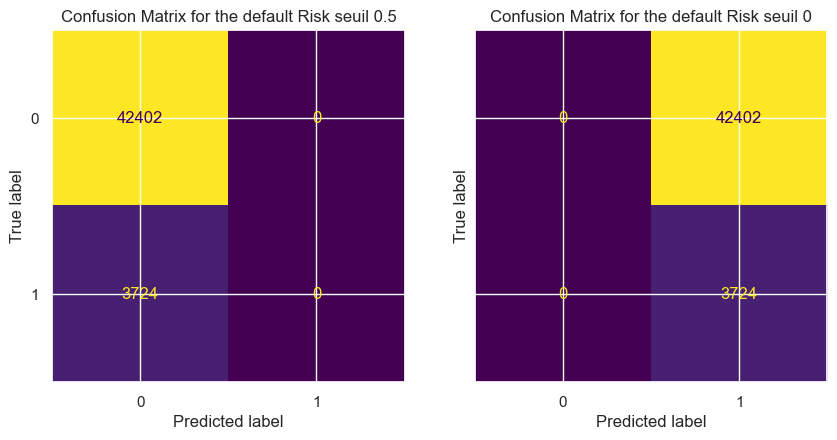

In [295]:
ComparareResultatSeuil(dummy_pipe, X_test, y_test.values, seuil = 0)

<Br>

<Br>

#### Logistic Regression estimator

In [206]:
%%time
searchBestThreshold( regLog_pipe.predict_proba(X_test)[:,1],y_test.values)

(0.9927492857258704, -5160)

In [297]:
%%time
reultatmetricsrLog = compute_metric_cm(regLog_pipe.predict_proba(X_test )[:,1],y_test.values)
reultatmetricsrLog.loc[abs((reultatmetricsrLog.FN * 10) - reultatmetricsrLog.FP)<10]

CPU times: total: 2min 36s
Wall time: 2min 36s


,seuil,TN,FP,FN,TP
24658,0.419488,22688,19714,1971,1753
24659,0.419491,22689,19713,1971,1753
24660,0.419509,22689,19713,1972,1752
24661,0.419525,22690,19712,1972,1752
24662,0.419534,22691,19711,1972,1752


<Axes: xlabel='seuil'>

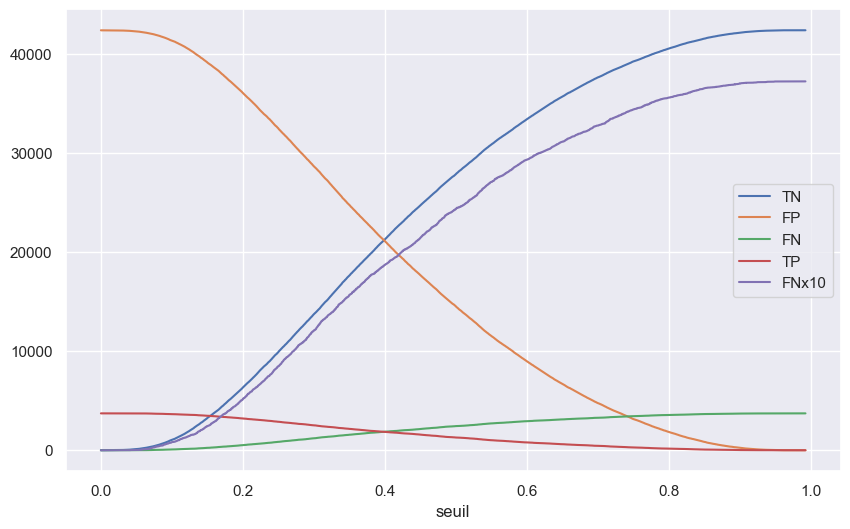

In [221]:
reultatmetricsrLog['FNx10'] = reultatmetricsrLog.FN*10
reultatmetricsrLog.plot(x = 'seuil');

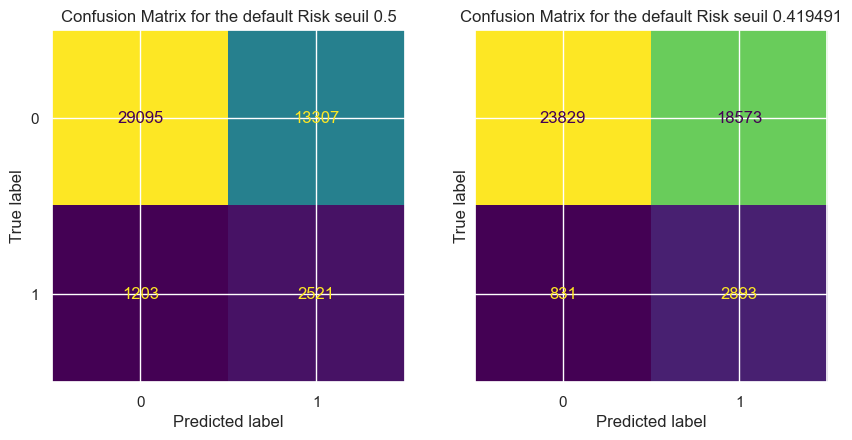

In [298]:
ComparareResultatSeuil( regLog_pipe, X_test, y_test.values, seuil = 0.419491 )

<Br>

<Br>

CPU times: total: 2min 24s
Wall time: 2min 25s


<Axes: xlabel='seuil'>

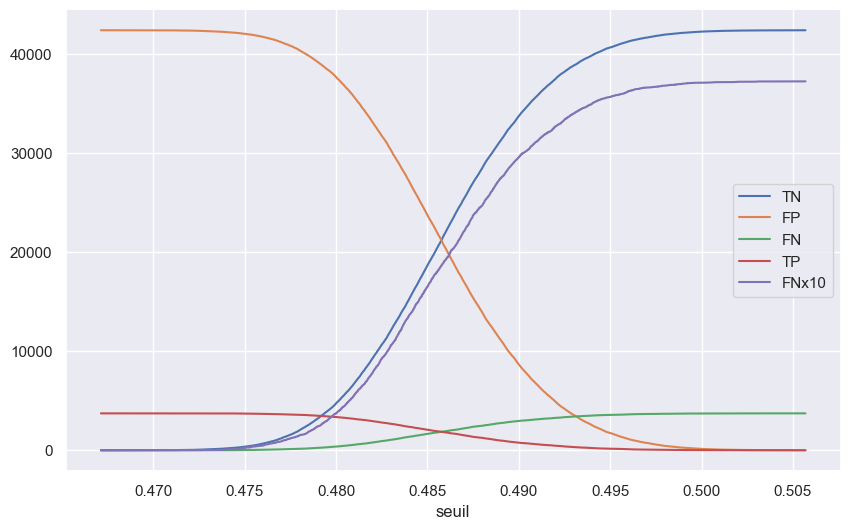

In [299]:
%%time
reultatmetricsAdab = compute_metric_cm(Ada_pipe.predict_proba(X_test )[:,1],y_test.values)
reultatmetricsAdab['FNx10'] = reultatmetricsAdab.FN*10
reultatmetricsAdab.plot(x = 'seuil');

In [300]:
reultatmetricsAdab.loc[abs(reultatmetricsAdab.FNx10 - reultatmetricsAdab.FP)<10]

,seuil,TN,FP,FN,TP,FNx10
22519,0.486183,22688,19714,1971,1753,19710
22520,0.486183,22689,19713,1971,1753,19710
22521,0.486183,22689,19713,1972,1752,19720
22522,0.486183,22690,19712,1972,1752,19720
22523,0.486183,22691,19711,1972,1752,19720


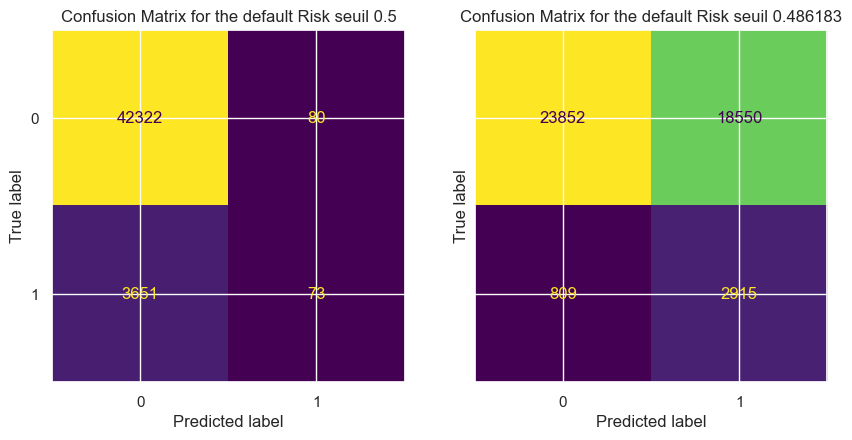

In [260]:
ComparareResultatSeuil(Ada_pipe, X_test, y_test.values, seuil = 0.486183)

<Br>

<Br>

CPU times: total: 1.97 s
Wall time: 693 ms


<Axes: xlabel='seuil'>

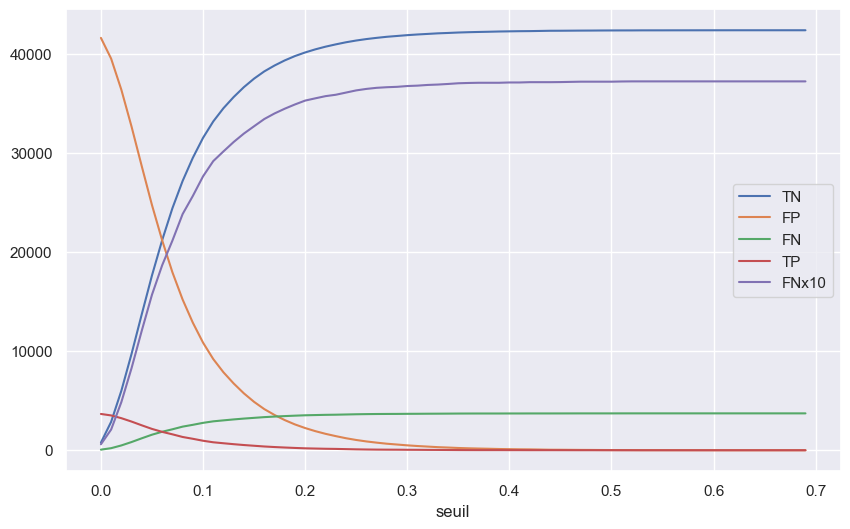

In [301]:
%%time
reultatmetricsRF = compute_metric_cm(RF_pipe.predict_proba(X_test )[:,1],y_test.values)
reultatmetricsRF['FNx10'] = reultatmetricsRF.FN*10
reultatmetricsRF.plot(x = 'seuil')

In [302]:
reultatmetricsRF.loc[abs(reultatmetricsRF.FNx10 - reultatmetricsRF.FP)<10000]

,seuil,TN,FP,FN,TP,FNx10
5,0.05,17648,24754,1570,2154,15700
6,0.06,21217,21185,1868,1856,18680
7,0.07,24430,17972,2116,1608,21160
8,0.08,27185,15217,2384,1340,23840


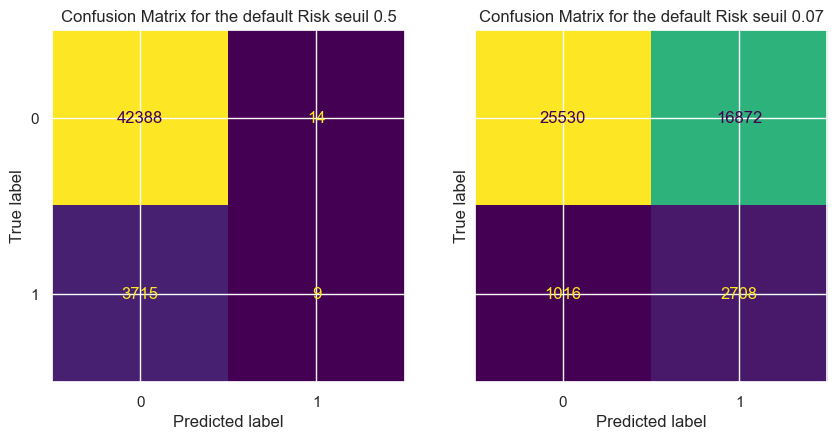

In [303]:
ComparareResultatSeuil( RF_pipe, X_test, y_test.values, seuil = 0.07)

<Br>

<Br>

CPU times: total: 2min 39s
Wall time: 2min 37s


<Axes: xlabel='seuil'>

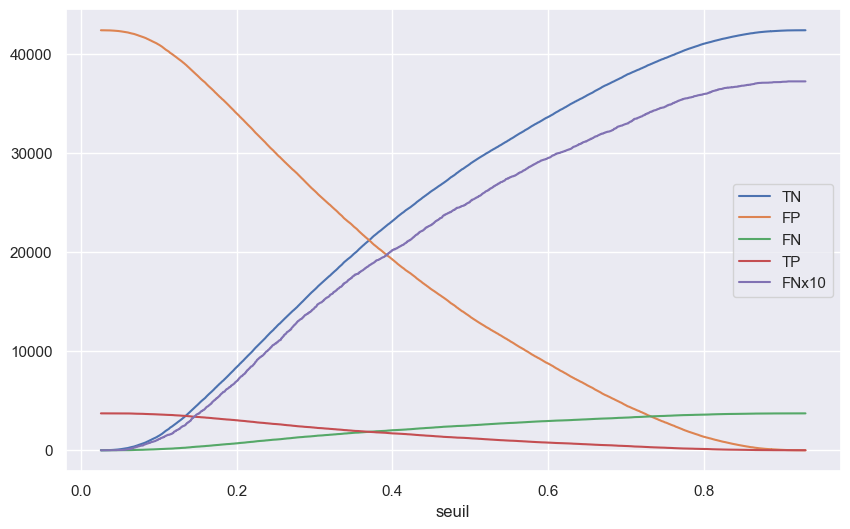

In [304]:
%%time
reultatmetricsHistGB = compute_metric_cm(HistGB_pipe.predict_proba(X_test )[:,1],y_test.values)
reultatmetricsHistGB['FNx10'] = reultatmetricsHistGB.FN*10
reultatmetricsHistGB.plot(x = 'seuil')

In [305]:
reultatmetricsHistGB.loc[abs(reultatmetricsHistGB.FNx10 - reultatmetricsHistGB.FP)<10]

,seuil,TN,FP,FN,TP,FNx10
24658,0.392726,22688,19714,1971,1753,19710
24659,0.392731,22689,19713,1971,1753,19710
24660,0.392732,22689,19713,1972,1752,19720
24661,0.392732,22690,19712,1972,1752,19720
24662,0.392734,22691,19711,1972,1752,19720


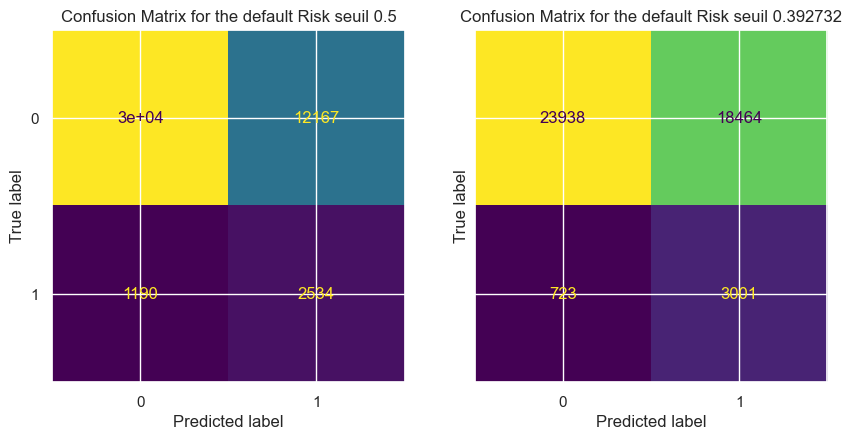

In [267]:
ComparareResultatSeuil( HistGB_pipe, X_test, y_test.values, seuil = 0.392732 )

<Br>

<Br>

CPU times: total: 2min 37s
Wall time: 2min 36s


<Axes: xlabel='seuil'>

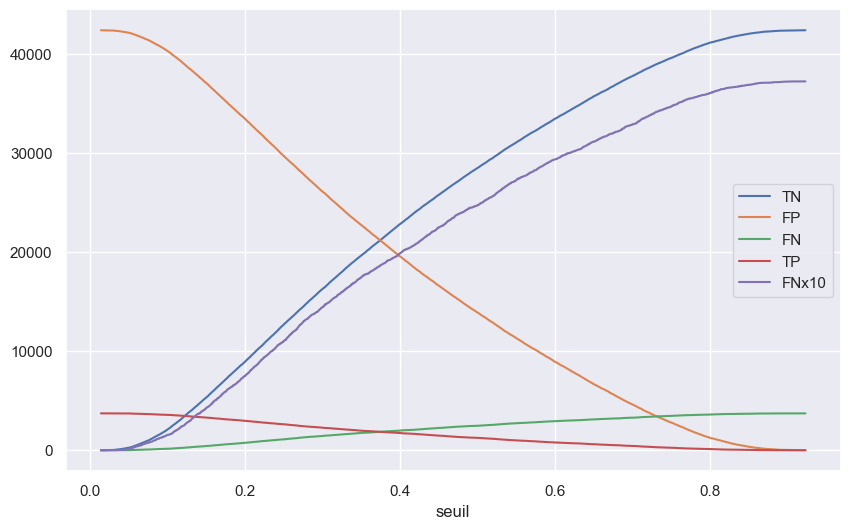

In [306]:
%%time
reultatmetricsLGBM = compute_metric_cm( LGBM_pipe.predict_proba(X_test )[:,1],y_test.values)
reultatmetricsLGBM['FNx10'] = reultatmetricsLGBM.FN*10
reultatmetricsLGBM.plot(x = 'seuil')

In [307]:
reultatmetricsLGBM.loc[abs(reultatmetricsLGBM.FNx10 - reultatmetricsLGBM.FP)<10,['seuil','FP','FNx10']]

,seuil,FP,FNx10
24658,0.397798,19714,19710
24659,0.397802,19713,19710
24660,0.397842,19713,19720
24661,0.397859,19712,19720
24662,0.397883,19711,19720


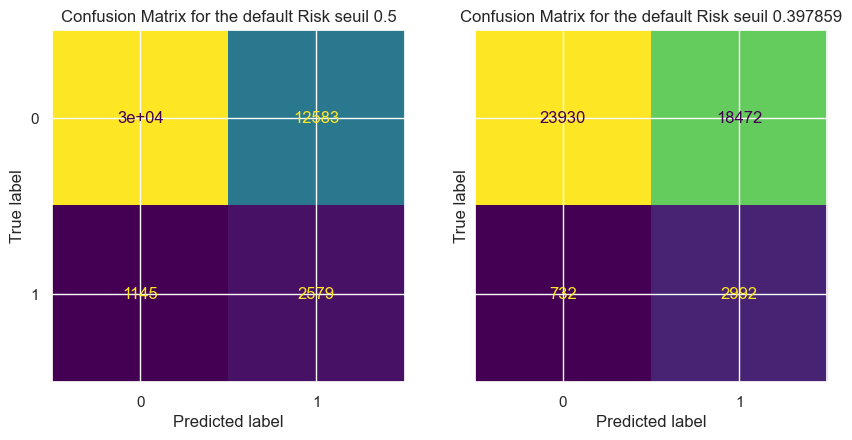

In [274]:
ComparareResultatSeuil( LGBM_pipe, X_test, y_test.values, seuil = 0.397859 )

### Filtered features

CPU times: total: 2min 39s
Wall time: 2min 36s


<Axes: xlabel='seuil'>

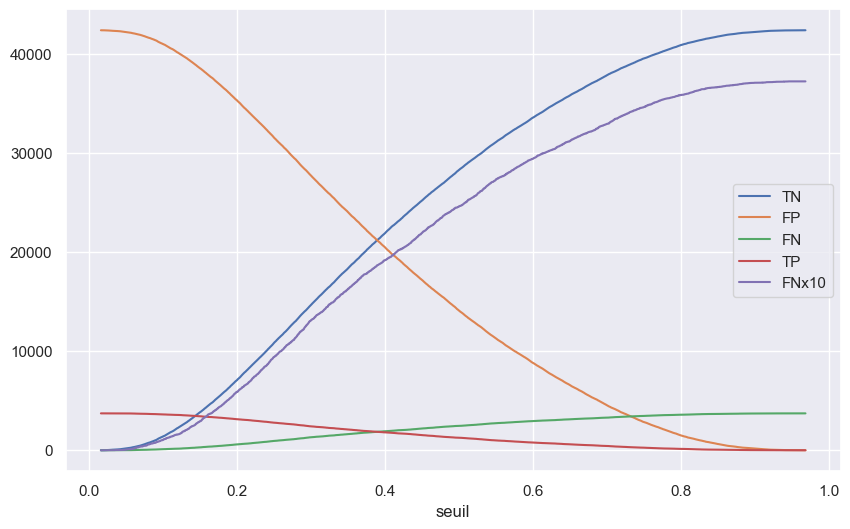

In [308]:
%%time
reultatmetricsHistGBFilt = compute_metric_cm( HistGB_pipe_filtered.predict_proba(X_test )[:,1],y_test.values)
reultatmetricsHistGBFilt['FNx10'] = reultatmetricsHistGBFilt.FN*10
reultatmetricsHistGBFilt.plot(x = 'seuil')

In [309]:
reultatmetricsHistGBFilt.loc[abs(reultatmetricsHistGBFilt.FNx10 - reultatmetricsHistGBFilt.FP)<10]

,seuil,TN,FP,FN,TP,FNx10
24650,0.411363,22688,19714,1971,1753,19710
24651,0.411366,22689,19713,1971,1753,19710
24652,0.411401,22689,19713,1972,1752,19720
24653,0.411404,22690,19712,1972,1752,19720
24654,0.411432,22691,19711,1972,1752,19720


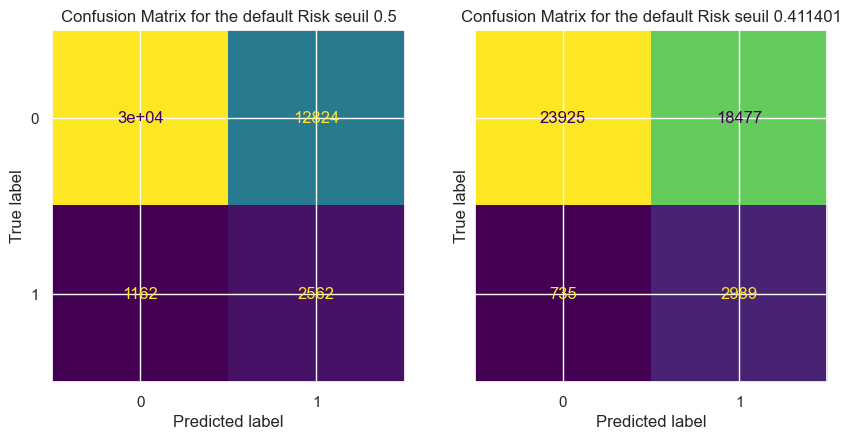

In [280]:
ComparareResultatSeuil(HistGB_pipe_filtered, X_test, y_test.values, seuil = 0.411401 )

<Br>

<Br>

CPU times: total: 2min 36s
Wall time: 2min 36s


<Axes: xlabel='seuil'>

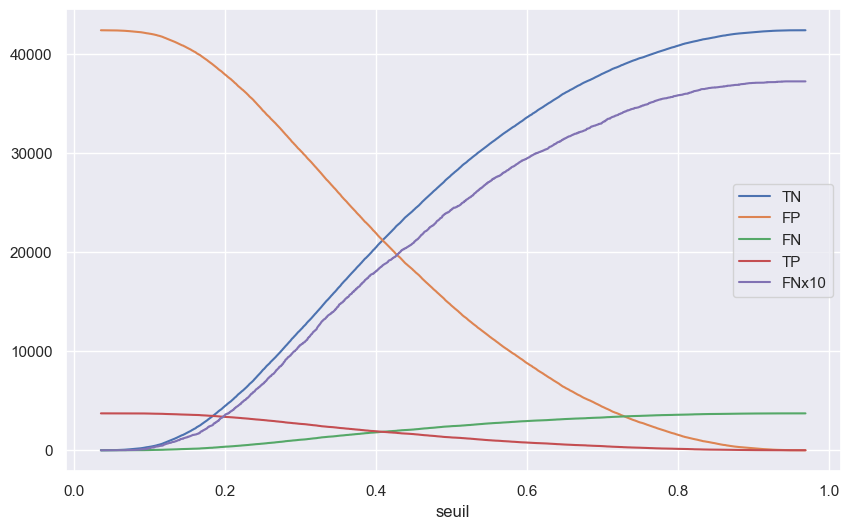

In [310]:
%%time
reultatmetricsRegLogFilt = compute_metric_cm( regLog_pipe_filtered.predict_proba(X_test )[:,1],y_test.values)
reultatmetricsRegLogFilt['FNx10'] = reultatmetricsRegLogFilt.FN*10
reultatmetricsRegLogFilt.plot(x = 'seuil')

In [311]:
reultatmetricsRegLogFilt.loc[abs(reultatmetricsRegLogFilt.FNx10 - reultatmetricsRegLogFilt.FP)<10]

,seuil,TN,FP,FN,TP,FNx10
24658,0.428019,22688,19714,1971,1753,19710
24659,0.428050,22689,19713,1971,1753,19710
24660,0.428052,22689,19713,1972,1752,19720
24661,0.428075,22690,19712,1972,1752,19720
24662,0.428079,22691,19711,1972,1752,19720


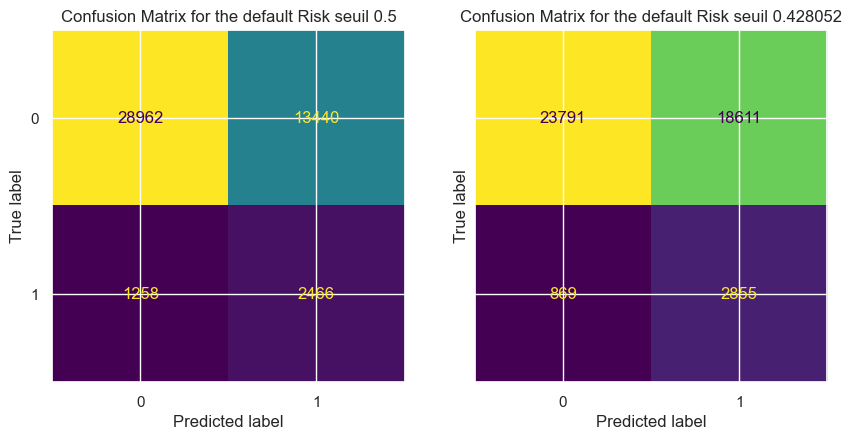

In [283]:
ComparareResultatSeuil(regLog_pipe_filtered, X_test, y_test.values, seuil = 0.428052 )

<Br>

### Filtered features and smote

CPU times: total: 2min 36s
Wall time: 2min 36s


<Axes: xlabel='seuil'>

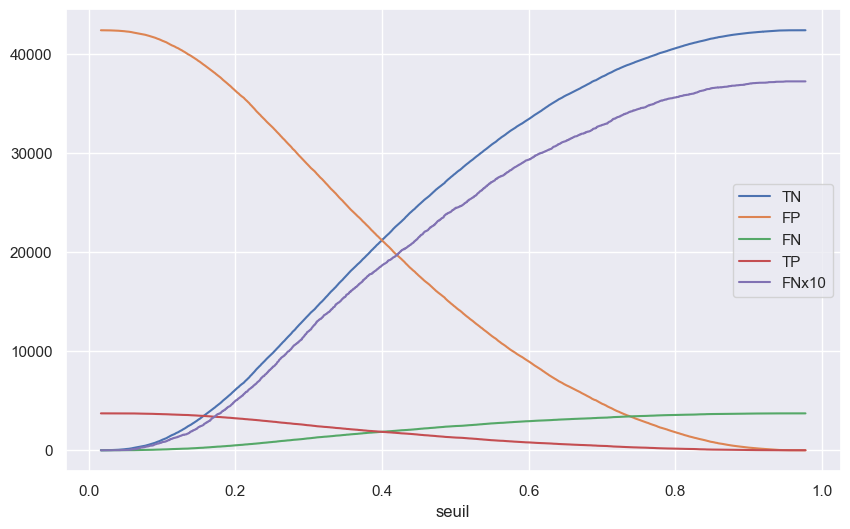

In [312]:
%%time
reultatmetricsRegLogFiltSmote = compute_metric_cm( regLog_pipe_filtered_smote.predict_proba(X_test )[:,1],y_test.values)
reultatmetricsRegLogFiltSmote['FNx10'] = reultatmetricsRegLogFiltSmote.FN*10
reultatmetricsRegLogFiltSmote.plot(x = 'seuil')

In [313]:
reultatmetricsRegLogFiltSmote.loc[abs(reultatmetricsRegLogFiltSmote.FNx10 - reultatmetricsRegLogFiltSmote.FP)<10]

,seuil,TN,FP,FN,TP,FNx10
24658,0.420159,22688,19714,1971,1753,19710
24659,0.420171,22689,19713,1971,1753,19710
24660,0.420198,22689,19713,1972,1752,19720
24661,0.420199,22690,19712,1972,1752,19720
24662,0.420286,22691,19711,1972,1752,19720


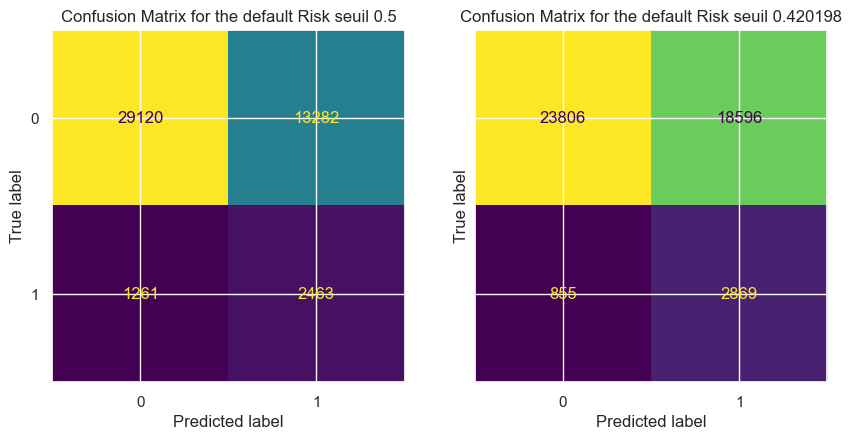

In [286]:
ComparareResultatSeuil(regLog_pipe_filtered_smote, X_test, y_test.values, seuil = 0.420198)

<Br>

<Br>

CPU times: total: 2min 39s
Wall time: 2min 36s


<Axes: xlabel='seuil'>

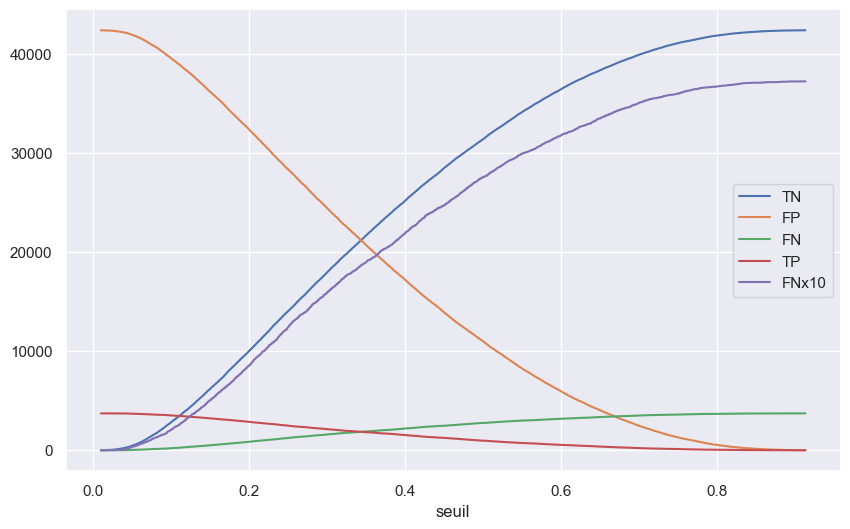

In [314]:
%%time
reultatmetricsHistGBFiltSmote = compute_metric_cm( HistGB_pipe_filtered_smote.predict_proba(X_test )[:,1],y_test.values)
reultatmetricsHistGBFiltSmote['FNx10'] = reultatmetricsHistGBFiltSmote.FN*10
reultatmetricsHistGBFiltSmote.plot(x = 'seuil')

In [315]:
reultatmetricsHistGBFiltSmote.loc[abs(reultatmetricsHistGBFiltSmote.FNx10 - reultatmetricsHistGBFiltSmote.FP)<10]

,seuil,TN,FP,FN,TP,FNx10
24603,0.364155,22688,19714,1971,1753,19710
24604,0.364158,22689,19713,1971,1753,19710
24605,0.364171,22689,19713,1972,1752,19720
24606,0.364214,22690,19712,1972,1752,19720
24607,0.364223,22691,19711,1972,1752,19720


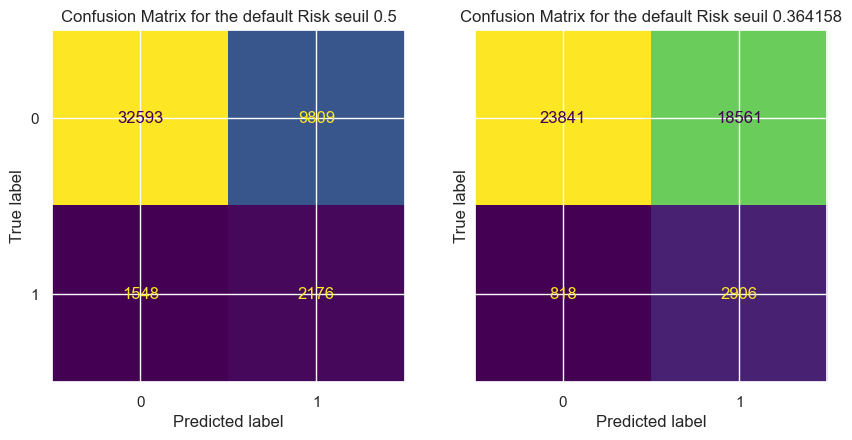

In [322]:
ComparareResultatSeuil(HistGB_pipe_filtered_smote, X_test, y_test.values, seuil = 0.364158 )

<Br>

<Br>

In [316]:
del TP, TN, FP, FN, res, seuil, best_cout, true_y, proba

### <a name="C39"><font color='green'>III.9 Comparaison des modeles</font></a>

#### <a name="C391"><font color='green'>III.9.1 Comparaison des modeles</font></a>

### all features model

In [425]:
%%time
train_test_valid_acc, train_test_valid_auc, train_test_valid_f1 = dict(), dict(), dict()

for clf in [dummy_pipe,regLog_pipe, Ada_pipe, RF_pipe, HistGB_pipe, LGBM_pipe ]:
    
    print("Entrainement du model:",clf.steps[-1][1].__class__.__name__, "en cours!")
        
    train_test_valid_auc[clf.steps[-1][1].__class__.__name__] = {
        'train':roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]),
        'validation':roc_auc_score(y_validation, clf.predict_proba(X_validation)[:, 1]),
        'test':roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])}
    
    train_test_valid_acc[clf.steps[-1][1].__class__.__name__] = {
        'train':balanced_accuracy_score(y_train, clf.predict(X_train) ),
        'validation':balanced_accuracy_score(y_validation, clf.predict(X_validation) ),
        'test':balanced_accuracy_score(y_test, clf.predict(X_test) )}
    
    train_test_valid_f1[clf.steps[-1][1].__class__.__name__] = {
        'train':f1_score(y_train, clf.predict(X_train) ),
        'validation':f1_score(y_validation, clf.predict(X_validation) ),
        'test':f1_score(y_test, clf.predict(X_test) )}

Entrainement du model: DummyClassifier en cours!
Entrainement du model: LogisticRegression en cours!
Entrainement du model: AdaBoostClassifier en cours!
Entrainement du model: RandomForestClassifier en cours!
Entrainement du model: HistGradientBoostingClassifier en cours!
Entrainement du model: LGBMClassifier en cours!
CPU times: total: 2min 57s
Wall time: 1min 12s


### filtered features model

In [426]:
%%time
train_test_valid_acc_filtered, train_test_valid_auc_filtered, train_test_valid_f1_filtered = dict(), dict(), dict()

for clf in [ regLog_pipe_filtered, HistGB_pipe_filtered ]:
    
    print("Entrainement du model:",clf.steps[-1][1].__class__.__name__, "en cours!")
        
    train_test_valid_auc_filtered[clf.steps[-1][1].__class__.__name__] = {
        'train':roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]),
        'validation':roc_auc_score(y_validation, clf.predict_proba(X_validation)[:, 1]),
        'test':roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])}
    
    train_test_valid_acc_filtered[clf.steps[-1][1].__class__.__name__] = {
        'train':balanced_accuracy_score(y_train, clf.predict(X_train) ),
        'validation':balanced_accuracy_score(y_validation, clf.predict(X_validation) ),
        'test':balanced_accuracy_score(y_test, clf.predict(X_test) )}
    
    train_test_valid_f1_filtered[clf.steps[-1][1].__class__.__name__] = {
        'train':f1_score(y_train, clf.predict(X_train) ),
        'validation':f1_score(y_validation, clf.predict(X_validation) ),
        'test':f1_score(y_test, clf.predict(X_test) )}

Entrainement du model: LogisticRegression en cours!
Entrainement du model: HistGradientBoostingClassifier en cours!
CPU times: total: 1min
Wall time: 16 s


### filtered features smote model

In [427]:
%%time
train_test_valid_acc_filtered_smote, train_test_valid_auc_filtered_smote, train_test_valid_f1_filtered_smote = dict(), dict(), dict()

for clf in [ regLog_pipe_filtered_smote, HistGB_pipe_filtered_smote ]:
    
    print("Entrainement du model:",clf.steps[-1][1].__class__.__name__, "en cours!")
        
    train_test_valid_auc_filtered_smote[clf.steps[-1][1].__class__.__name__] = {
        'train':roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]),
        'validation':roc_auc_score(y_validation, clf.predict_proba(X_validation)[:, 1]),
        'test':roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])}
    
    train_test_valid_acc_filtered_smote[clf.steps[-1][1].__class__.__name__] = {
        'train':balanced_accuracy_score(y_train, clf.predict(X_train) ),
        'validation':balanced_accuracy_score(y_validation, clf.predict(X_validation) ),
        'test':balanced_accuracy_score(y_test, clf.predict(X_test) )}
    
    train_test_valid_f1_filtered_smote[clf.steps[-1][1].__class__.__name__] = {
        'train':f1_score(y_train, clf.predict(X_train) ),
        'validation':f1_score(y_validation, clf.predict(X_validation) ),
        'test':f1_score(y_test, clf.predict(X_test) )}

Entrainement du model: LogisticRegression en cours!
Entrainement du model: HistGradientBoostingClassifier en cours!
CPU times: total: 1min 33s
Wall time: 10.6 s


#### <a name="C392"><font color='green'>III.9.2 Comparaison des modeles avec meilleur seuil</font></a>

In [428]:
def optimumthreshold(clf,name_key, X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0):
    print("Entrainement du model:",clf.steps[-1][1].__class__.__name__, "en cours!")
    
    pred_train = [1 if p>seuil else 0 for p in clf.predict_proba(X_train)[:,1]]
    pred_test = [1 if p>seuil else 0 for p in clf.predict_proba(X_test)[:,1]]
    pred_validation = [1 if p>seuil else 0 for p in clf.predict_proba(X_validation)[:,1]]
    
    train_test_valid_auc[name_key] = {
        'train':roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]) ,
        'validation':roc_auc_score(y_validation, clf.predict_proba(X_validation)[:,1] ),
        'test':roc_auc_score(y_test, clf.predict_proba(X_test)[:,1] ) 
    },
    train_test_valid_acc[name_key] = {
        'train':balanced_accuracy_score(y_train, pred_train) ,
        'validation':balanced_accuracy_score(y_validation, pred_validation ),
        'test':balanced_accuracy_score(y_test, pred_test ) 
    },
    
    train_test_valid_f1[name_key] = {
        'train':f1_score(y_train, pred_train ),
        'validation':f1_score(y_validation, pred_validation ),
        'test':f1_score(y_test, pred_test )
    }
    
    return train_test_valid_auc, train_test_valid_acc, train_test_valid_f1

In [429]:
%%time
optimumthreshold(regLog_pipe,'regLog opt seuil',X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.419491)
optimumthreshold(regLog_pipe_filtered,'regLog filtered features opt seuil',X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.428052)
optimumthreshold(regLog_pipe_filtered_smote,'regLog filtered features smote opt seuil',X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.420198)

optimumthreshold(Ada_pipe, 'Adaboost opt seuil', X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.486183)

optimumthreshold(RF_pipe, 'RandomForest opt seuil', X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.07)

optimumthreshold(HistGB_pipe, 'HistGB opt seuil', X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.392732)
optimumthreshold(HistGB_pipe_filtered, 'HistGB filtered features opt seuil',X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.411401)
optimumthreshold(HistGB_pipe_filtered_smote, 'HistGB filtered features smote opt seuil',X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.364158)

optimumthreshold(LGBM_pipe, 'LGBM filtered features smote opt seuil', X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.397859)

Entrainement du model: LogisticRegression en cours!
Entrainement du model: LogisticRegression en cours!
Entrainement du model: LogisticRegression en cours!
Entrainement du model: AdaBoostClassifier en cours!
Entrainement du model: RandomForestClassifier en cours!
Entrainement du model: HistGradientBoostingClassifier en cours!
Entrainement du model: HistGradientBoostingClassifier en cours!
Entrainement du model: HistGradientBoostingClassifier en cours!
Entrainement du model: LGBMClassifier en cours!
CPU times: total: 3min 34s
Wall time: 1min 3s


({'DummyClassifier': {'train': 0.5, 'validation': 0.5, 'test': 0.5},
  'LogisticRegression': {'train': 0.7509400427914412,
   'validation': 0.7522603494123812,
   'test': 0.7481411677225164},
  'AdaBoostClassifier': {'train': 0.7505842152708467,
   'validation': 0.7529468248920332,
   'test': 0.7525520305088662},
  'RandomForestClassifier': {'train': 1.0,
   'validation': 0.7266474341273454,
   'test': 0.7256157225575207},
  'HistGradientBoostingClassifier': {'train': 0.8015651313928984,
   'validation': 0.7675071781319406,
   'test': 0.7650352001412899},
  'LGBMClassifier': {'train': 0.8063496582837861,
   'validation': 0.7677548021208093,
   'test': 0.7649482871503893},
  'regLog opt seuil': ({'train': 0.7509400427914412,
    'validation': 0.7522603494123812,
    'test': 0.7481411677225164},),
  'regLog filtered features opt seuil': ({'train': 0.7340819414299629,
    'validation': 0.7367336629025271,
    'test': 0.7377704669707583},),
  'regLog filtered features smote opt seuil': ({'

In [431]:
#correction du bug dict de list créer précédement
for k in train_test_valid_acc.keys():
    if len( train_test_valid_acc[k] ) == 1:
        train_test_valid_acc[k] = train_test_valid_acc[k][0]

In [433]:
#correction du bug dict de list créer précédement
for k in train_test_valid_auc.keys():
    if len( train_test_valid_auc[k] ) == 1:
        print(train_test_valid_auc[k][0])
        train_test_valid_auc[k] = train_test_valid_auc[k][0]

{'train': 0.7509400427914412, 'validation': 0.7522603494123812, 'test': 0.7481411677225164}
{'train': 0.7340819414299629, 'validation': 0.7367336629025271, 'test': 0.7377704669707583}
{'train': 0.7340052227043575, 'validation': 0.7371668687284834, 'test': 0.7363132747979027}
{'train': 0.7505842152708467, 'validation': 0.7529468248920332, 'test': 0.7525520305088662}
{'train': 1.0, 'validation': 0.7266474341273454, 'test': 0.7256157225575207}
{'train': 0.8015651313928984, 'validation': 0.7675071781319406, 'test': 0.7650352001412899}
{'train': 0.7717083011281285, 'validation': 0.7623854898953936, 'test': 0.7644315082314531}
{'train': 0.7500808512584949, 'validation': 0.7441070309887535, 'test': 0.7454800685029399}
{'train': 0.8063496582837861, 'validation': 0.7677548021208093, 'test': 0.7649482871503893}


#### <a name="C393"><font color='green'>III.9.3 Score metier</font></a>

In [444]:
def ScoreMetier(clf, X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0):
    print("Entrainement du model:",clf.steps[-1][1].__class__.__name__, "en cours!")
    
    pred_train = [1 if p>seuil else 0 for p in clf.predict_proba(X_train)[:,1]]
    pred_test = [1 if p>seuil else 0 for p in clf.predict_proba(X_test)[:,1]]
    pred_validation = [1 if p>seuil else 0 for p in clf.predict_proba(X_validation)[:,1]]
    
    TN, FP, FN, TP = confusion_matrix( y_true=y_validation, y_pred=pred_validation ).ravel()
    
    return 10*FN+FP

In [ ]:
optimumthreshold(regLog_pipe,'regLog opt seuil',X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.419491)
optimumthreshold(regLog_pipe_filtered,'regLog filtered features opt seuil',X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.428052)
optimumthreshold(regLog_pipe_filtered_smote,'regLog filtered features smote opt seuil',X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.420198)
optimumthreshold(Ada_pipe, 'Adaboost opt seuil', X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.486183)
optimumthreshold(RF_pipe, 'RandomForest opt seuil', X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.07)
optimumthreshold(HistGB_pipe, 'HistGB opt seuil', X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.392732)
optimumthreshold(HistGB_pipe_filtered, 'HistGB filtered features opt seuil',X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.411401)
optimumthreshold(HistGB_pipe_filtered_smote, 'HistGB filtered features smote opt seuil',X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.364158)

optimumthreshold(LGBM_pipe, 'LGBM filtered features smote opt seuil', X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.397859)

In [446]:
score_metier_dict = dict()

score_metier_dict['regLog opt seuil'] = ScoreMetier(regLog_pipe, X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.419491)
score_metier_dict['regLog filtered features opt seuil'] = ScoreMetier(regLog_pipe_filtered, X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.428052)
score_metier_dict['regLog filtered features smote opt seuil'] = ScoreMetier(regLog_pipe_filtered_smote, X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.420198)
score_metier_dict['Adaboost opt seuil'] = ScoreMetier(Ada_pipe, X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.486183)
score_metier_dict['RandomForest opt seuil'] = ScoreMetier(RF_pipe, X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.07)
score_metier_dict['HistGB opt seuil'] = ScoreMetier(HistGB_pipe, X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.392732)
score_metier_dict['HistGB filtered features opt seuil'] = ScoreMetier(HistGB_pipe_filtered, X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.411401)
score_metier_dict['HistGB filtered features smote opt seuil'] = ScoreMetier(HistGB_pipe_filtered_smote, X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.364158)
score_metier_dict['LGBM filtered features smote opt seuil'] = ScoreMetier(LGBM_pipe, X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.397859)


score_metier_dict['LGBMClassifier'] = ScoreMetier(LGBM_pipe, X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.5)
score_metier_dict['HistGradientBoostingClassifier'] = ScoreMetier(HistGB_pipe, X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.5)
score_metier_dict['HistGradientBoostingClassifier_filtered'] = ScoreMetier(HistGB_pipe_filtered, X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.5)
score_metier_dict['LogisticRegression'] = ScoreMetier(regLog_pipe, X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.5)


score_metier_dict['LogisticRegression_filtered_smote'] = ScoreMetier(regLog_pipe_filtered_smote, X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.5)
score_metier_dict['HistGradientBoostingClassifier_filtered_smote'] = ScoreMetier(HistGB_pipe_filtered_smote, X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.5)
score_metier_dict['LogisticRegression_filtered'] = ScoreMetier(regLog_pipe, X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.5)
score_metier_dict['AdaBoostClassifier'] = ScoreMetier(Ada_pipe, X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.5)
score_metier_dict['RandomForestClassifier'] = ScoreMetier(RF_pipe, X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.5)
score_metier_dict['DummyClassifier'] = ScoreMetier(dummy_pipe, X_train,X_test,X_validation,y_train,y_test,y_validation,seuil = 0.5)

Entrainement du model: LogisticRegression en cours!
Entrainement du model: LogisticRegression en cours!
Entrainement du model: LogisticRegression en cours!
Entrainement du model: AdaBoostClassifier en cours!
Entrainement du model: RandomForestClassifier en cours!
Entrainement du model: HistGradientBoostingClassifier en cours!
Entrainement du model: HistGradientBoostingClassifier en cours!
Entrainement du model: HistGradientBoostingClassifier en cours!
Entrainement du model: LGBMClassifier en cours!
Entrainement du model: LGBMClassifier en cours!
Entrainement du model: HistGradientBoostingClassifier en cours!
Entrainement du model: HistGradientBoostingClassifier en cours!
Entrainement du model: LogisticRegression en cours!
Entrainement du model: LogisticRegression en cours!
Entrainement du model: HistGradientBoostingClassifier en cours!
Entrainement du model: LogisticRegression en cours!
Entrainement du model: AdaBoostClassifier en cours!
Entrainement du model: RandomForestClassifier en

### Resultat

In [474]:
res_acc = pd.concat( [pd.DataFrame(train_test_valid_acc).T,
                      pd.DataFrame(train_test_valid_acc_filtered).T\
                      .rename(index={'LogisticRegression': 'LogisticRegression_filtered',
                                     'HistGradientBoostingClassifier': 'HistGradientBoostingClassifier_filtered'}),
                      pd.DataFrame(train_test_valid_acc_filtered_smote).T\
                      .rename(index={'LogisticRegression': 'LogisticRegression_filtered_smote',
                                     'HistGradientBoostingClassifier': 'HistGradientBoostingClassifier_filtered_smote'})
                     ]
                   )
#res_acc.sort_values(by = ['validation'],ascending=False)

In [475]:
res_auc = pd.concat( [pd.DataFrame(train_test_valid_auc).T,
                      pd.DataFrame(train_test_valid_auc_filtered).T\
                      .rename(index={'LogisticRegression': 'LogisticRegression_filtered',
                                     'HistGradientBoostingClassifier': 'HistGradientBoostingClassifier_filtered'}),
                      pd.DataFrame(train_test_valid_auc_filtered_smote).T\
                      .rename(index={'LogisticRegression': 'LogisticRegression_filtered_smote',
                                     'HistGradientBoostingClassifier': 'HistGradientBoostingClassifier_filtered_smote'})
                      
                     ] )
#res_auc.sort_values(by = ['validation'],ascending=False)

In [476]:
res_f1 = pd.concat( [pd.DataFrame(train_test_valid_f1).T,
                     pd.DataFrame(train_test_valid_f1_filtered).T\
                     .rename(index={'LogisticRegression': 'LogisticRegression_filtered',
                                    'HistGradientBoostingClassifier': 'HistGradientBoostingClassifier_filtered'}),
                     pd.DataFrame(train_test_valid_f1_filtered_smote).T\
                     .rename(index={'LogisticRegression': 'LogisticRegression_filtered_smote',
                                    'HistGradientBoostingClassifier': 'HistGradientBoostingClassifier_filtered_smote'})
                    ] )

#res_f1.sort_values(by = ['validation'],ascending=False)

In [477]:
resultat = res_acc.rename(columns={'train':'acc_train','validation':'acc_validation','test':'acc_test'})\
.join(res_auc.rename(columns={'train':'auc_train','validation':'auc_validation','test':'auc_test'}))\
.join(res_f1.rename(columns={'train':'f1_train','validation':'f1_validation','test':'f1_test'}))\
.join(pd.DataFrame.from_dict(score_metier_dict,orient='index').sort_values(by = 0,ascending=True).rename(columns={0:"Score metier"}))

In [493]:
resultat.sort_values(by = 'Score metier',ascending=True )

,acc_train,acc_validation,acc_test,auc_train,auc_validation,auc_test,f1_train,f1_validation,f1_test,Score metier
LGBMClassifier,0.726862,0.703737,0.697890,0.806350,0.767755,0.764948,0.294657,0.278115,0.273112,23579
HistGradientBoostingClassifier,0.723558,0.702651,0.696754,0.801565,0.767507,0.765035,0.295127,0.279390,0.275061,23624
HistGradientBoostingClassifier_filtered,0.700252,0.694711,0.692766,0.771708,0.762385,0.764432,0.273479,0.269613,0.268132,24296
LogisticRegression,0.685414,0.691456,0.681565,0.750940,0.752260,0.748141,0.261402,0.264912,0.257876,24590
LogisticRegression_filtered,0.671950,0.675562,0.672613,0.734082,0.736734,0.737770,0.250935,0.253603,0.251248,24590
LGBM filtered features smote opt seuil,0.716585,0.691433,0.683899,0.806350,0.767755,0.764948,0.255173,0.241807,0.237573,25220
HistGradientBoostingClassifier_filtered_smote,0.675912,0.676806,0.676492,0.750081,0.744107,0.745480,0.277085,0.277413,0.277039,25264
HistGB opt seuil,0.713688,0.688920,0.685201,0.801565,0.767507,0.765035,0.253498,0.240391,0.238279,25411
LogisticRegression_filtered_smote,0.673107,0.679745,0.674073,0.734005,0.737167,0.736313,0.252433,0.257053,0.253018,25464
HistGB filtered features opt seuil,0.691943,0.685762,0.683437,0.771708,0.762385,0.764432,0.241805,0.238422,0.237316,25658


In [499]:
resultat.sort_values(by = 'auc_validation',ascending=False )

,acc_train,acc_validation,acc_test,auc_train,auc_validation,auc_test,f1_train,f1_validation,f1_test,Score metier
LGBMClassifier,0.726862,0.703737,0.697890,0.806350,0.767755,0.764948,0.294657,0.278115,0.273112,23579
LGBM filtered features smote opt seuil,0.716585,0.691433,0.683899,0.806350,0.767755,0.764948,0.255173,0.241807,0.237573,25220
HistGB opt seuil,0.713688,0.688920,0.685201,0.801565,0.767507,0.765035,0.253498,0.240391,0.238279,25411
HistGradientBoostingClassifier,0.723558,0.702651,0.696754,0.801565,0.767507,0.765035,0.295127,0.279390,0.275061,23624
HistGradientBoostingClassifier_filtered,0.700252,0.694711,0.692766,0.771708,0.762385,0.764432,0.273479,0.269613,0.268132,24296
HistGB filtered features opt seuil,0.691943,0.685762,0.683437,0.771708,0.762385,0.764432,0.241805,0.238422,0.237316,25658
Adaboost opt seuil,0.677382,0.680524,0.672641,0.750584,0.752947,0.752552,0.234345,0.235988,0.231450,26037
AdaBoostClassifier,0.510161,0.509320,0.508858,0.750584,0.752947,0.752552,0.042483,0.039226,0.037658,36555
regLog opt seuil,0.677483,0.677803,0.669416,0.750940,0.752260,0.748141,0.234248,0.234373,0.229694,26247
LogisticRegression,0.685414,0.691456,0.681565,0.750940,0.752260,0.748141,0.261402,0.264912,0.257876,24590


In [500]:
resultat.sort_values(by = 'acc_validation',ascending=False )

,acc_train,acc_validation,acc_test,auc_train,auc_validation,auc_test,f1_train,f1_validation,f1_test,Score metier
LGBMClassifier,0.726862,0.703737,0.697890,0.806350,0.767755,0.764948,0.294657,0.278115,0.273112,23579
HistGradientBoostingClassifier,0.723558,0.702651,0.696754,0.801565,0.767507,0.765035,0.295127,0.279390,0.275061,23624
HistGradientBoostingClassifier_filtered,0.700252,0.694711,0.692766,0.771708,0.762385,0.764432,0.273479,0.269613,0.268132,24296
LogisticRegression,0.685414,0.691456,0.681565,0.750940,0.752260,0.748141,0.261402,0.264912,0.257876,24590
LGBM filtered features smote opt seuil,0.716585,0.691433,0.683899,0.806350,0.767755,0.764948,0.255173,0.241807,0.237573,25220
HistGB opt seuil,0.713688,0.688920,0.685201,0.801565,0.767507,0.765035,0.253498,0.240391,0.238279,25411
HistGB filtered features opt seuil,0.691943,0.685762,0.683437,0.771708,0.762385,0.764432,0.241805,0.238422,0.237316,25658
Adaboost opt seuil,0.677382,0.680524,0.672641,0.750584,0.752947,0.752552,0.234345,0.235988,0.231450,26037
LogisticRegression_filtered_smote,0.673107,0.679745,0.674073,0.734005,0.737167,0.736313,0.252433,0.257053,0.253018,25464
regLog opt seuil,0.677483,0.677803,0.669416,0.750940,0.752260,0.748141,0.234248,0.234373,0.229694,26247


In [501]:
resultat.sort_values(by = 'f1_validation',ascending=False )

,acc_train,acc_validation,acc_test,auc_train,auc_validation,auc_test,f1_train,f1_validation,f1_test,Score metier
HistGradientBoostingClassifier,0.723558,0.702651,0.696754,0.801565,0.767507,0.765035,0.295127,0.279390,0.275061,23624
LGBMClassifier,0.726862,0.703737,0.697890,0.806350,0.767755,0.764948,0.294657,0.278115,0.273112,23579
HistGradientBoostingClassifier_filtered_smote,0.675912,0.676806,0.676492,0.750081,0.744107,0.745480,0.277085,0.277413,0.277039,25264
HistGradientBoostingClassifier_filtered,0.700252,0.694711,0.692766,0.771708,0.762385,0.764432,0.273479,0.269613,0.268132,24296
LogisticRegression,0.685414,0.691456,0.681565,0.750940,0.752260,0.748141,0.261402,0.264912,0.257876,24590
LogisticRegression_filtered_smote,0.673107,0.679745,0.674073,0.734005,0.737167,0.736313,0.252433,0.257053,0.253018,25464
LogisticRegression_filtered,0.671950,0.675562,0.672613,0.734082,0.736734,0.737770,0.250935,0.253603,0.251248,24590
LGBM filtered features smote opt seuil,0.716585,0.691433,0.683899,0.806350,0.767755,0.764948,0.255173,0.241807,0.237573,25220
HistGB opt seuil,0.713688,0.688920,0.685201,0.801565,0.767507,0.765035,0.253498,0.240391,0.238279,25411
HistGB filtered features opt seuil,0.691943,0.685762,0.683437,0.771708,0.762385,0.764432,0.241805,0.238422,0.237316,25658


#### Les 3 meilleurs modeles sont : 1er LGBMClassifier, 2nd HistGradientBoostingClassifier, 3e HistGradientBoostingClassifier_filtered

## <a name="C4"><font color='purple'>IV. Sauvegarde des models</font></a>

In [495]:
import joblib
joblib.dump(dummy_pipe, "data/modeles sauvegardés/DummyClassifer_model.sav")

joblib.dump(regLog_pipe,"data/modeles sauvegardés/LogisticRegression_model.sav")
joblib.dump(regLog_pipe_filtered,"data/modeles sauvegardés/LogisticRegression_model_filtered.sav")
joblib.dump(regLog_pipe_filtered_smote,"data/modeles sauvegardés/LogisticRegression_model_filtered_smote.sav")

joblib.dump(Ada_pipe,"data/modeles sauvegardés/AdaBoostClassifier_model.sav")
joblib.dump(RF_pipe,"data/modeles sauvegardés/RandomForestClassifier_model.sav")

joblib.dump(HistGB_pipe, "data/modeles sauvegardés/HistGradientBoostingClassifier_model.sav")
joblib.dump(HistGB_pipe_filtered, "data/modeles sauvegardés/HistGradientBoostingClassifier_model_filtered.sav")
joblib.dump(HistGB_pipe_filtered_smote, "data/modeles sauvegardés/HistGradientBoostingClassifier_model_filtered_smote.sav")

joblib.dump(LGBM_pipe,"data/modeles sauvegardés/lightGBMClasiifer_model.sav")

# Model de traitement des données
joblib.dump(sfs_mlxtend, "data/modeles sauvegardés/featureSelectionSFS.sav")

['data/modeles sauvegardés/featureSelectionSFS.sav']

In [496]:
gc.collect()

57257

## <a name="C5"><font color='blue'>V. MLflow</font></a>

In [504]:
import mlflow

In [505]:
def eval_metrics(actual, pred, pred_proba):
    accuracy = balanced_accuracy_score(actual, pred)
    precision = precision_score(actual, pred )
    f1 = f1_score(actual, pred)
    recall = recall_score(actual, pred)
    auc = roc_auc_score(actual, pred_proba[:,1])
    return accuracy, precision, f1, recall, auc

### Présentation de MLflow

> MLflow is a platform to streamline machine learning development, including tracking experiments, packaging code into reproducible runs, and sharing and **deploying models**. MLflow offers a set of lightweight APIs that can be used with any existing machine learning application or library (TensorFlow, PyTorch, XGBoost, etc), wherever you currently run ML code (e.g. in notebooks, standalone applications or the cloud). MLflow's current components are:
>- MLflow Tracking: An API to log parameters, code, and results in machine learning experiments and compare them using an interactive UI.
>- MLflow Projects: A code packaging format for reproducible runs using Conda and Docker, so you can share your ML code with others.
>- **MLflow Models: A model packaging format and tools that let you easily deploy the same model (from any ML library) to batch and real-time scoring on platforms >such as Docker, Apache Spark, Azure ML and AWS SageMaker.**
>- MLflow Model Registry: A centralized model store, set of APIs, and UI, to collaboratively manage the full lifecycle of MLflow Models.

[Source](https://github.com/mlflow/mlflow)

--------

MLflow est une librairie dédiée à la gestion du cycle de vie d'un projet de machine learning, à savoir :
- le suivi des résultats liés aux expériences (MLflow Tracking)
- garantir la reproducibilité des expériences et le partage de code (MLflow Projects)
- la gestion des modèles sous un format normalisé afin de simplifier les déploiements locaux ou cloud (MLflow Models)
- la centralisation et le versionnage les modèles (MLflow Model Registry)

**On s'intéresse dans le cadre de l'exercice à MLflow Models uniquement**, vous pouvez explorer les autres fonctionnalités bien entendu, cependant ce n'est pas l'objectif de cet exercice.

-------

### Format de stockage d'un modèle

Un modèle MLflow est un répertoire contenant une liste de fichiers, dont un nommé MLmodel qui liste les différentes flavors (terme MLflow) dans lesquelles le modèle est utilisable.

Les flavors sont une façon pratique de définir comment exécuter un modèle, cette convention facilite le déploiement car la flavor standardise la façon de prédire à partir d'un modèle. MLflow définit par exemple des flavors pour une fonction python, sklearn, tensorflow, xgboost.

Dans le répertoire de sauvegarde du modèle MLflow, le fichier MLmodel contient l'ensemble des flavors disponibles, par exemple :
```yaml
time_created: 2018-05-25T17:28:53.35

flavors:
  sklearn:
    sklearn_version: 0.19.1
    pickled_model: model.pkl
  python_function:
    loader_module: mlflow.sklearn
```

Tous les outils supportant les flavors `python_function` ou `sklearn` pourront utiliser ce modèle, par exemple pour un déploiement avec la commande suivante.

```python
mlflow models serve -m my_model
```

D'autres outils cloud comme AWS SageMaker ou Azure ML peuvent utiliser ces flavors.

[Documentation pour approfondir](https://mlflow.org/docs/latest/models.html#storage-format)

-----------

### <a name="C50"><font color='blue'>V.0 Setting mlflow </font></a>

### infer_signature
Les signatures de modèle définissent les schémas d'entrée et de sortie pour les modèles MLflow, fournissant une interface standard pour codifier et appliquer l'utilisation correcte de vos modèles. 

Les signatures sont récupérées par l'interface utilisateur de suivi MLflow et l'interface utilisateur du registre de modèles pour afficher les entrées et les sorties du modèle. 

Ils sont également utilisés par les outils de déploiement de modèle MLflow pour valider les entrées d'inférence en fonction de la signature attribuée au modèle.

In [506]:
from mlflow.models import infer_signature
signature = infer_signature(X_train,y_train)

### <a name="C51"><font color='blue'>V.1 Tracking mlflow </font></a>

MLflow Tracking est l'API et l'interface utilisateur pour logger 
* les hyper-paramètres, 
* le versioning de code, 
* les artifacts (configuration du modèle, fichier de poids, ...).

In [507]:
# Définir où les Runs sont enregistrées local ou remote
mlflow.set_tracking_uri("data/mlflow/mlruns") 

# Définir l'expérience donnée comme l'expérience active.
# Définir un nom d'expérience, qui doit être unique et sensible à la casse.
# 'OC_projet_7' : path to experiment in remote workspace
mlflow.set_experiment('OC_projet_7') 

# Active (ou désactive) et configure l'autologisation pour les estimateurs scikit-learn.
mlflow.sklearn.autolog(exclusive=False)# Permet de faire appel à l'API de sklearn qui integre tous les algorithme de scikit-learn

accuracy : 0.5 | precision : 0.0 | f1 : 0.0 | recall : 0.0 | auc : 0.5
AUC: 0.5
CPU times: total: 1.12 s
Wall time: 3.89 s


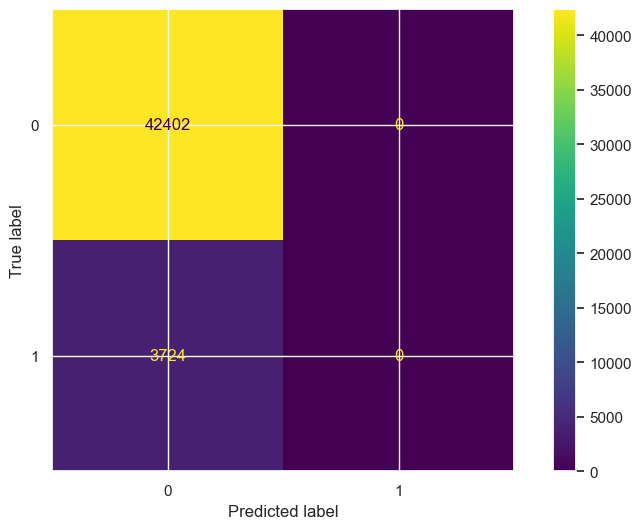

In [508]:
%%time

# Dummy estimator
with mlflow.start_run(run_name='Dummy_Estimator'): #experiment_id= experiment_id
    #dummy_pipe.fit(X_train, y_train)
    
    y_pred_proba = dummy_pipe.predict_proba(X_test)
    y_pred = dummy_pipe.predict(X_test)
    
    # Metrics
    accuracy, precision, f1, recall, auc = eval_metrics(y_test,y_pred, y_pred_proba)
    print("accuracy : {} | precision : {} | f1 : {} | recall : {} | auc : {}".format(accuracy, precision, f1, recall, auc))
    cm = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred)
    print("AUC:", auc)
    # Log params
    # mlflow.log_param('max_iter' , '100')
    
    # Log metrics
    mlflow.log_metric("accuracy_test",accuracy)
    mlflow.log_metric('precision_test',precision)
    mlflow.log_metric("f1_test",f1)
    mlflow.log_metric("recall_test",recall)
    mlflow.log_metric("auc_test",auc)
    
    # Log figure
    mlflow.log_figure(cm.figure_, 'test_confusion_matrix.png')
    
    # Log model
    mlflow.sklearn.log_model(dummy_pipe, 'pipeline Dummy Estimator', signature=signature)
    #generate_auc_roc_curve(logReg,X_test, y_test)
    #metrics = {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2)}

### Regression logistique

accuracy : 68.157% | precision : 15.927% | f1 : 25.788% | recall : 67.696% | auc : 74.814%
accuracy_seuil : 66.942% | precision_seuil : 13.477% | f1_seuil : 22.969% | recall_seuil : 77.685%
AUC: 0.7481411677225164
CPU times: total: 1.34 s
Wall time: 3.47 s


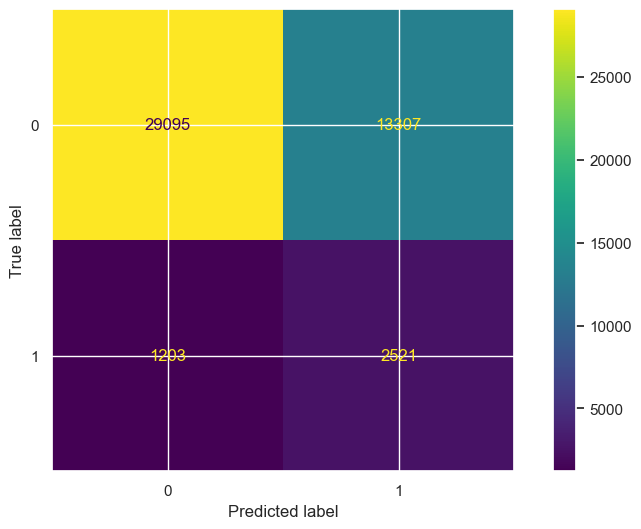

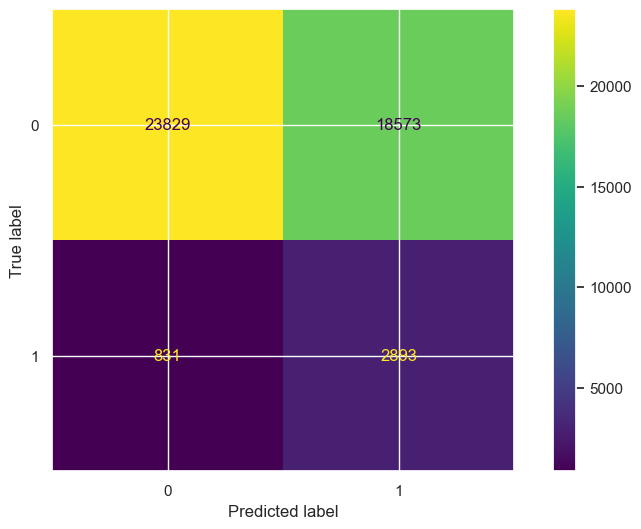

In [510]:
%%time
# premier run
with mlflow.start_run(run_name='Reg_logistic_balanced_1'): #experiment_id= experiment_id
    #regLog_pipe.fit(X_train, y_train)
    
    seuil = 0.419491
    y_pred_proba = regLog_pipe.predict_proba(X_test)
    y_pred_seuil = [1 if p > seuil else 0 for p in regLog_pipe.predict_proba(X_test)[:,1]]
    y_pred = regLog_pipe.predict(X_test)
    
    # Metrics
    accuracy, precision, f1, recall, auc = eval_metrics(y_test,y_pred, y_pred_proba)
    accuracy_seuil, precision_seuil, f1_seuil, recall_seuil, _ = eval_metrics(y_test,y_pred_seuil, y_pred_proba)
    print("accuracy : {:.3%} | precision : {:.3%} | f1 : {:.3%} | recall : {:.3%} | auc : {:.3%}".format(accuracy, precision, f1, recall, auc))
    print("accuracy_seuil : {:.3%} | precision_seuil : {:.3%} | f1_seuil : {:.3%} | recall_seuil : {:.3%}".format(accuracy_seuil, precision_seuil, f1_seuil, recall_seuil))
    cm = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred)
    cmSeuil = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred_seuil)
    #print("AUC:", auc)
    
    # Log metrics
    mlflow.log_metric("accuracy_test",accuracy)
    mlflow.log_metric('precision_test',precision)
    mlflow.log_metric("f1_test",f1)
    mlflow.log_metric("recall_test",recall)
    mlflow.log_metric("auc_test",auc)
    
    mlflow.log_metric("accuracy_test",accuracy_seuil)
    mlflow.log_metric('precision_test',precision_seuil)
    mlflow.log_metric("f1_test",f1_seuil)
    mlflow.log_metric("recall_test",recall_seuil)
        
    # Log figure
    mlflow.log_figure(cm.figure_, 'test_confusion_matrix.png')
    mlflow.log_figure(cmSeuil.figure_, 'test_confusion_matrix_seuil.png')
    
    # Log model
    mlflow.sklearn.log_model(regLog_pipe, 'pipeline Regression Logistic balanced', signature=signature)
    run_idrlog = mlflow.active_run().info.run_id

accuracy : 67.261% | precision : 15.504% | f1 : 25.125% | recall : 66.219% | auc : 73.777%
accuracy_seuil : 66.387% | precision_seuil : 13.300% | f1_seuil : 22.668% | recall_seuil : 76.665%
CPU times: total: 1.44 s
Wall time: 3.54 s


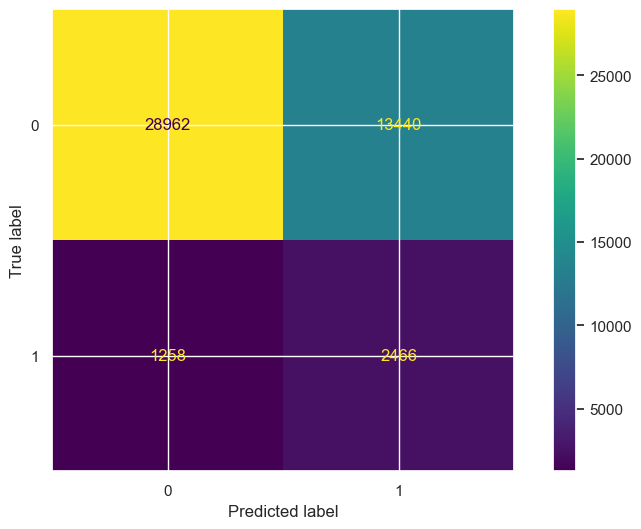

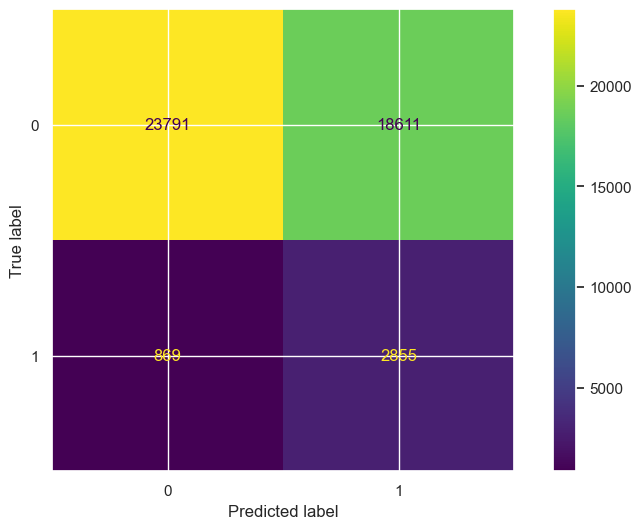

In [511]:
%%time
# premier run
with mlflow.start_run(run_name='Reg_logistic_SelectedFeatures_1'): #experiment_id= experiment_id
    #regLog_pipe.fit(X_train, y_train)
    
    seuil = 0.428052
    y_pred_proba = regLog_pipe_filtered.predict_proba(X_test)
    y_pred_seuil = [1 if p > seuil else 0 for p in regLog_pipe_filtered.predict_proba(X_test)[:,1]]
    y_pred = regLog_pipe_filtered.predict(X_test)
    
    # Metrics
    accuracy, precision, f1, recall, auc = eval_metrics(y_test,y_pred, y_pred_proba)
    accuracy_seuil, precision_seuil, f1_seuil, recall_seuil, _ = eval_metrics(y_test,y_pred_seuil, y_pred_proba)
    print("accuracy : {:.3%} | precision : {:.3%} | f1 : {:.3%} | recall : {:.3%} | auc : {:.3%}".format(accuracy, precision, f1, recall, auc))
    print("accuracy_seuil : {:.3%} | precision_seuil : {:.3%} | f1_seuil : {:.3%} | recall_seuil : {:.3%}".format(accuracy_seuil, precision_seuil, f1_seuil, recall_seuil))
    cm = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred)
    cmSeuil = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred_seuil)
    #print("AUC:", auc)
    
    # Log metrics
    mlflow.log_metric("accuracy_test",accuracy)
    mlflow.log_metric('precision_test',precision)
    mlflow.log_metric("f1_test",f1)
    mlflow.log_metric("recall_test",recall)
    mlflow.log_metric("auc_test",auc)
    
    mlflow.log_metric("accuracy_test",accuracy_seuil)
    mlflow.log_metric('precision_test',precision_seuil)
    mlflow.log_metric("f1_test",f1_seuil)
    mlflow.log_metric("recall_test",recall_seuil)
        
    # Log figure
    mlflow.log_figure(cm.figure_, 'test_confusion_matrix.png')
    mlflow.log_figure(cmSeuil.figure_, 'test_confusion_matrix_seuil.png')
    
    # Log model
    mlflow.sklearn.log_model(regLog_pipe_filtered, 'pipeline Regression Logistic Selected Features', signature=signature)
    run_idrlogf = mlflow.active_run().info.run_id

accuracy : 67.407% | precision : 15.643% | f1 : 25.302% | recall : 66.139% | auc : 73.631%
accuracy_seuil : 66.592% | precision_seuil : 13.366% | f1_seuil : 22.780% | recall_seuil : 77.041%
CPU times: total: 672 ms
Wall time: 2.97 s


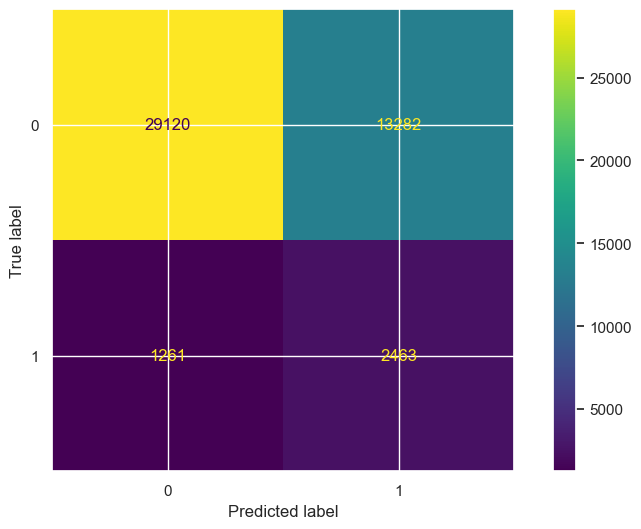

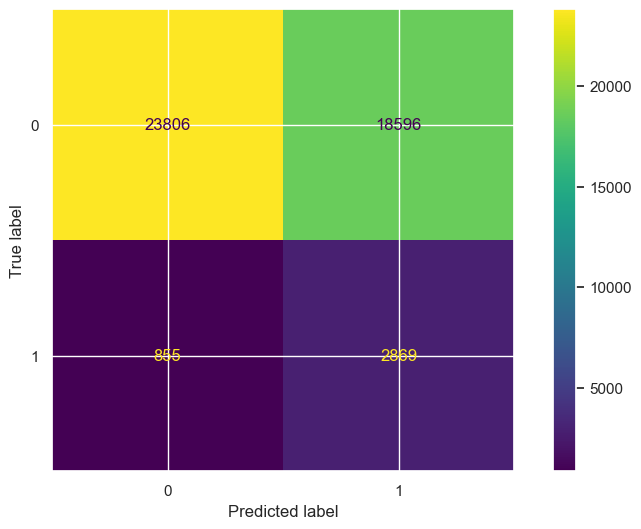

In [513]:
%%time
# premier run
with mlflow.start_run(run_name='regLog_pipe_filtered_smote'): #experiment_id= experiment_id
    #regLog_pipe.fit(X_train, y_train)
    
    seuil = 0.420198
    y_pred_proba = regLog_pipe_filtered_smote.predict_proba(X_test)
    y_pred_seuil = [1 if p > seuil else 0 for p in regLog_pipe_filtered_smote.predict_proba(X_test)[:,1]]
    y_pred = regLog_pipe_filtered_smote.predict(X_test)
    
    # Metrics
    accuracy, precision, f1, recall, auc = eval_metrics(y_test,y_pred, y_pred_proba)
    accuracy_seuil, precision_seuil, f1_seuil, recall_seuil, _ = eval_metrics(y_test,y_pred_seuil, y_pred_proba)
    print("accuracy : {:.3%} | precision : {:.3%} | f1 : {:.3%} | recall : {:.3%} | auc : {:.3%}".format(accuracy, precision, f1, recall, auc))
    print("accuracy_seuil : {:.3%} | precision_seuil : {:.3%} | f1_seuil : {:.3%} | recall_seuil : {:.3%}".format(accuracy_seuil, precision_seuil, f1_seuil, recall_seuil))
    cm = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred)
    cmSeuil = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred_seuil)
    #print("AUC:", auc)
    
    # Log metrics
    mlflow.log_metric("accuracy_test",accuracy)
    mlflow.log_metric('precision_test',precision)
    mlflow.log_metric("f1_test",f1)
    mlflow.log_metric("recall_test",recall)
    mlflow.log_metric("auc_test",auc)
    
    mlflow.log_metric("accuracy_test",accuracy_seuil)
    mlflow.log_metric('precision_test',precision_seuil)
    mlflow.log_metric("f1_test",f1_seuil)
    mlflow.log_metric("recall_test",recall_seuil)
        
    # Log figure
    mlflow.log_figure(cm.figure_, 'test_confusion_matrix.png')
    mlflow.log_figure(cmSeuil.figure_, 'test_confusion_matrix_seuil.png')
    
    # Log model
    mlflow.sklearn.log_model(regLog_pipe_filtered_smote, 'pipeline Regression Logistic Selected Features Resampling SMOTE', signature=signature)
    run_idrlogfs = mlflow.active_run().info.run_id

### Histogram Gradient Boosting 

accuracy : 69.675% | precision : 17.237% | f1 : 27.506% | recall : 68.045% | auc : 76.504%
accuracy_seuil : 66.592% | precision_seuil : 13.366% | f1_seuil : 22.780% | recall_seuil : 77.041%


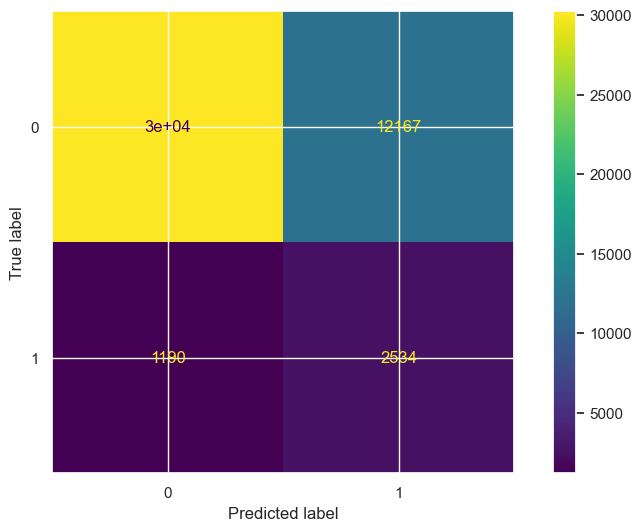

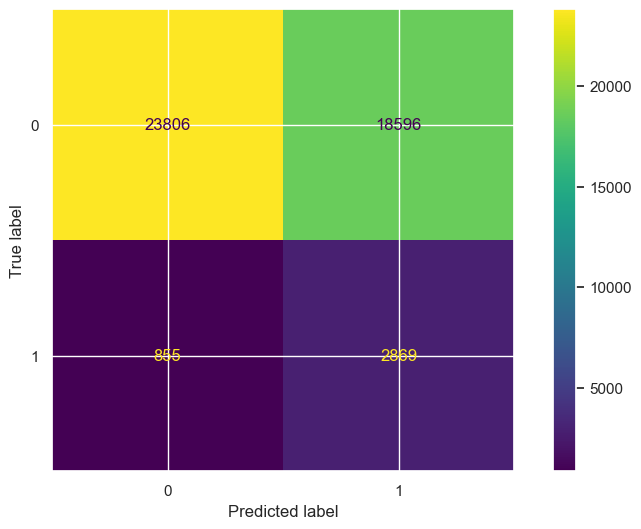

In [514]:
# premier run
with mlflow.start_run(run_name='HistGradientBoosting'): #experiment_id= experiment_id
    #HistGB_pipe.fit(X_train, y_train)
    
    seuil = 0.392732
    y_pred_proba = HistGB_pipe.predict_proba(X_test)
    y_pred_proba_seuil = [1 if p > seuil else 0 for p in regLog_pipe.predict_proba(X_test)[:,1]]
    y_pred = HistGB_pipe.predict(X_test)
    
    # Metrics
    accuracy, precision, f1, recall, auc = eval_metrics(y_test,y_pred, y_pred_proba)
    accuracy_seuil, precision_seuil, f1_seuil, recall_seuil, _ = eval_metrics(y_test,y_pred_seuil, y_pred_proba)
    print("accuracy : {:.3%} | precision : {:.3%} | f1 : {:.3%} | recall : {:.3%} | auc : {:.3%}".format(accuracy, precision, f1, recall, auc))
    print("accuracy_seuil : {:.3%} | precision_seuil : {:.3%} | f1_seuil : {:.3%} | recall_seuil : {:.3%}".format(accuracy_seuil, precision_seuil, f1_seuil, recall_seuil))
    cm = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred)
    cmSeuil = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred_seuil)
    #print("AUC:", auc)
    
    # Log metrics
    mlflow.log_metric("accuracy_test",accuracy)
    mlflow.log_metric('precision_test',precision)
    mlflow.log_metric("f1_test",f1)
    mlflow.log_metric("recall_test",recall)
    mlflow.log_metric("auc_test",auc)
    
    mlflow.log_metric("accuracy_test",accuracy_seuil)
    mlflow.log_metric('precision_test',precision_seuil)
    mlflow.log_metric("f1_test",f1_seuil)
    mlflow.log_metric("recall_test",recall_seuil)
        
    # Log figure
    mlflow.log_figure(cm.figure_, 'test_confusion_matrix.png')
    mlflow.log_figure(cmSeuil.figure_, 'test_confusion_matrix_seuil.png')
    
    # Log model
    mlflow.sklearn.log_model(HistGB_pipe, 'pipeline HistGradient Boosting', signature=signature)   
    run_idHistGB = mlflow.active_run().info.run_id

accuracy : 69.277% | precision : 16.652% | f1 : 26.813% | recall : 68.797% | auc : 76.443%
accuracy_seuil : 66.592% | precision_seuil : 13.366% | f1_seuil : 22.780% | recall_seuil : 77.041%


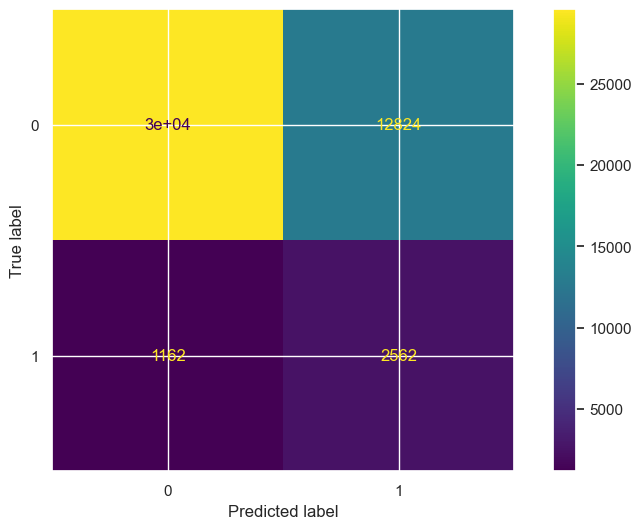

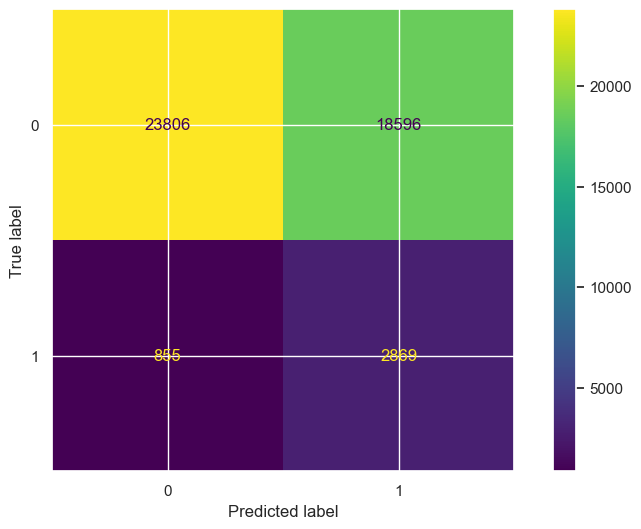

In [515]:
# premier run
with mlflow.start_run(run_name='HistGradientBoosting_SelectedFeatures'): #experiment_id= experiment_id
    #HistGB_pipe.fit(X_train, y_train)
    
    seuil = 0.411401
    y_pred_proba = HistGB_pipe_filtered.predict_proba(X_test)
    y_pred_proba_seuil = [1 if p > seuil else 0 for p in HistGB_pipe_filtered.predict_proba(X_test)[:,1]]
    y_pred = HistGB_pipe_filtered.predict(X_test)
    
    # Metrics
    accuracy, precision, f1, recall, auc = eval_metrics(y_test,y_pred, y_pred_proba)
    accuracy_seuil, precision_seuil, f1_seuil, recall_seuil, _ = eval_metrics(y_test,y_pred_seuil, y_pred_proba)
    print("accuracy : {:.3%} | precision : {:.3%} | f1 : {:.3%} | recall : {:.3%} | auc : {:.3%}".format(accuracy, precision, f1, recall, auc))
    print("accuracy_seuil : {:.3%} | precision_seuil : {:.3%} | f1_seuil : {:.3%} | recall_seuil : {:.3%}".format(accuracy_seuil, precision_seuil, f1_seuil, recall_seuil))
    cm = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred)
    cmSeuil = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred_seuil)
    #print("AUC:", auc)
    
    # Log metrics
    mlflow.log_metric("accuracy_test",accuracy)
    mlflow.log_metric('precision_test',precision)
    mlflow.log_metric("f1_test",f1)
    mlflow.log_metric("recall_test",recall)
    mlflow.log_metric("auc_test",auc)
    
    mlflow.log_metric("accuracy_test",accuracy_seuil)
    mlflow.log_metric('precision_test',precision_seuil)
    mlflow.log_metric("f1_test",f1_seuil)
    mlflow.log_metric("recall_test",recall_seuil)
        
    # Log figure
    mlflow.log_figure(cm.figure_, 'test_confusion_matrix.png')
    mlflow.log_figure(cmSeuil.figure_, 'test_confusion_matrix_seuil.png')
    
    # Log model
    mlflow.sklearn.log_model(HistGB_pipe_filtered, 'pipeline HistGradient Boosting Selected Features', signature=signature)   
    run_idHistGBf = mlflow.active_run().info.run_id

accuracy : 67.649% | precision : 18.156% | f1 : 27.704% | recall : 58.432% | auc : 74.548%
accuracy_seuil : 66.592% | precision_seuil : 13.366% | f1_seuil : 22.780% | recall_seuil : 77.041%


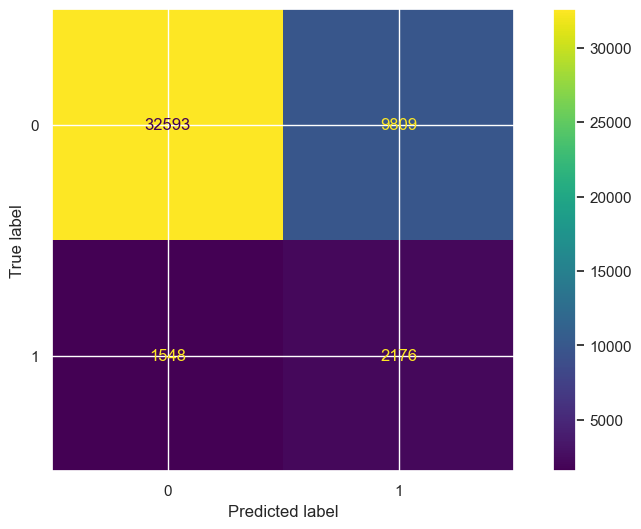

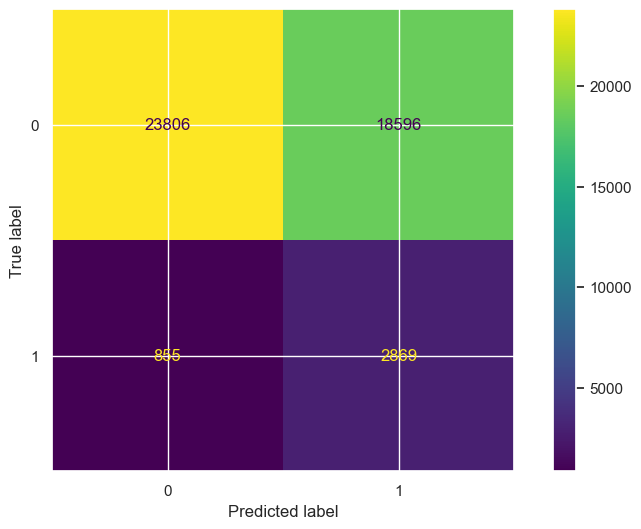

In [516]:
# premier run
with mlflow.start_run(run_name='HistGradientBoosting_Selected_smote'): #experiment_id= experiment_id
    #HistGB_pipe_filtered_smote.fit(X_train, y_train)
    
    seuil = 0.364158
    y_pred_proba = HistGB_pipe_filtered_smote.predict_proba(X_test)
    y_pred_proba_seuil = [1 if p > seuil else 0 for p in HistGB_pipe_filtered_smote.predict_proba(X_test)[:,1]]
    y_pred = HistGB_pipe_filtered_smote.predict(X_test)
    
    # Metrics
    accuracy, precision, f1, recall, auc = eval_metrics(y_test,y_pred, y_pred_proba)
    accuracy_seuil, precision_seuil, f1_seuil, recall_seuil, _ = eval_metrics(y_test,y_pred_seuil, y_pred_proba)
    print("accuracy : {:.3%} | precision : {:.3%} | f1 : {:.3%} | recall : {:.3%} | auc : {:.3%}".format(accuracy, precision, f1, recall, auc))
    print("accuracy_seuil : {:.3%} | precision_seuil : {:.3%} | f1_seuil : {:.3%} | recall_seuil : {:.3%}".format(accuracy_seuil, precision_seuil, f1_seuil, recall_seuil))
    cm = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred)
    cmSeuil = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred_seuil)
    #print("AUC:", auc)
    
    # Log metrics
    mlflow.log_metric("accuracy_test",accuracy)
    mlflow.log_metric('precision_test',precision)
    mlflow.log_metric("f1_test",f1)
    mlflow.log_metric("recall_test",recall)
    mlflow.log_metric("auc_test",auc)
    
    mlflow.log_metric("accuracy_test",accuracy_seuil)
    mlflow.log_metric('precision_test',precision_seuil)
    mlflow.log_metric("f1_test",f1_seuil)
    mlflow.log_metric("recall_test",recall_seuil)
        
    # Log figure
    mlflow.log_figure(cm.figure_, 'test_confusion_matrix.png')
    mlflow.log_figure(cmSeuil.figure_, 'test_confusion_matrix_seuil.png')
    
    # Log model
    mlflow.sklearn.log_model(HistGB_pipe_filtered_smote, 'pipeline HistGradient Boosting Selected Features Resampling SMOTE', signature=signature)   
    run_idHistGBfs = mlflow.active_run().info.run_id

### Light Gradient Boosting 

accuracy : 69.789% | precision : 17.010% | f1 : 27.311% | recall : 69.253% | auc : 76.495%
accuracy_seuil : 66.592% | precision_seuil : 13.366% | f1_seuil : 22.780% | recall_seuil : 77.041%


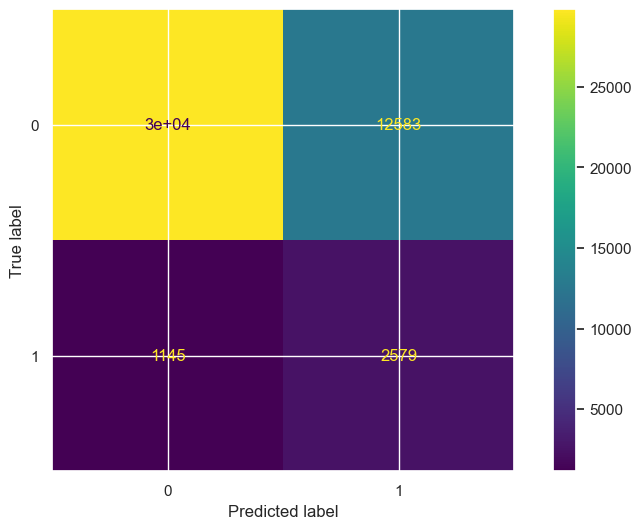

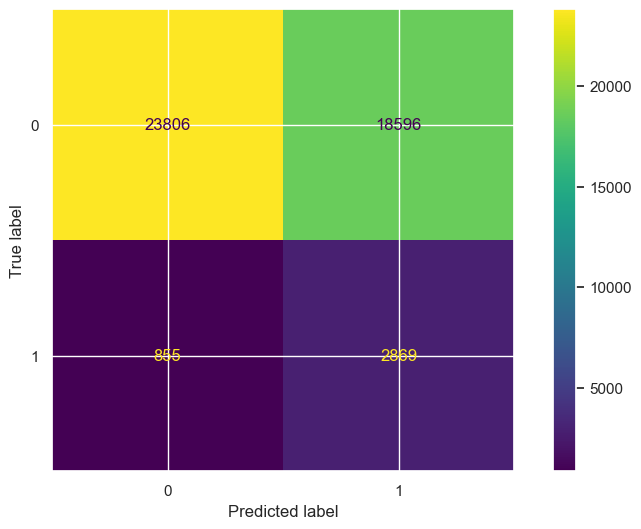

In [517]:
# premier run
with mlflow.start_run(run_name='LightGBM_1'): #experiment_id= experiment_id
    #LGBM_pipe.fit(X_train, y_train)
    
    seuil = 0.397859
    y_pred_proba = LGBM_pipe.predict_proba(X_test)
    y_pred_proba_seuil = [1 if p > seuil else 0 for p in LGBM_pipe.predict_proba(X_test)[:,1]]
    y_pred = LGBM_pipe.predict(X_test)
    
    # Metrics
    accuracy, precision, f1, recall, auc = eval_metrics(y_test,y_pred, y_pred_proba)
    accuracy_seuil, precision_seuil, f1_seuil, recall_seuil, _ = eval_metrics(y_test,y_pred_seuil, y_pred_proba)
    print("accuracy : {:.3%} | precision : {:.3%} | f1 : {:.3%} | recall : {:.3%} | auc : {:.3%}".format(accuracy, precision, f1, recall, auc))
    print("accuracy_seuil : {:.3%} | precision_seuil : {:.3%} | f1_seuil : {:.3%} | recall_seuil : {:.3%}".format(accuracy_seuil, precision_seuil, f1_seuil, recall_seuil))
    cm = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred)
    cmSeuil = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred_seuil)
    #print("AUC:", auc)
    
    # Log metrics
    mlflow.log_metric("accuracy_test",accuracy)
    mlflow.log_metric('precision_test',precision)
    mlflow.log_metric("f1_test",f1)
    mlflow.log_metric("recall_test",recall)
    mlflow.log_metric("auc_test",auc)
    
    mlflow.log_metric("accuracy_test",accuracy_seuil)
    mlflow.log_metric('precision_test',precision_seuil)
    mlflow.log_metric("f1_test",f1_seuil)
    mlflow.log_metric("recall_test",recall_seuil)
        
    # Log figure
    mlflow.log_figure(cm.figure_, 'test_confusion_matrix.png')
    mlflow.log_figure(cmSeuil.figure_, 'test_confusion_matrix_seuil.png')
    
    # Log model
    mlflow.sklearn.log_model(LGBM_pipe, 'pipeline Light Gradient Boosting', signature=signature)
    run_idlgbm = mlflow.active_run().info.run_id

</Br>

</Br>

In [22]:
sfs_mlxtend = joblib.load( "data/modeles sauvegardés/featureSelectionSFS.sav")

In [23]:
#mask train_application
id1 = df.TARGET==1
id0 = df.TARGET==0

# train test application
df_dashboard = pd.concat([df.loc[id0].sample(5),df.loc[id1].sample(5)],axis=0)
test_df_dashboard = test_df.sample(10)

In [27]:
# export dataframe
joblib.dump(df_dashboard,'data/cleaned/application_train.sav')
joblib.dump(test_df_dashboard,'data/cleaned/application_test.sav')

['data/cleaned/application_test.sav']

### <a name="C52"><font color='blue'>V.2 Model Registry (Registre de modèle) </font></a>

Le Model Registry (registre de modèles) est un composant de MLflow qui permet de gérer des versions de modèles de Machine Learning, en proposant également des stages (états).

* Le tag staging correspond à un modèle considéré comme pré-production.
* Le tag production correspond à un modèle qui serait en environnement de production.
* Le tag archived pour les anciens modèles archivés.

C'est un composant particulièrement utile pour gérer le cycle de vie des modèles, car le cycle staging, production et archive est couramment appliqué lorsque des modèles sont mis à jour régulièrement. Sous MLflow, l'onglet Models permet d'afficher tous les modèles enregistrés.

###  Enregistrement d'un modèle</font></Br>
1. Dans la page de détail des exécutions MLflow, sélectionnez un modèle MLflow enregistré dans la section Artefacts.</Br>
2. Cliquez sur le bouton Enregistrer le modèle .
</Br></Br>
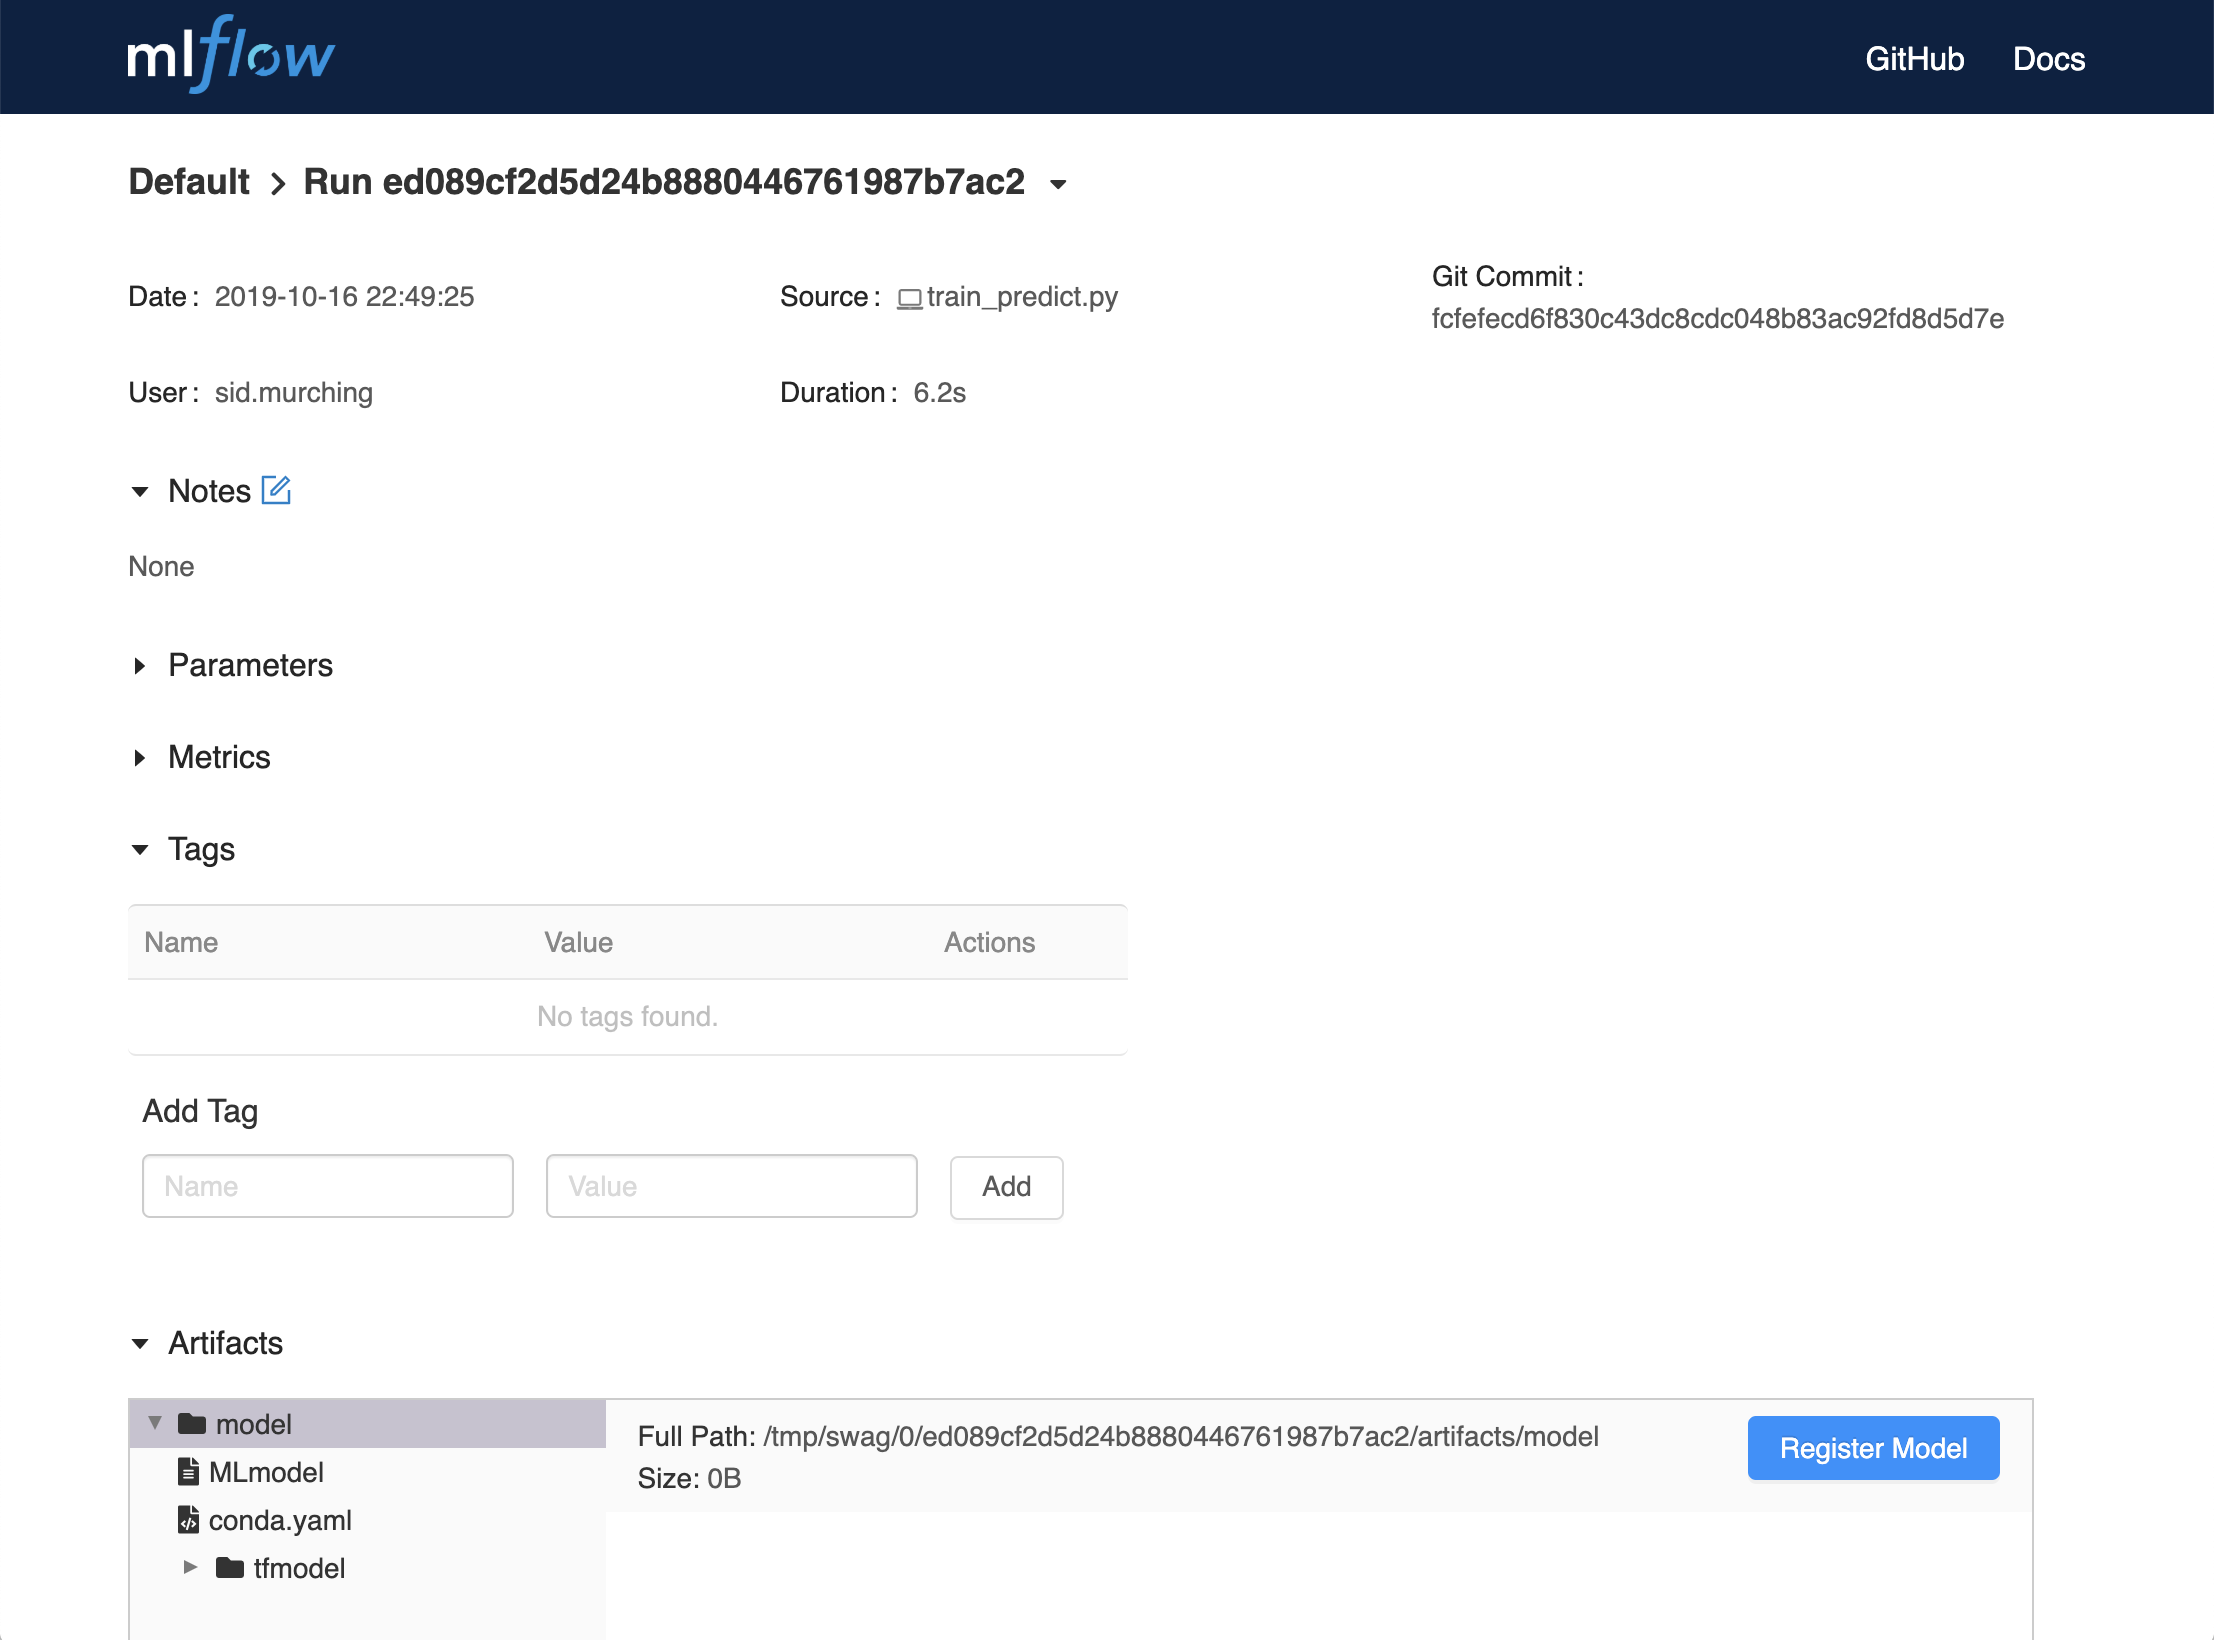

 3. Dans le champ Nom du modèle , si vous ajoutez un nouveau modèle, spécifiez un nom unique pour identifier le modèle. Si vous enregistrez une nouvelle version d'un modèle existant, sélectionnez le nom du modèle existant dans la liste déroulante.
</Br></Br>
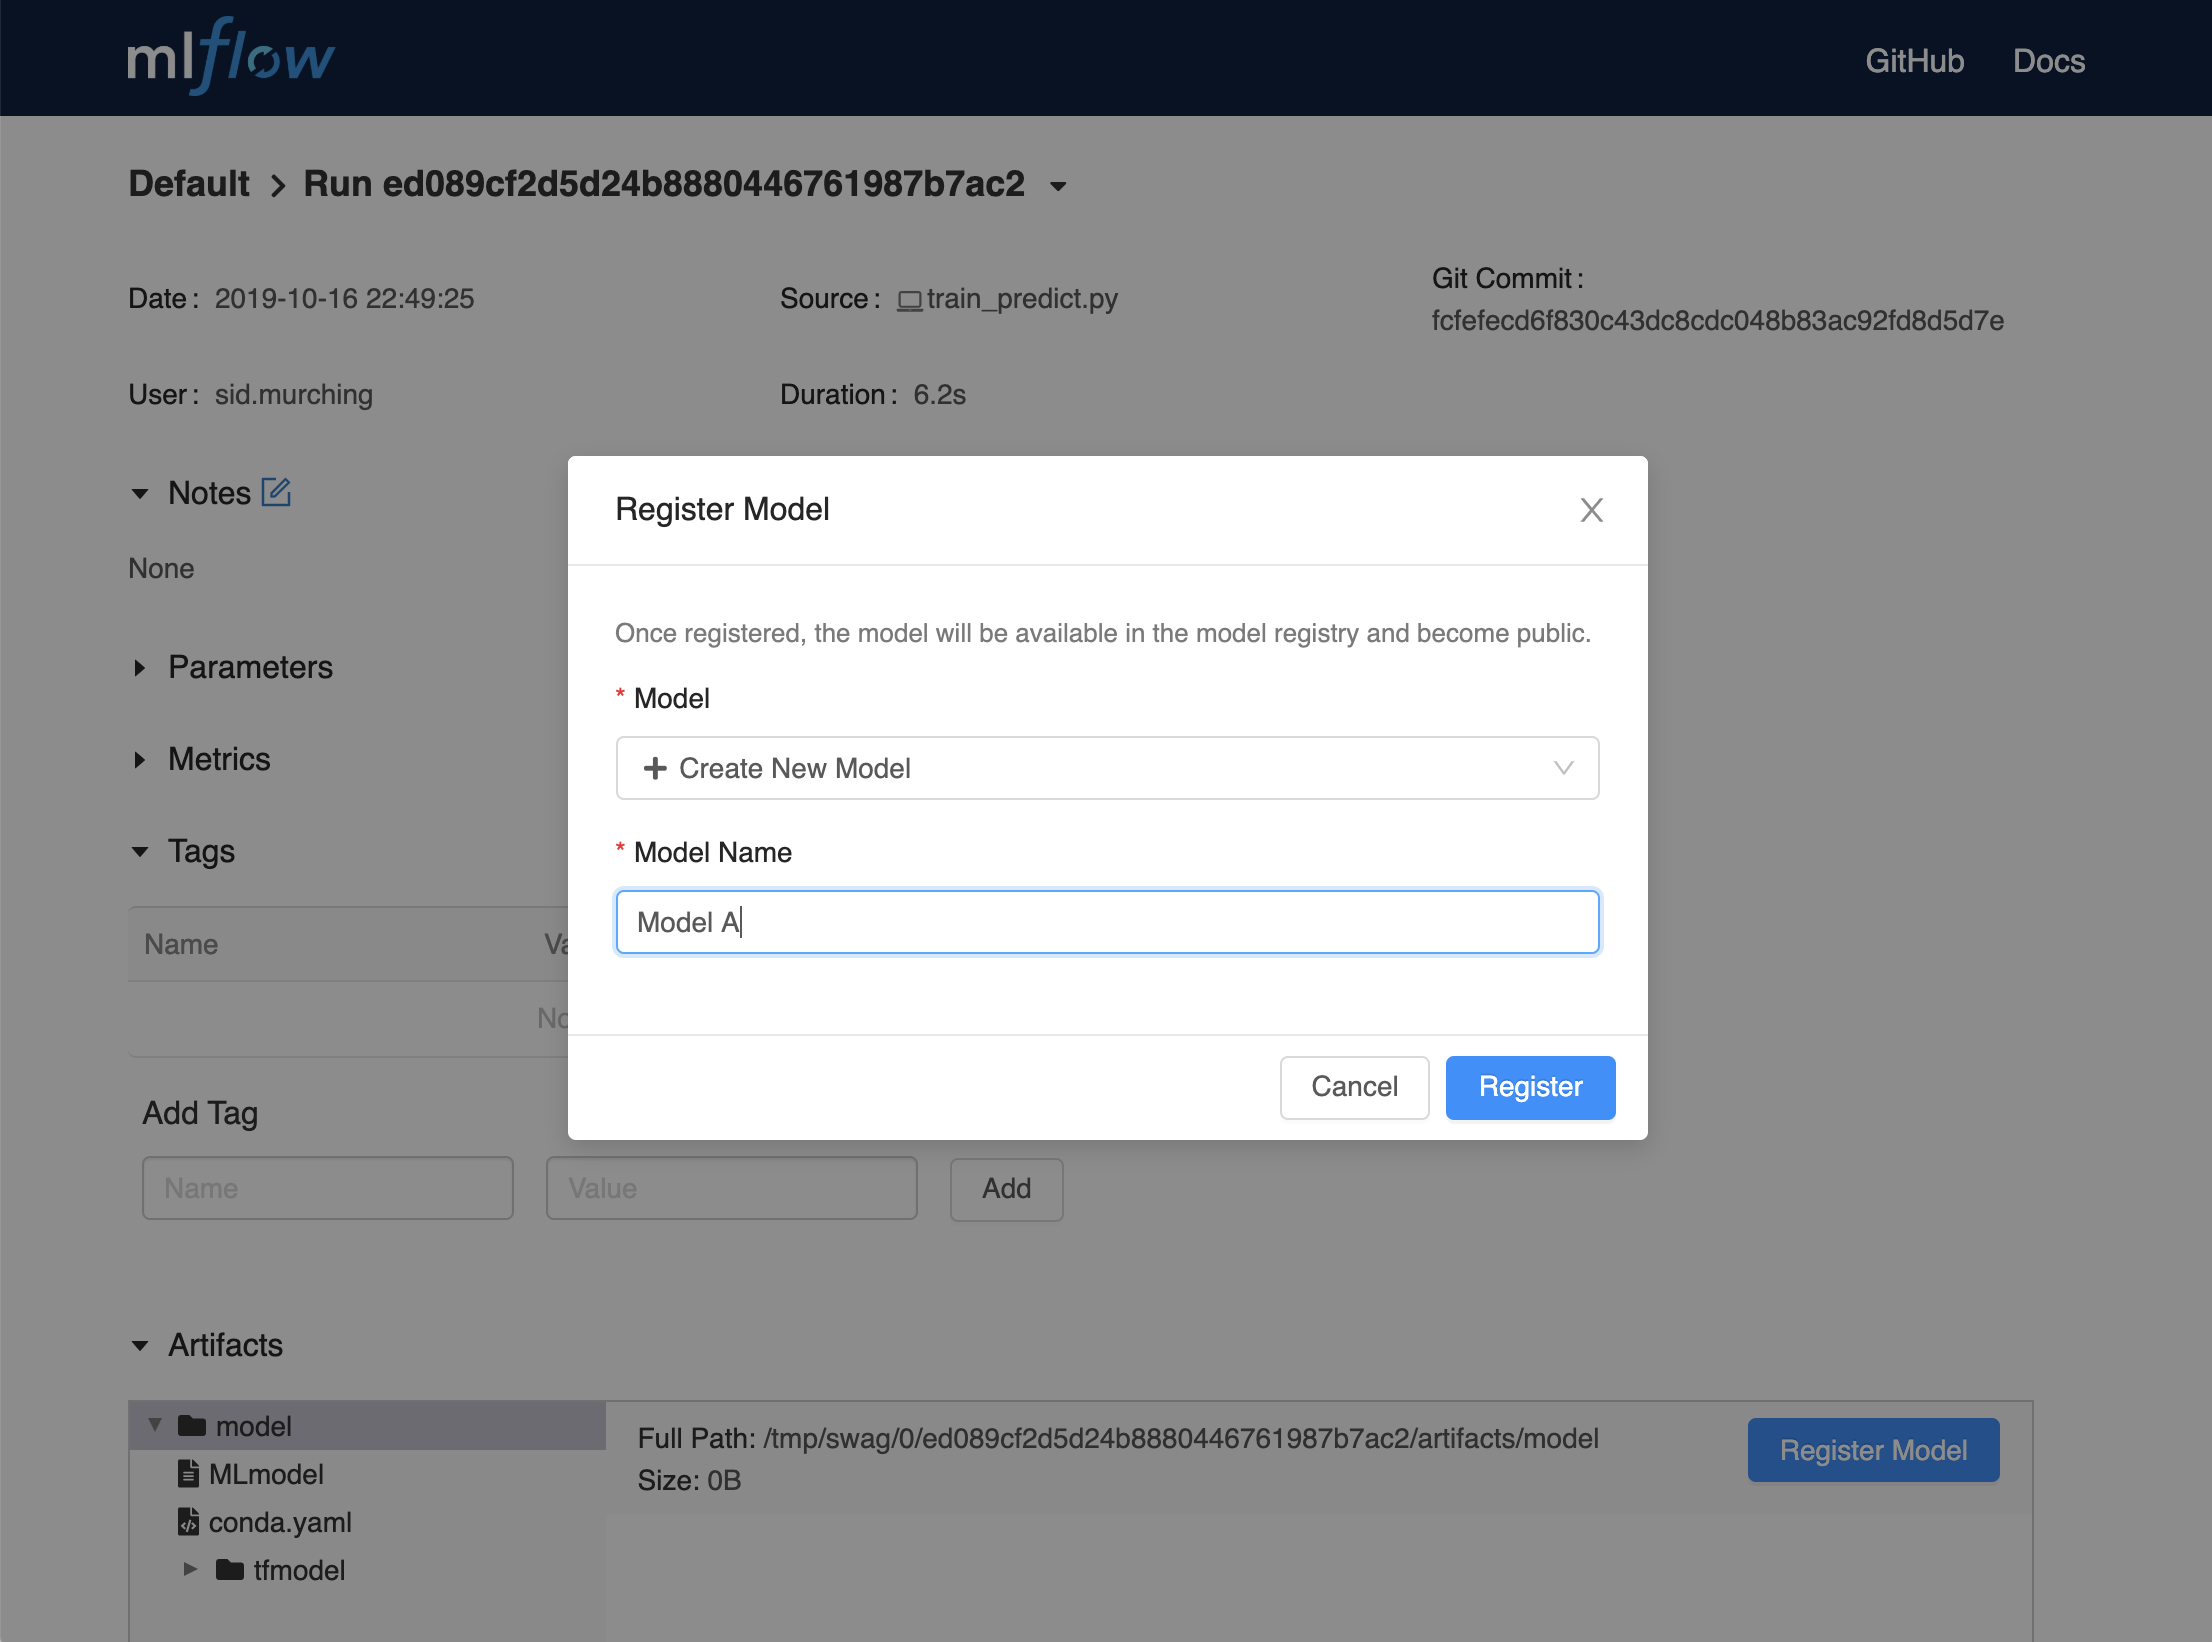

### Utilisation du registre modèle
* Accédez à la page Modèles enregistrés et affichez les propriétés du modèle.
</Br></Br>
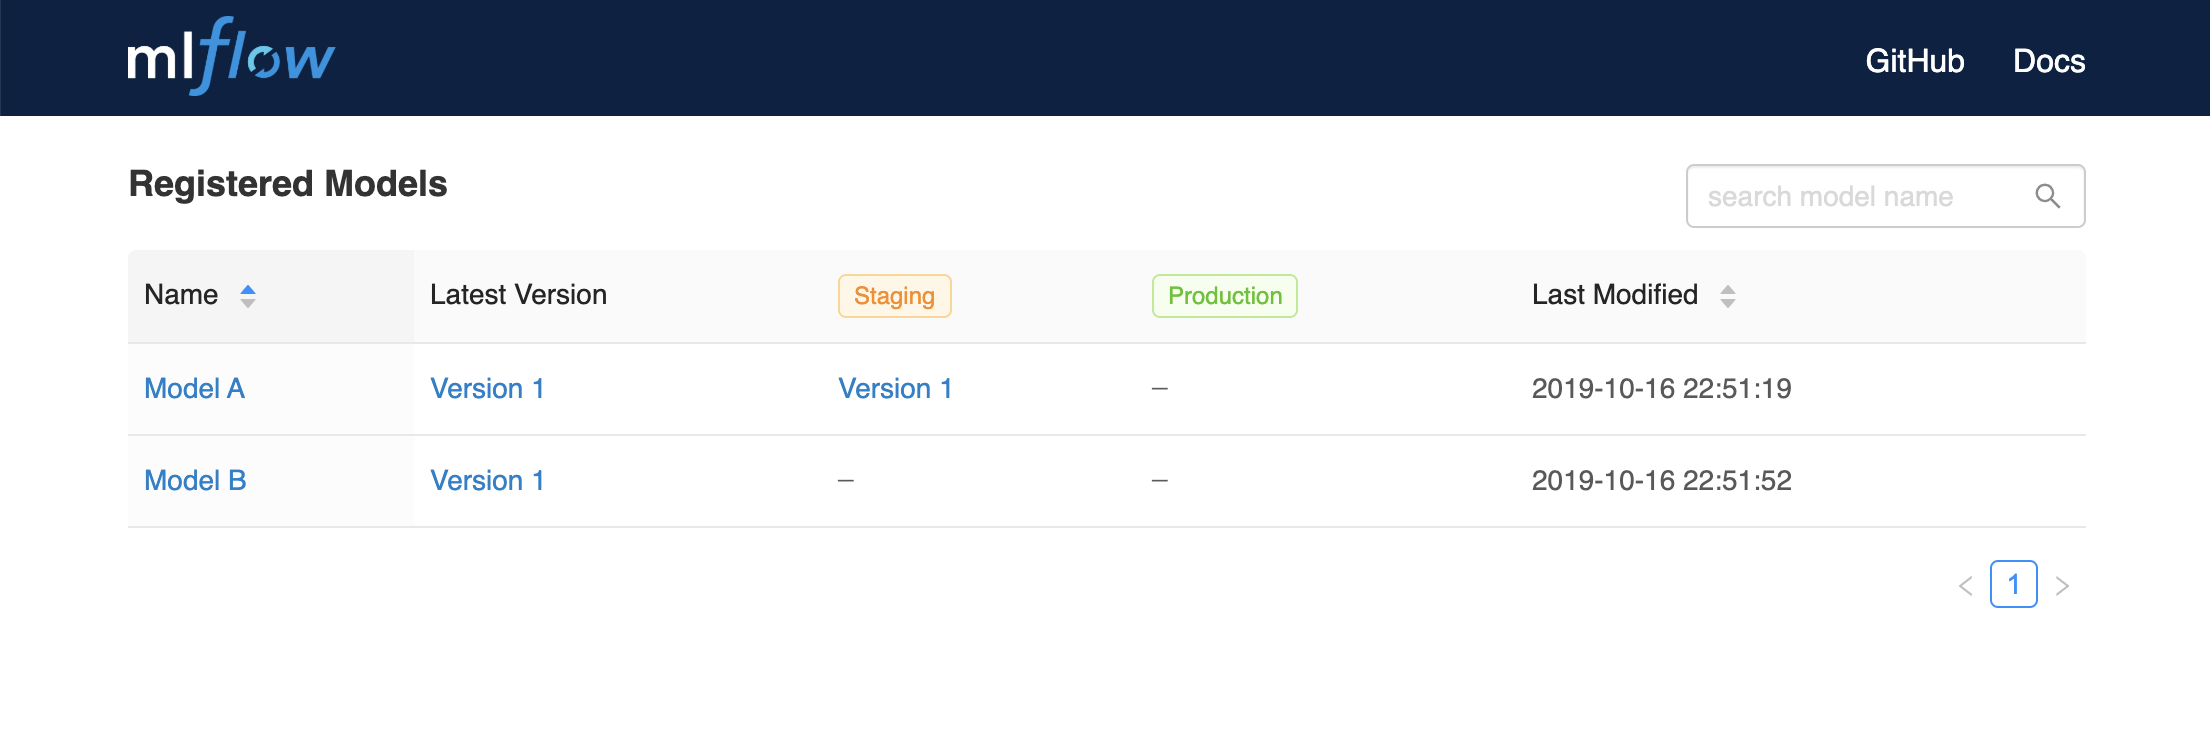

* Accédez à la section Artefacts de la page de détail de l'exécution, cliquez sur le modèle, 
* puis cliquez sur la version du modèle en haut à droite pour afficher la version que vous venez de créer.
</Br></Br>
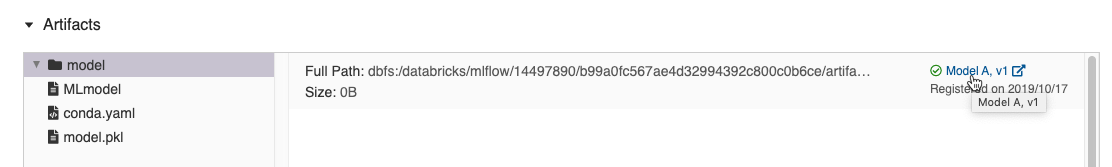

### <a name="C53"><font color='blue'>V.3 Déploiement d'une API REST </font></a>

Les commandes suivantes sont à lancer **depuis le terminal** associé à votre environnement Python.

<img src='../Cours et ressources/logo_oc.png' width=15px /> À partir du modèle MLflow, vous n'êtes plus qu'à une commande de lancer un serveur pour votre API REST ([documentation](https://mlflow.org/docs/latest/models.html#deploy-mlflow-models)).</Br> 
À vous de jouer ! [(en cas de blocage)](https://mlflow.org/docs/latest/cli.html#mlflow-models-serve)

<img src='../Cours et ressources/logo_oc.png' width=15px />  Écrivez la requête curl pour envoyer une requête. Faites attention aux guillemets :)

In [90]:
import streamlit
streamlit

<module 'streamlit' from 'C:\\Users\\eleor\\anaconda3\\envs\\py3_9_projet7_OC_DS\\lib\\site-packages\\streamlit\\__init__.py'>